# Self‑Supervised Learning & Interactive Latent Space Visualization

This notebook demonstrates a self‑supervised workflow using a dataset of PNG images (organized by class). We:
- Load and split the data using stratification.
- Perform KMeans clustering on flattened images and evaluate with a confusion matrix.
- Train a simple convolutional autoencoder (with training/validation loss monitoring).
- Extract latent features and evaluate them using Logistic Regression and Random Forest.
- **Interactively explore the latent space:** Use the sliders below to choose which latent dimensions to plot in an Altair scatter plot.


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
import ipywidgets as widgets
from IPython.display import display, clear_output
import seaborn as sns
from collections import Counter
from PIL import Image

# Set device (for simplicity, we'll use CPU)
device = torch.device("cpu")
print("Using device:", device)

/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/bin/../lib/libjpeg.9.dylib' (no such file)'If you don'

Using device: cpu


In [2]:
# Define transforms: resize images to 64x64 and convert to tensor.
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Set the data directory. Each subfolder should correspond to one class.
data_dir = "./data/dataset"  
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print("Found classes:", dataset.classes)

# Get all indices and labels.
all_indices = np.arange(len(dataset))
all_labels = np.array(dataset.targets)

# Stratified split: 80% for train+val, 20% for test.
trainval_idx, test_idx = train_test_split(all_indices, test_size=0.2, stratify=all_labels, random_state=42)
# Split train+val into 90% train and 10% validation.
train_idx, val_idx = train_test_split(trainval_idx, test_size=0.1, stratify=all_labels[trainval_idx], random_state=42)

print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_idx)}")
print(f"Validation images: {len(val_idx)}")
print(f"Test images: {len(test_idx)}")
print("Training label distribution:", Counter(all_labels[train_idx]))

# Create subsets and DataLoaders.
batch_size = 32
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Found classes: ['circles', 'hexagons', 'pentagons', 'quatrefoil', 'spikes', 'squares', 'triangles']
Total images: 2100
Training images: 1512
Validation images: 168
Test images: 420
Training label distribution: Counter({1: 216, 0: 216, 4: 216, 2: 216, 6: 216, 3: 216, 5: 216})


In [3]:
# Flatten every image in the full dataset and run KMeans clustering.
all_X = []
all_y = []
for img, label in dataset:
    all_X.append(img.view(-1).numpy())
    all_y.append(label)
all_X = np.array(all_X)
all_y = np.array(all_y)
print("Data shape (samples x features):", all_X.shape)

# Run KMeans clustering (without using labels).
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_X)

Data shape (samples x features): (2100, 12288)


KMeans Clustering Accuracy: 21.10%
KMeans Clustering F1 Score: 0.1997


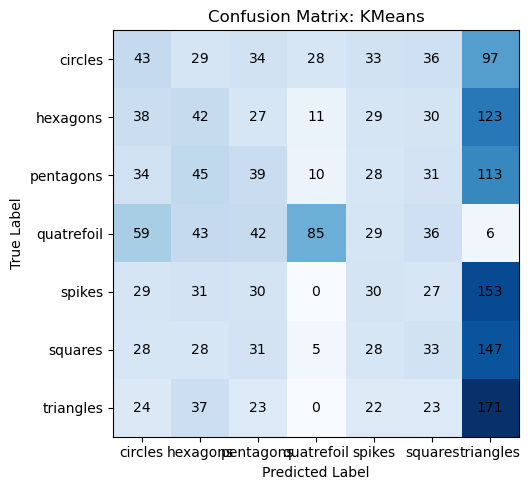

In [4]:
def map_cluster_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    new_preds = np.array([mapping[label] for label in y_pred])
    return new_preds, mapping

mapped_preds, mapping = map_cluster_labels(all_y, cluster_labels)

kmeans_acc = accuracy_score(all_y, mapped_preds) * 100
kmeans_f1 = f1_score(all_y, mapped_preds, average='macro')
print(f"KMeans Clustering Accuracy: {kmeans_acc:.2f}%")
print(f"KMeans Clustering F1 Score: {kmeans_f1:.4f}")

# Plot confusion matrix for KMeans.
cm_kmeans = confusion_matrix(all_y, mapped_preds)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_kmeans, cmap="Blues")
ax.set_title("Confusion Matrix: KMeans")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_xticks(np.arange(len(dataset.classes)))
ax.set_yticks(np.arange(len(dataset.classes)))
ax.set_xticklabels(dataset.classes)
ax.set_yticklabels(dataset.classes)
for i in range(cm_kmeans.shape[0]):
    for j in range(cm_kmeans.shape[1]):
        ax.text(j, i, cm_kmeans[i, j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()


In [5]:
import torch.nn as nn
import torchvision.models as models

class VAE_ResNet18(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE_ResNet18, self).__init__()
        # Use ResNet18 as the encoder backbone (up to the final avgpool).
        resnet = models.resnet18(pretrained=True)
        # Remove the final fully connected layer.
        self.encoder_conv = nn.Sequential(*list(resnet.children())[:-1])
        # The output of encoder_conv is (batch, 512, 1, 1) -> flattened to 512.
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        # Decoder: Map latent vector to an intermediate feature map, then upsample.
        # Here, we map the latent vector to a (512, 4, 4) feature map.
        self.decoder_fc = nn.Linear(latent_dim, 512 * 4 * 4)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # -> (256, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # -> (128, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # -> (64, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # -> (3, 64, 64)
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        batch_size = x.size(0)
        # Encoder: pass input through ResNet18 backbone.
        h = self.encoder_conv(x)  # (batch, 512, 1, 1)
        h = h.view(batch_size, -1)  # Flatten to (batch, 512)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        # Decoder:
        h_dec = self.decoder_fc(z)  # (batch, 512*4*4)
        h_dec = h_dec.view(batch_size, 512, 4, 4)  # Reshape to (batch, 512, 4, 4)
        x_recon = self.decoder_conv(h_dec)
        return x_recon, mu, logvar
    
    def get_latent(self, x):
        batch_size = x.size(0)
        h = self.encoder_conv(x)
        h = h.view(batch_size, -1)
        mu = self.fc_mu(h)
        return mu

# Instantiate the VAE with ResNet18 encoder.
vae = VAE_ResNet18(latent_dim=32).to(device)


Epoch 1 Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 Training: 100%|██████████| 48/48 [00:04<00:00, 10.07it/s, Beta=1e-10, ReconLoss=0.0078, KL_Loss=888.7477, BatchLoss=0.0078] 


Epoch 1: Train Loss = 0.0116, Val Loss = 0.0118


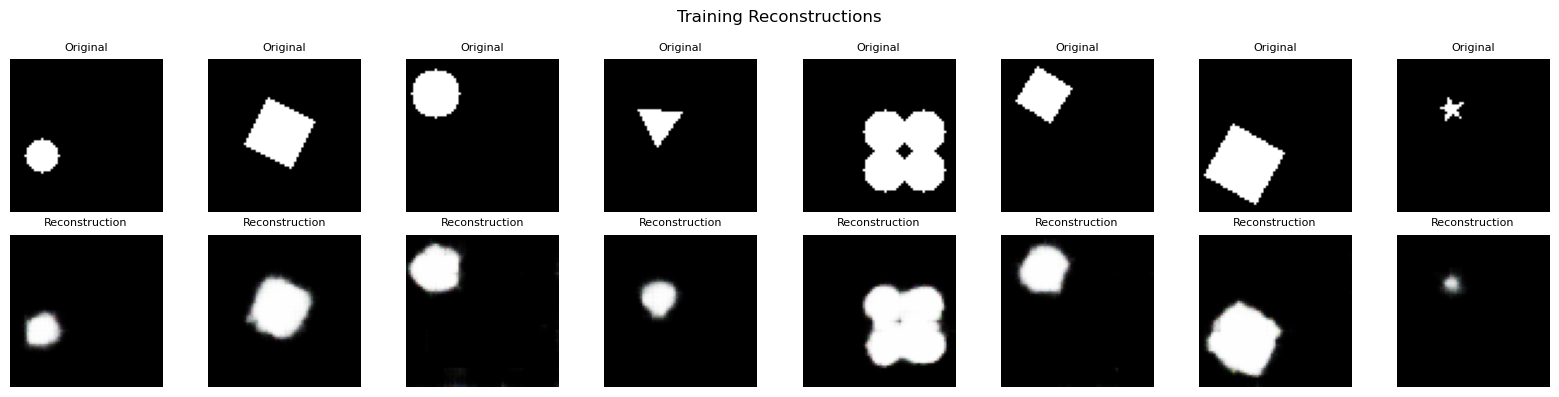

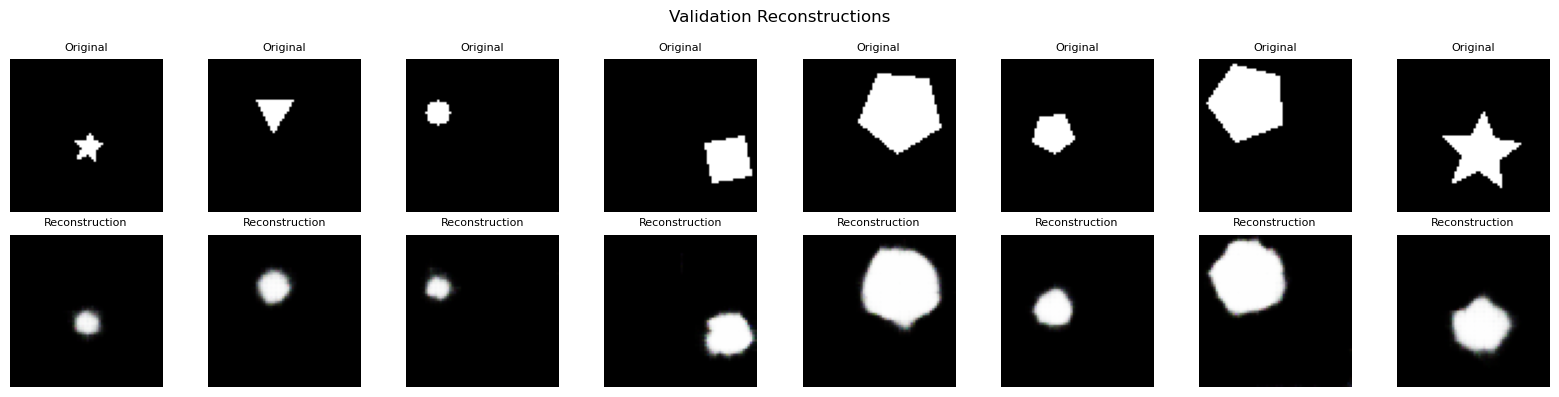

Epoch 2 Training: 100%|██████████| 48/48 [00:04<00:00, 10.40it/s, Beta=1e-10, ReconLoss=0.0098, KL_Loss=924.3116, BatchLoss=0.0098]


Epoch 2: Train Loss = 0.0094, Val Loss = 0.0116


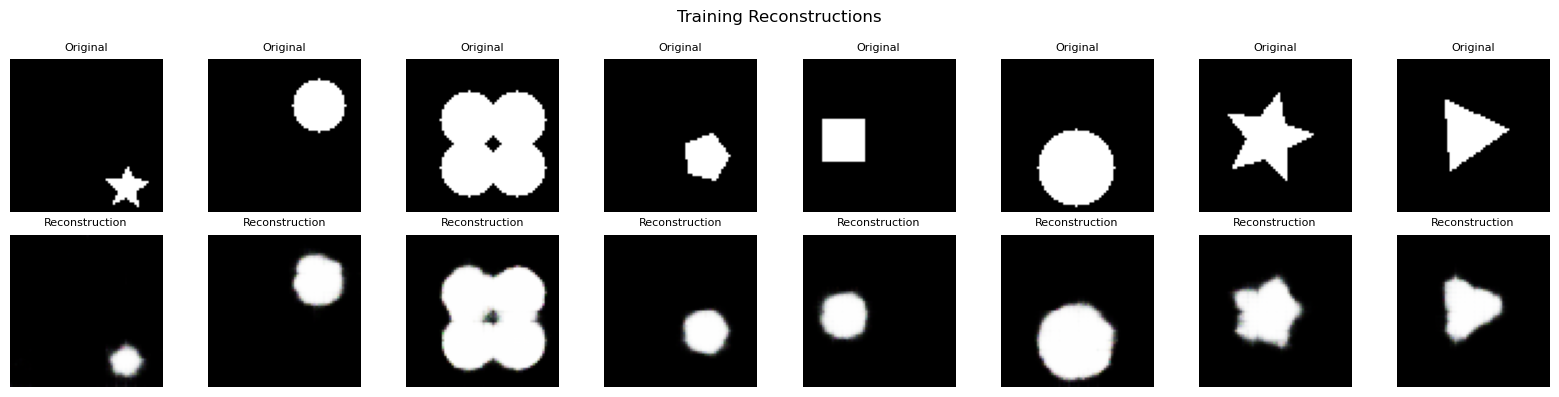

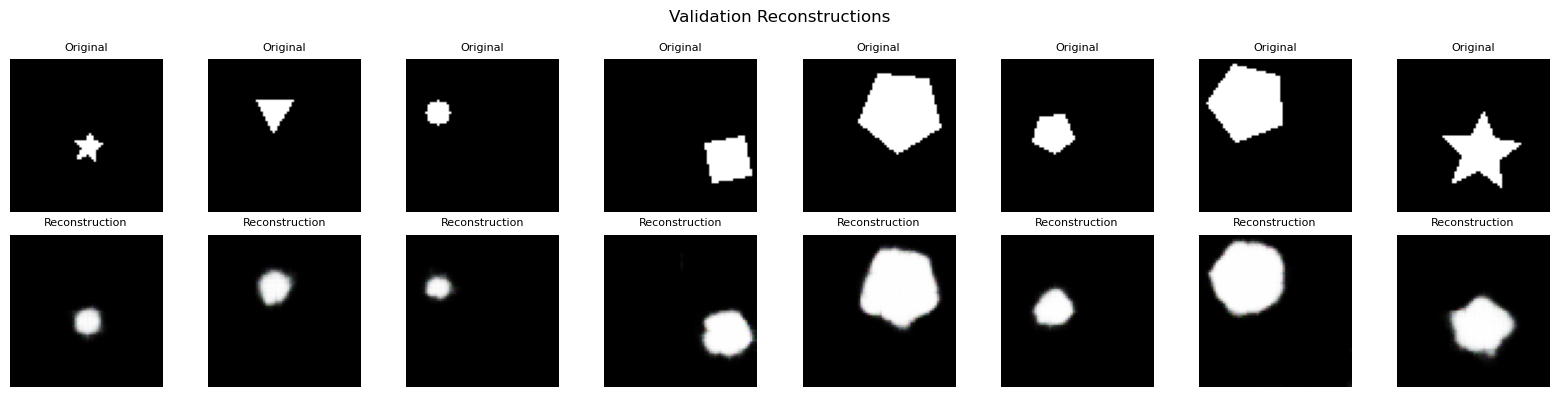

Epoch 3 Training: 100%|██████████| 48/48 [00:04<00:00, 10.42it/s, Beta=1e-10, ReconLoss=0.0064, KL_Loss=534.4880, BatchLoss=0.0064]


Epoch 3: Train Loss = 0.0094, Val Loss = 0.0118


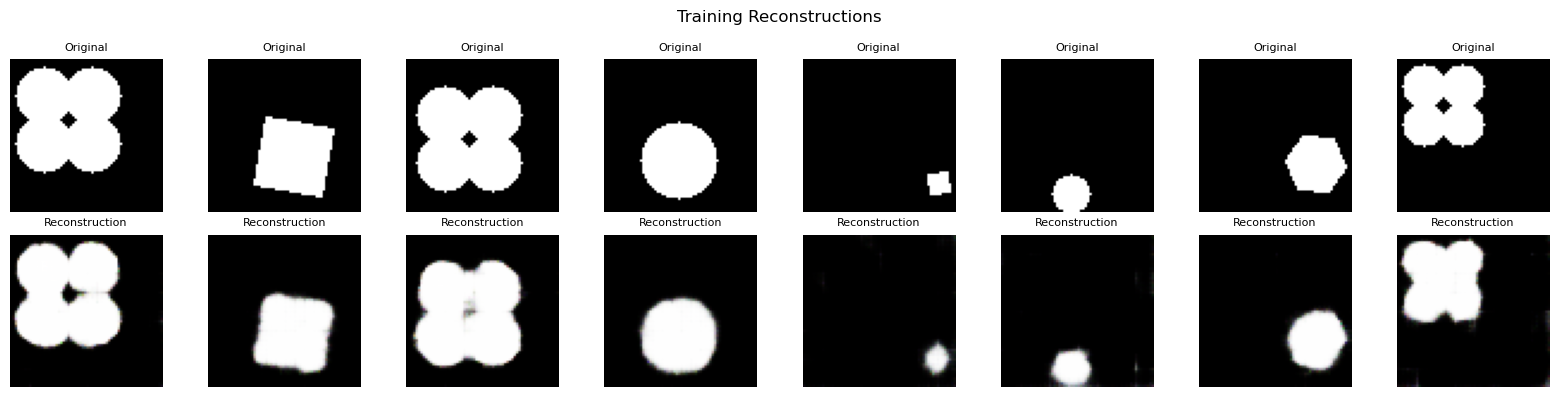

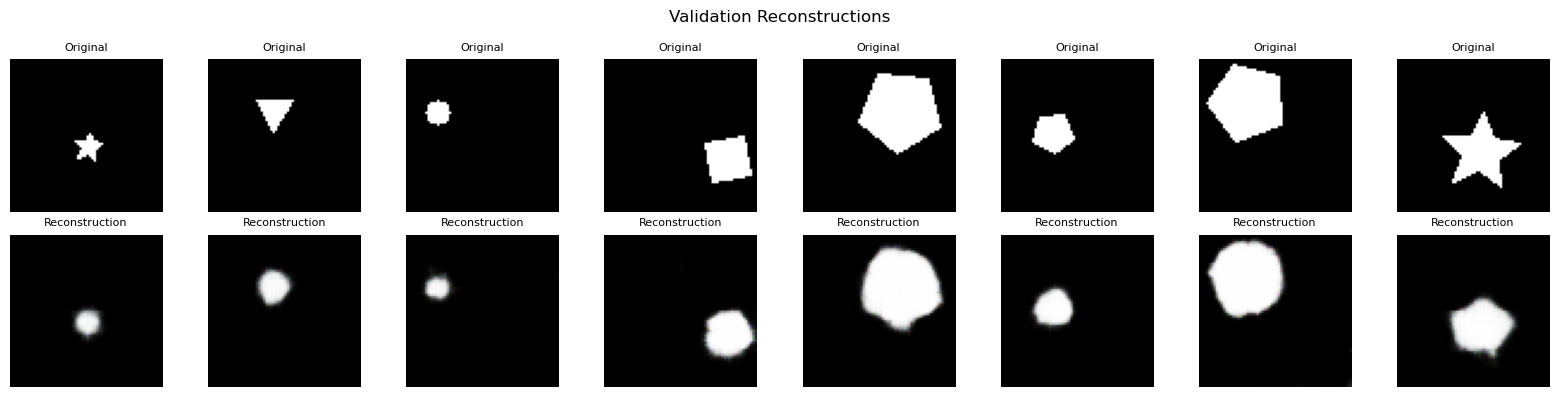

Epoch 4 Training: 100%|██████████| 48/48 [00:04<00:00, 10.67it/s, Beta=1e-10, ReconLoss=0.0114, KL_Loss=728.5833, BatchLoss=0.0114]


Epoch 4: Train Loss = 0.0093, Val Loss = 0.0117


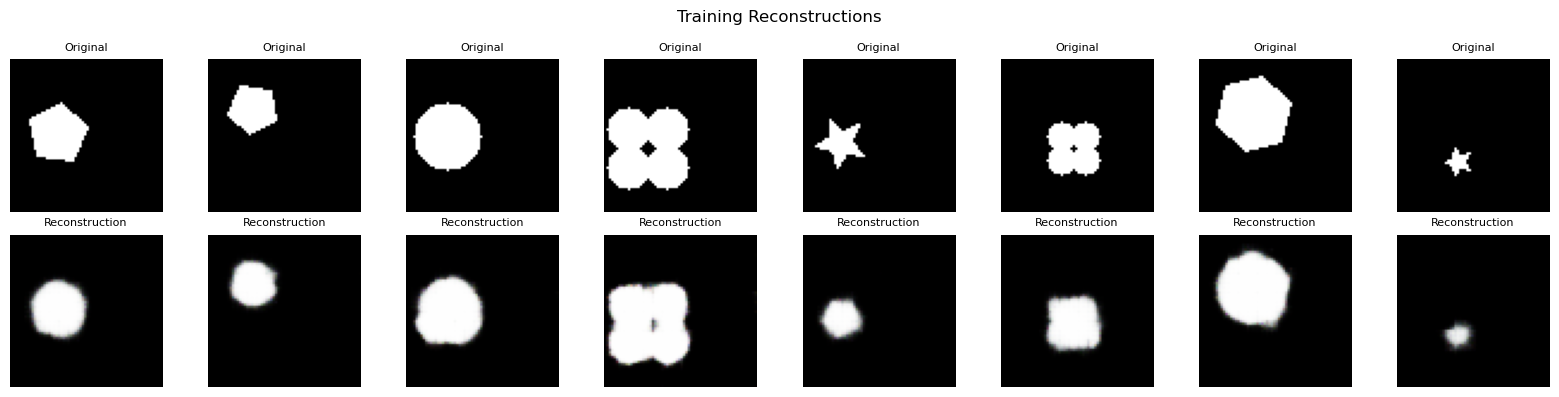

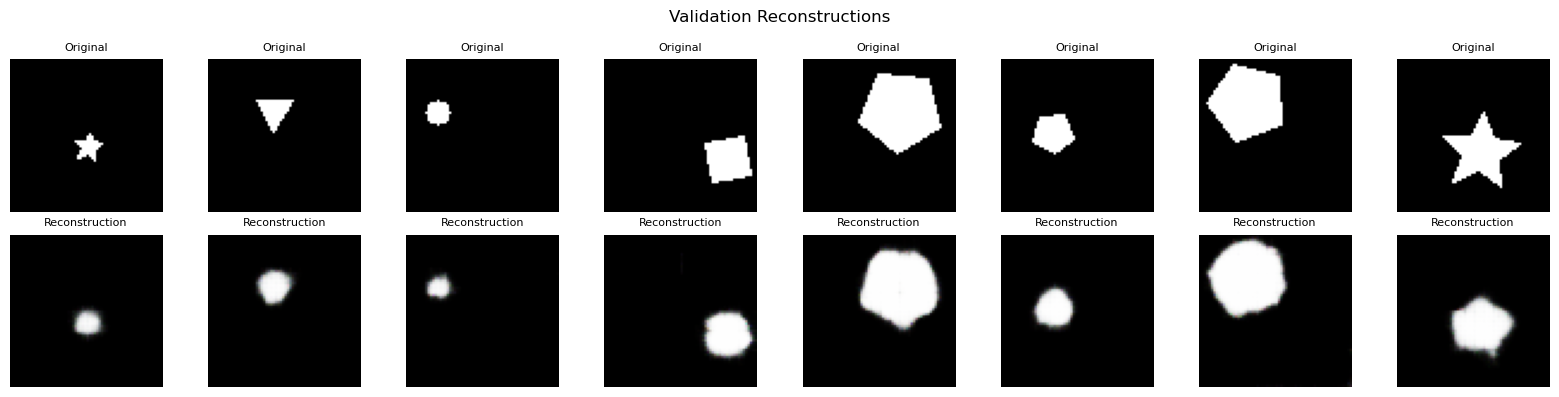

Epoch 5 Training: 100%|██████████| 48/48 [00:04<00:00, 10.16it/s, Beta=1e-10, ReconLoss=0.0100, KL_Loss=601.2828, BatchLoss=0.0100] 


Epoch 5: Train Loss = 0.0092, Val Loss = 0.0117


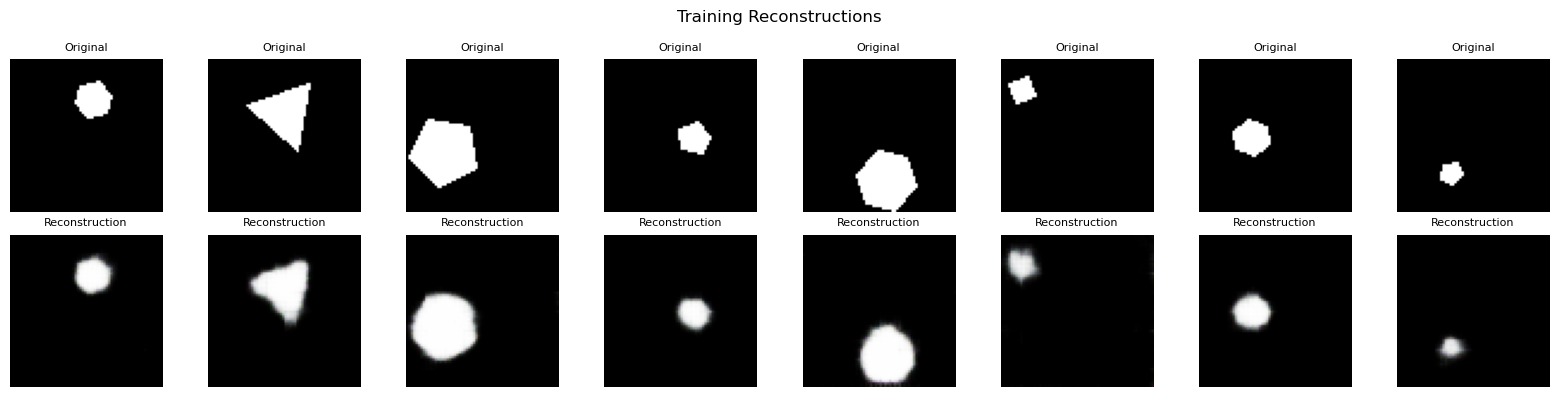

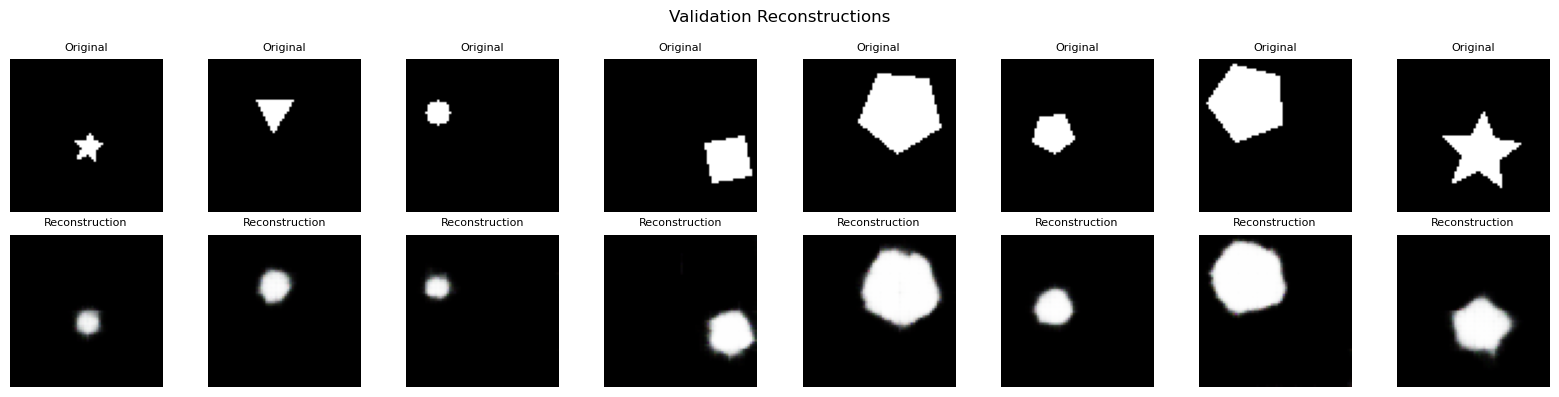

Epoch 6 Training: 100%|██████████| 48/48 [00:04<00:00, 10.31it/s, Beta=1e-10, ReconLoss=0.0102, KL_Loss=563.8746, BatchLoss=0.0102]


Epoch 6: Train Loss = 0.0090, Val Loss = 0.0111


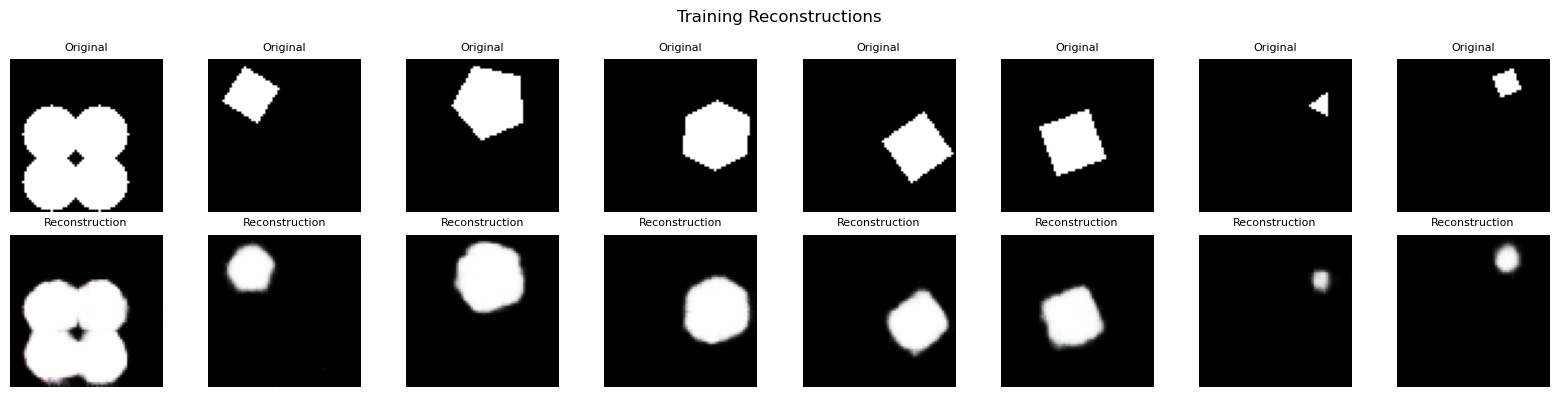

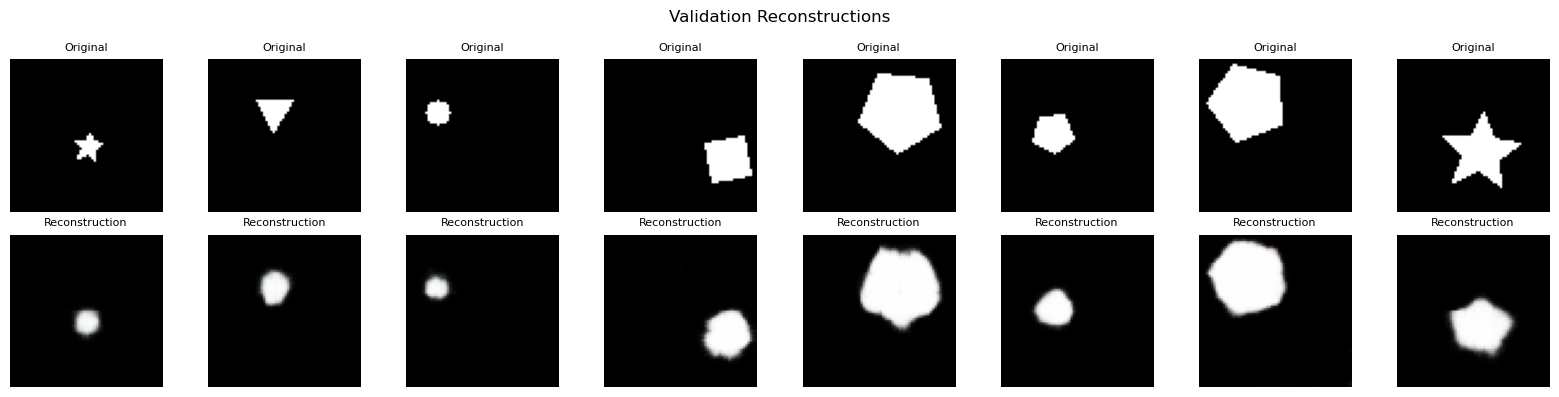

Epoch 7 Training: 100%|██████████| 48/48 [00:04<00:00, 10.70it/s, Beta=1e-10, ReconLoss=0.0093, KL_Loss=571.0130, BatchLoss=0.0093]


Epoch 7: Train Loss = 0.0088, Val Loss = 0.0111


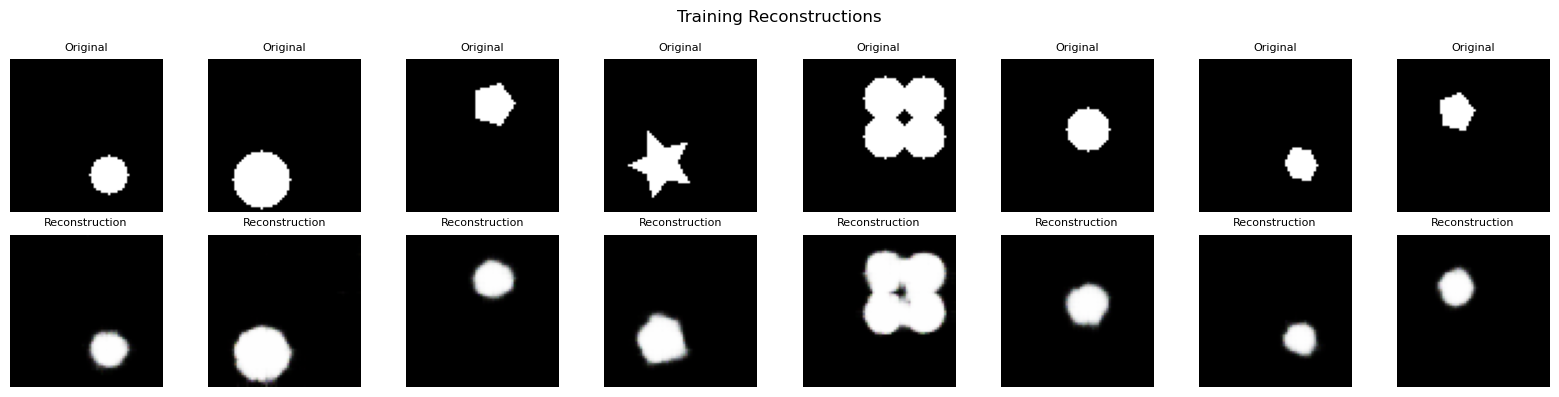

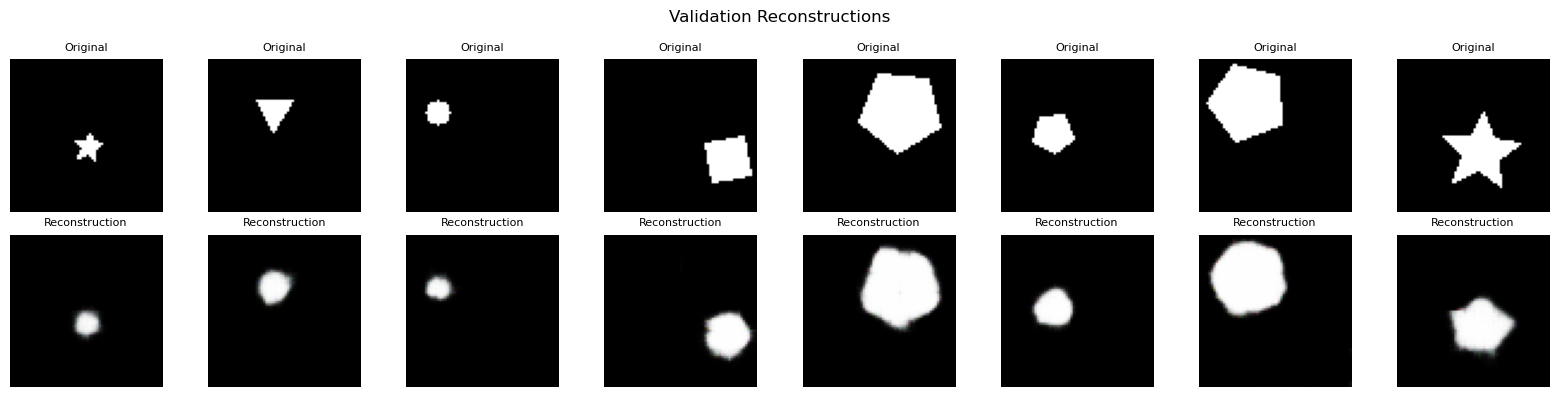

Epoch 8 Training: 100%|██████████| 48/48 [00:04<00:00,  9.98it/s, Beta=1e-10, ReconLoss=0.0073, KL_Loss=454.1522, BatchLoss=0.0073]


Epoch 8: Train Loss = 0.0088, Val Loss = 0.0117


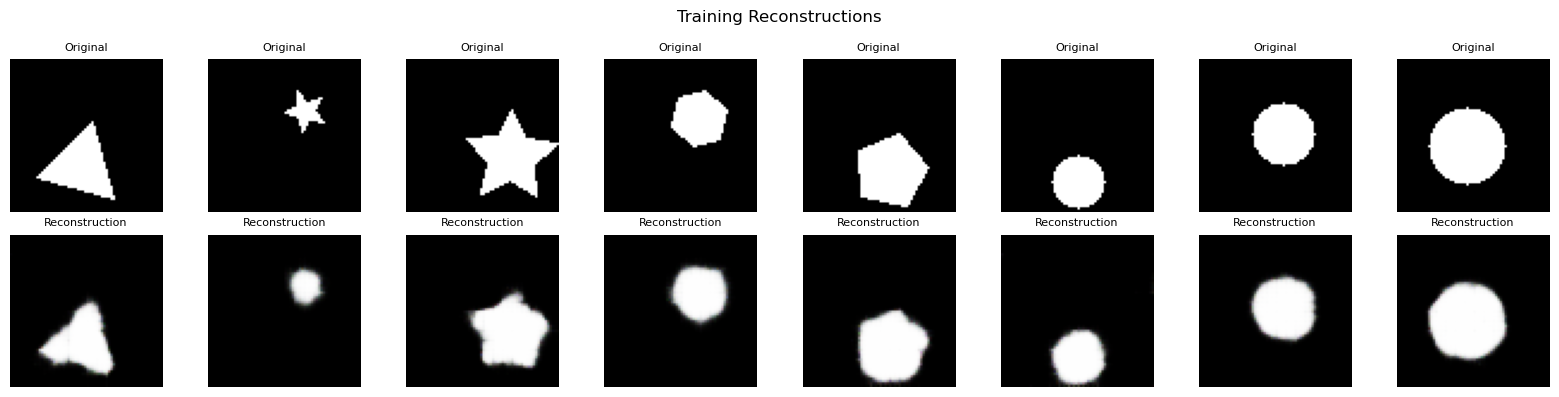

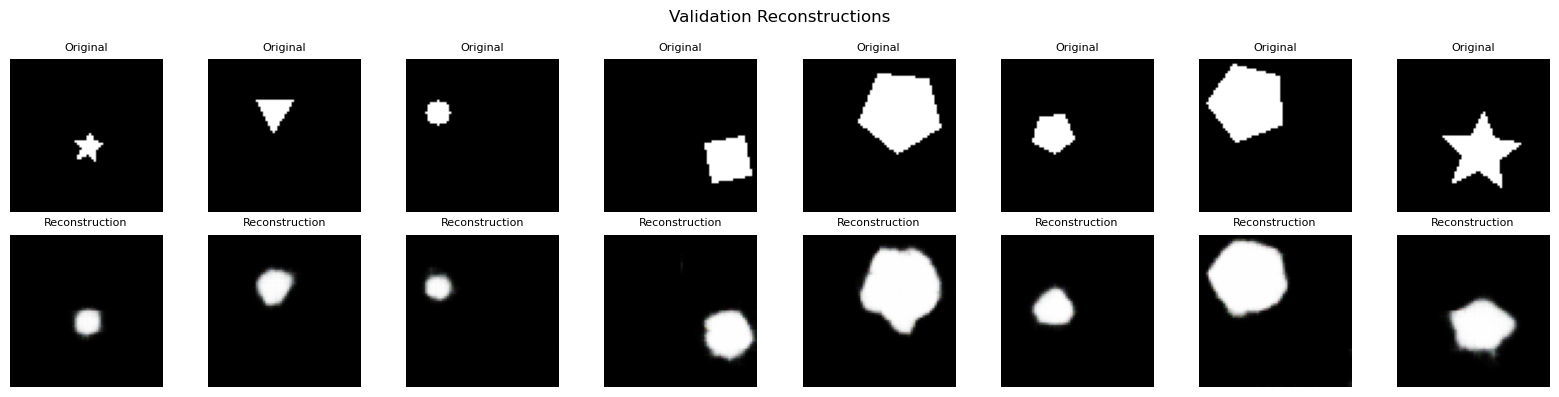

Epoch 9 Training: 100%|██████████| 48/48 [00:04<00:00, 10.63it/s, Beta=1e-10, ReconLoss=0.0069, KL_Loss=556.4941, BatchLoss=0.0069]


Epoch 9: Train Loss = 0.0088, Val Loss = 0.0110


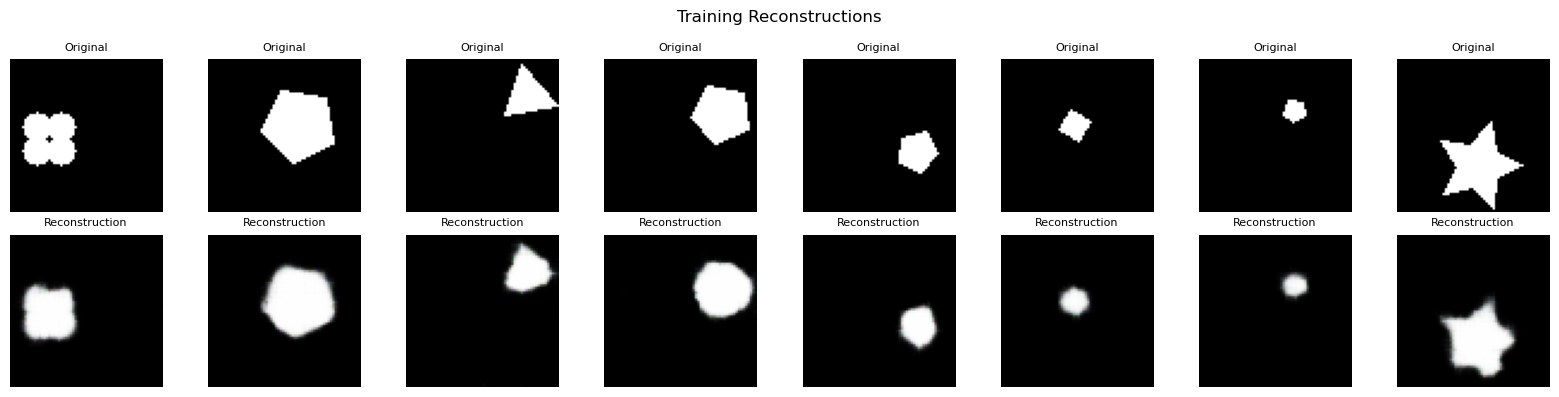

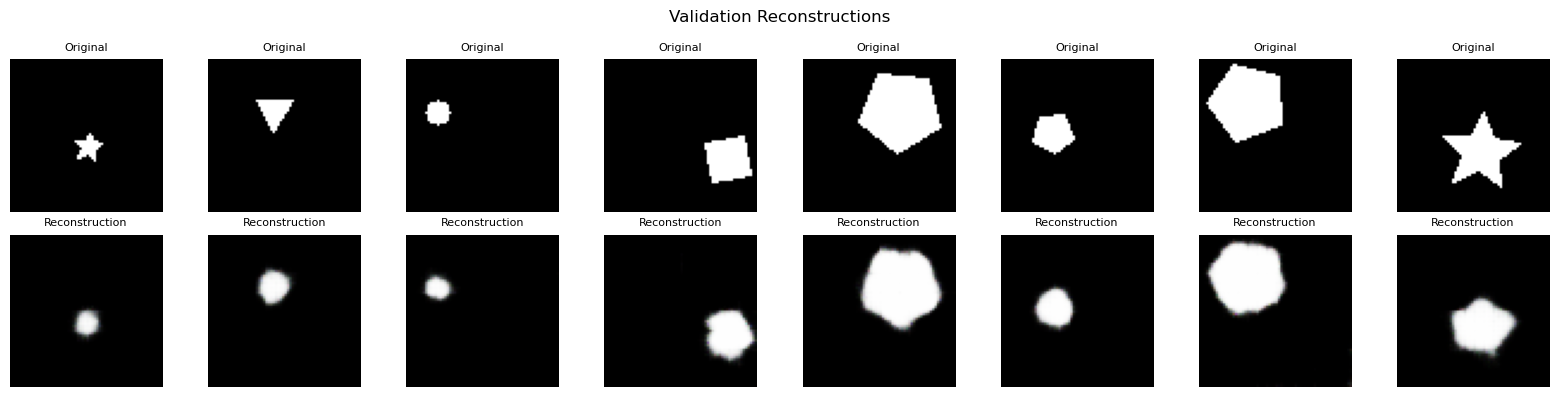

Epoch 10 Training: 100%|██████████| 48/48 [00:04<00:00, 10.41it/s, Beta=1e-10, ReconLoss=0.0079, KL_Loss=659.5789, BatchLoss=0.0079]


Epoch 10: Train Loss = 0.0085, Val Loss = 0.0108


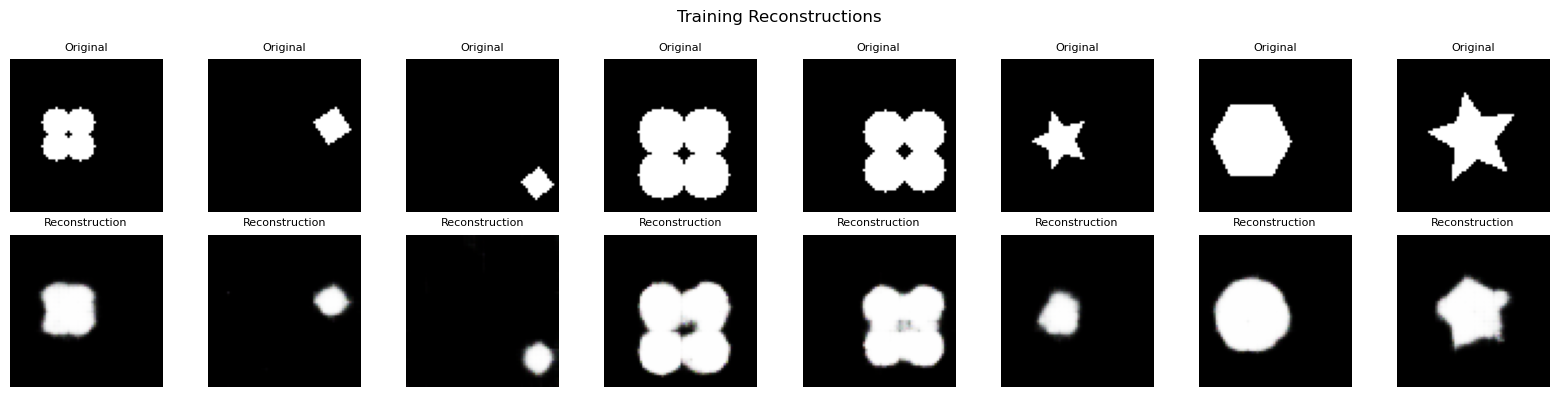

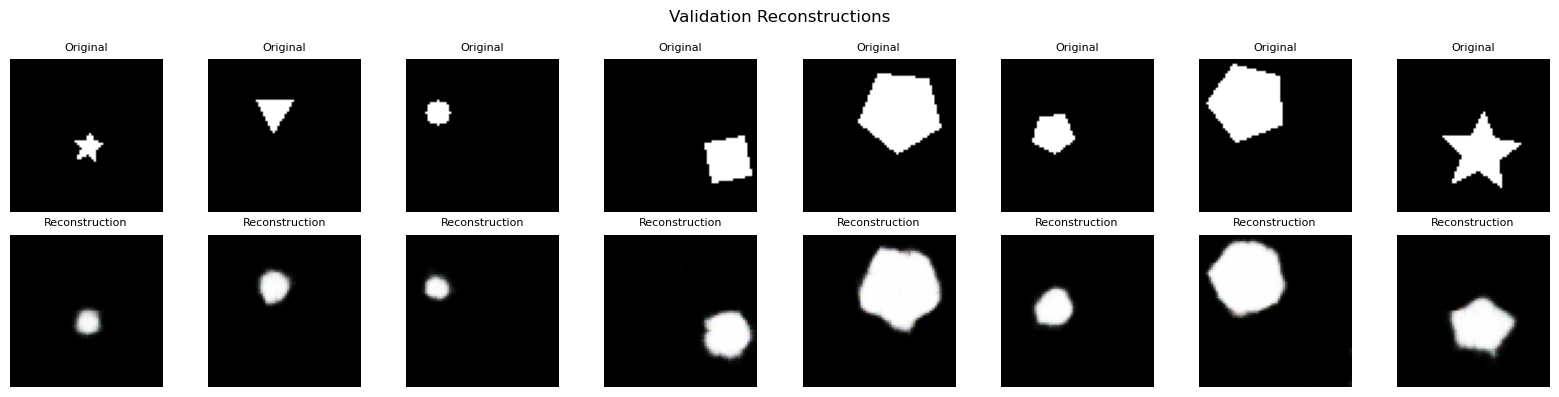

Epoch 11 Training: 100%|██████████| 48/48 [00:04<00:00, 10.72it/s, Beta=1e-10, ReconLoss=0.0103, KL_Loss=460.7542, BatchLoss=0.0103]


Epoch 11: Train Loss = 0.0083, Val Loss = 0.0111


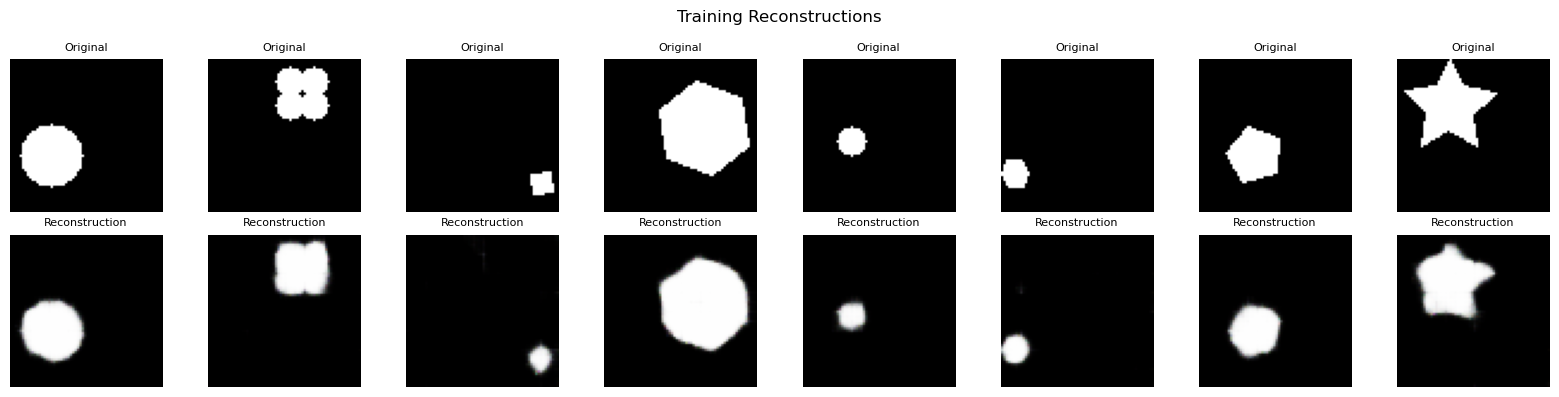

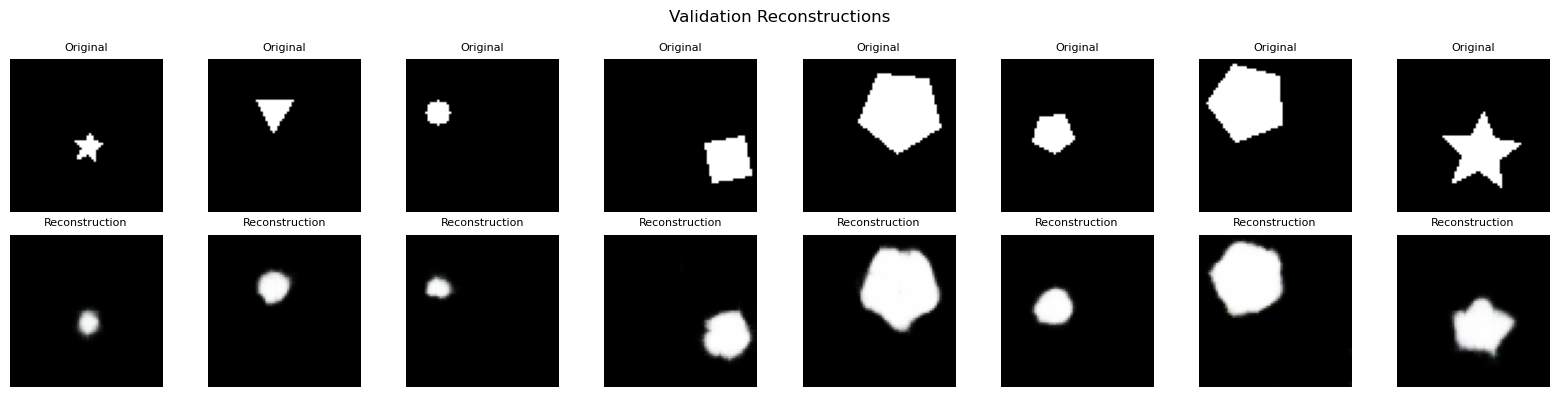

Epoch 12 Training: 100%|██████████| 48/48 [00:04<00:00, 10.21it/s, Beta=1e-10, ReconLoss=0.0098, KL_Loss=607.0316, BatchLoss=0.0098]


Epoch 12: Train Loss = 0.0084, Val Loss = 0.0113


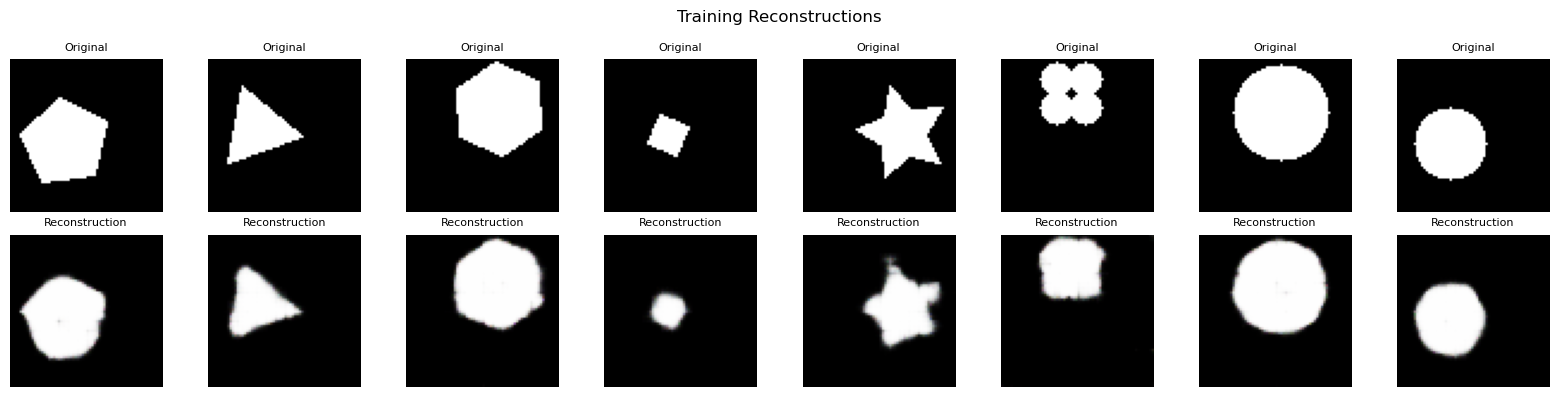

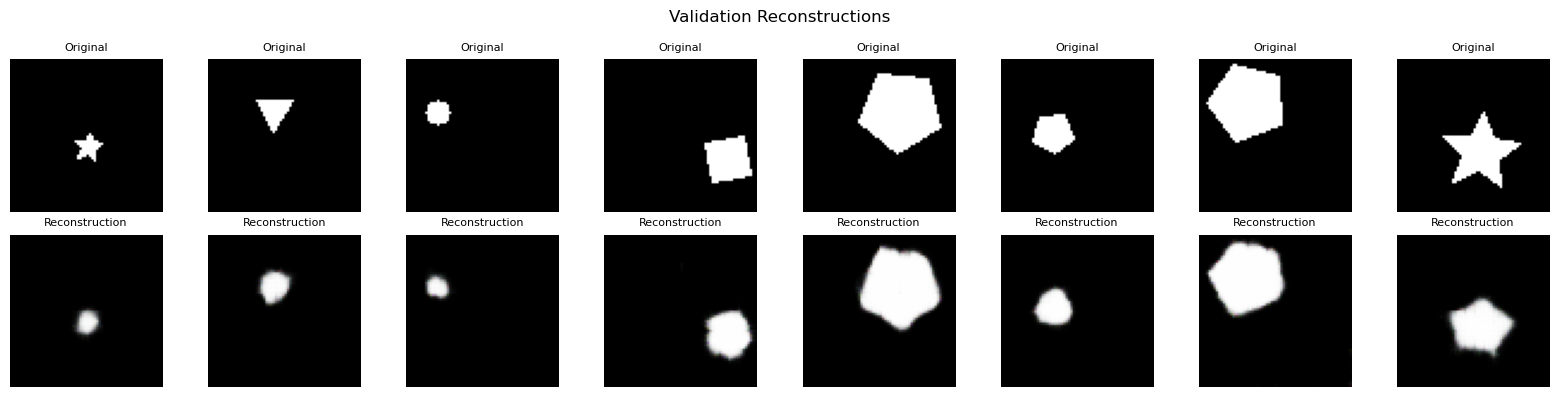

Epoch 13 Training: 100%|██████████| 48/48 [00:04<00:00, 10.36it/s, Beta=1e-10, ReconLoss=0.0079, KL_Loss=598.4719, BatchLoss=0.0079]


Epoch 13: Train Loss = 0.0085, Val Loss = 0.0107


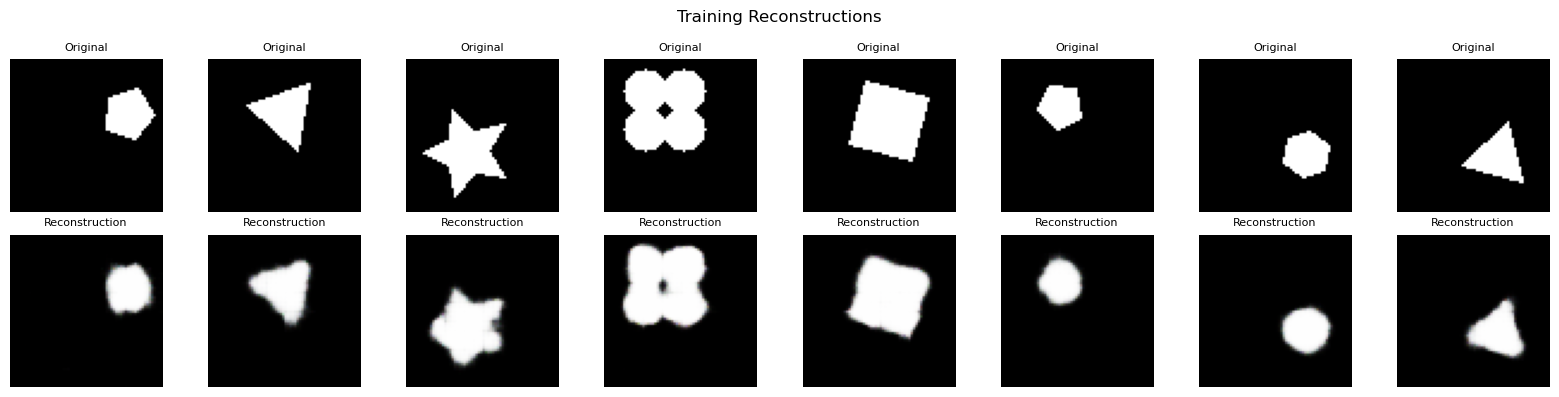

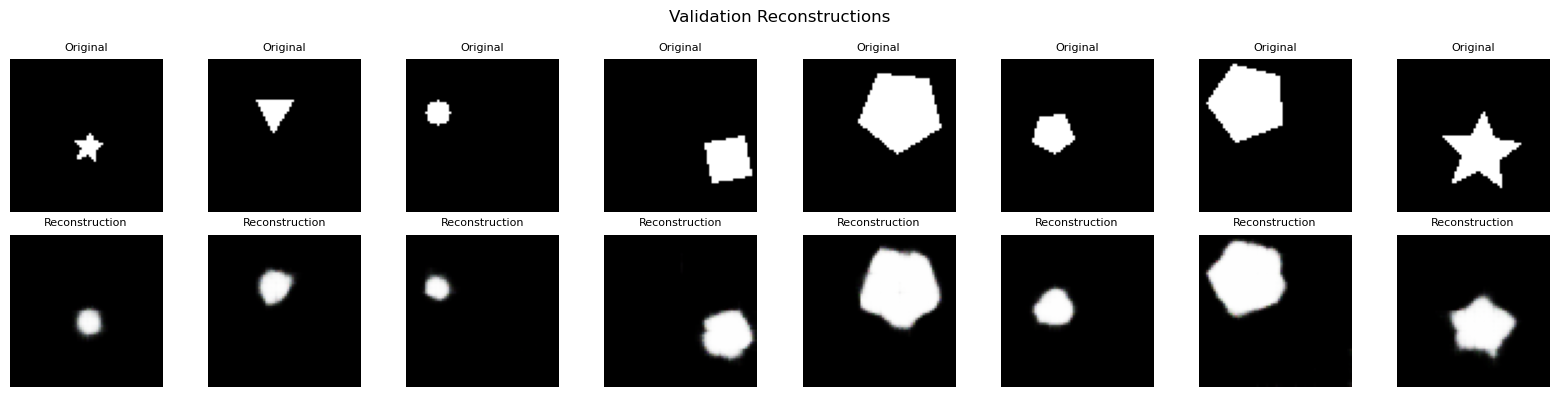

Epoch 14 Training: 100%|██████████| 48/48 [00:04<00:00, 10.17it/s, Beta=1e-10, ReconLoss=0.0085, KL_Loss=473.8316, BatchLoss=0.0085]


Epoch 14: Train Loss = 0.0079, Val Loss = 0.0106


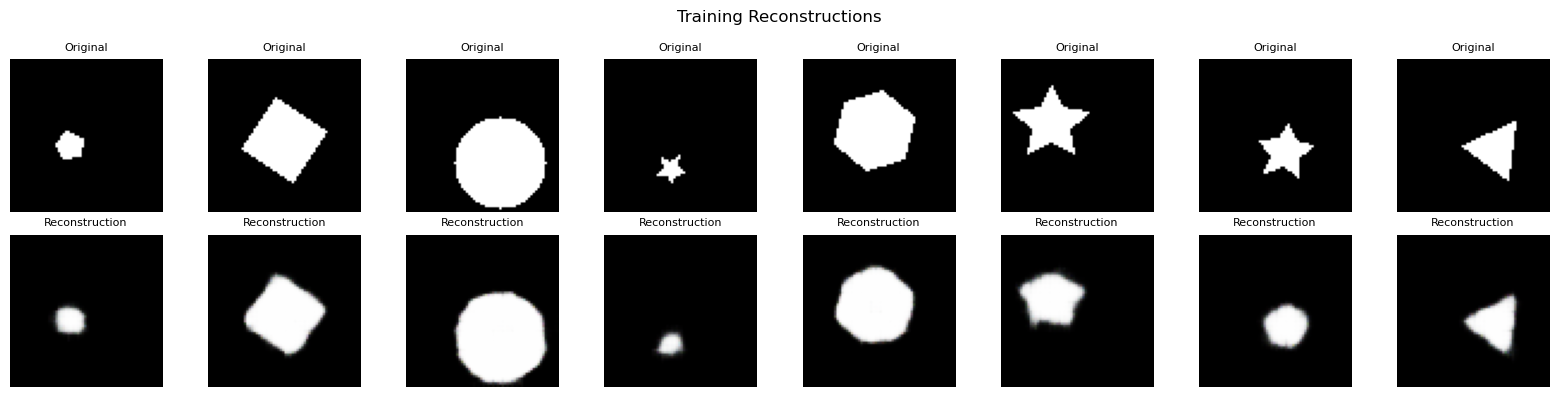

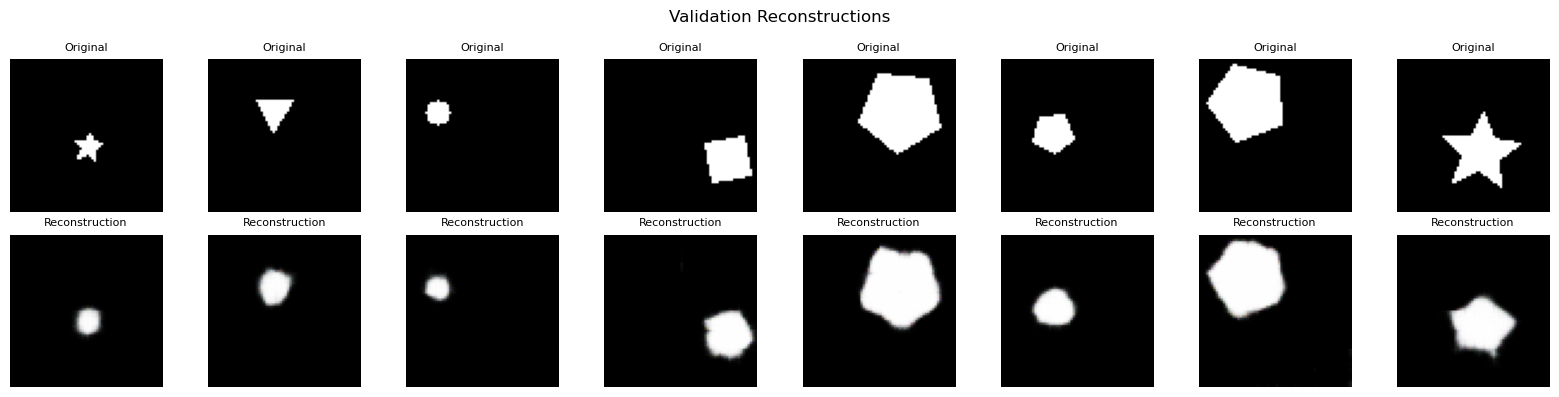

Epoch 15 Training: 100%|██████████| 48/48 [00:04<00:00, 10.10it/s, Beta=1e-10, ReconLoss=0.0064, KL_Loss=438.5231, BatchLoss=0.0064]


Epoch 15: Train Loss = 0.0078, Val Loss = 0.0107


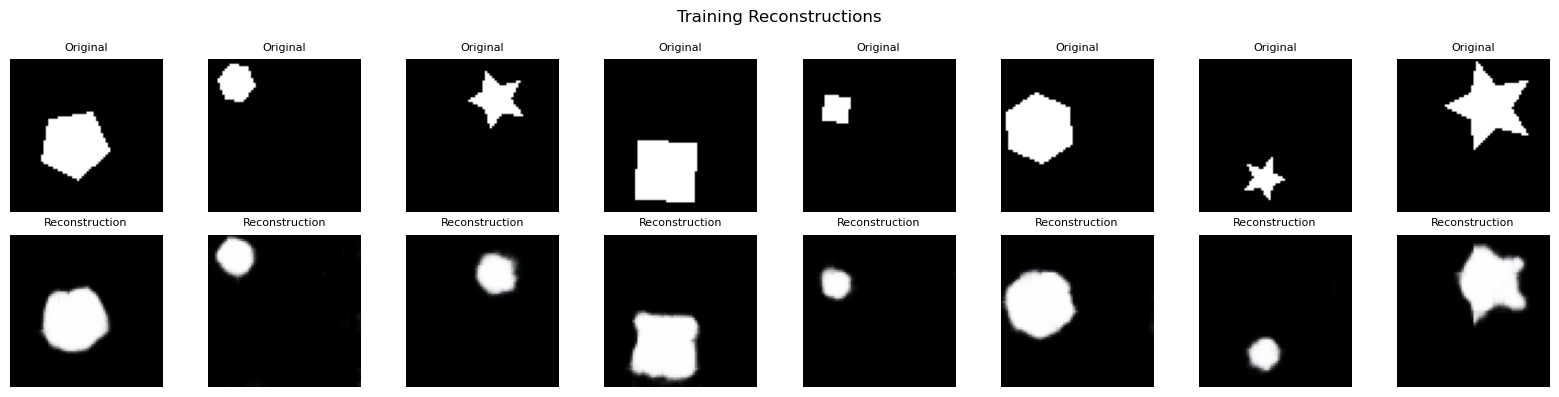

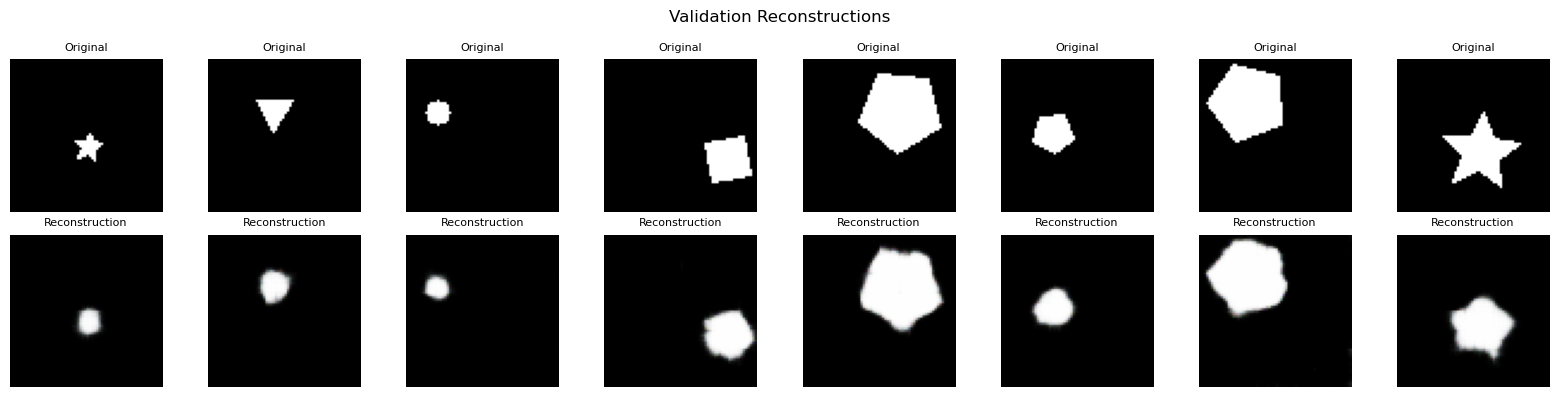

Epoch 16 Training: 100%|██████████| 48/48 [00:04<00:00,  9.81it/s, Beta=1e-10, ReconLoss=0.0096, KL_Loss=535.4103, BatchLoss=0.0096]


Epoch 16: Train Loss = 0.0078, Val Loss = 0.0107


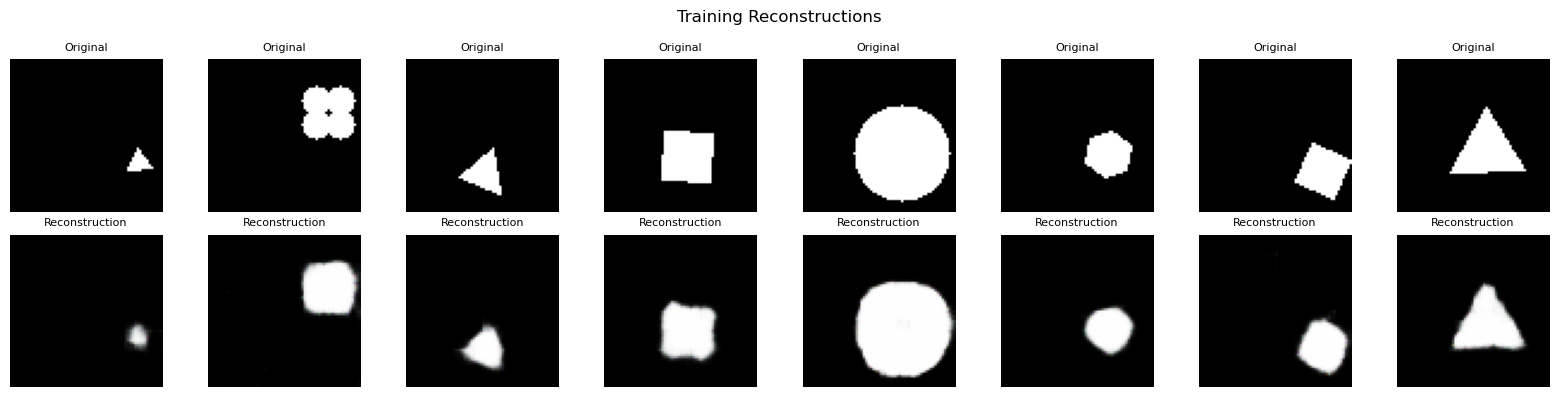

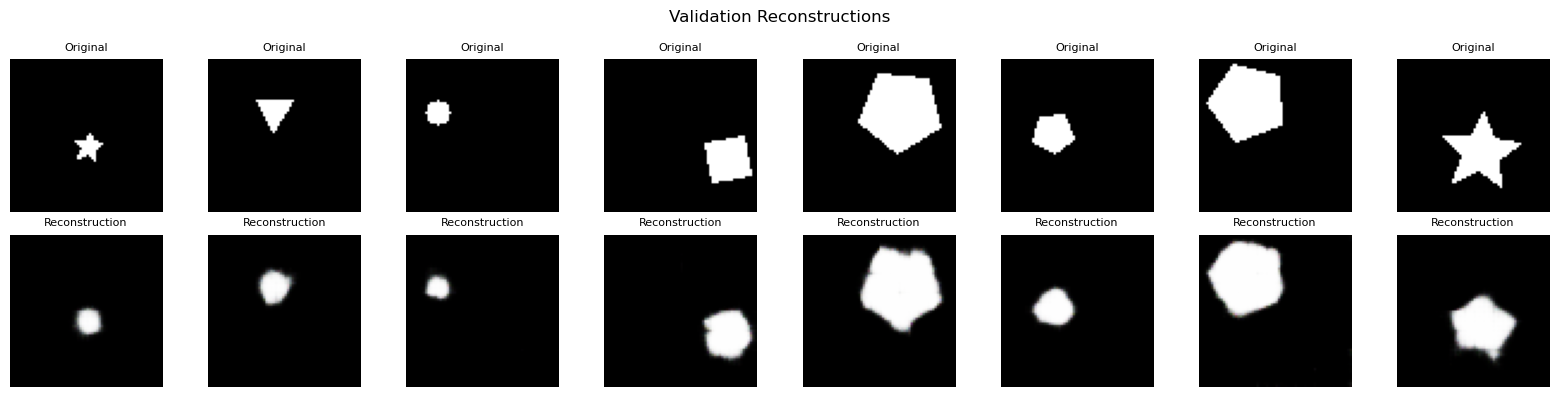

Epoch 17 Training: 100%|██████████| 48/48 [00:04<00:00, 10.04it/s, Beta=1e-10, ReconLoss=0.0098, KL_Loss=492.1069, BatchLoss=0.0098]


Epoch 17: Train Loss = 0.0078, Val Loss = 0.0104


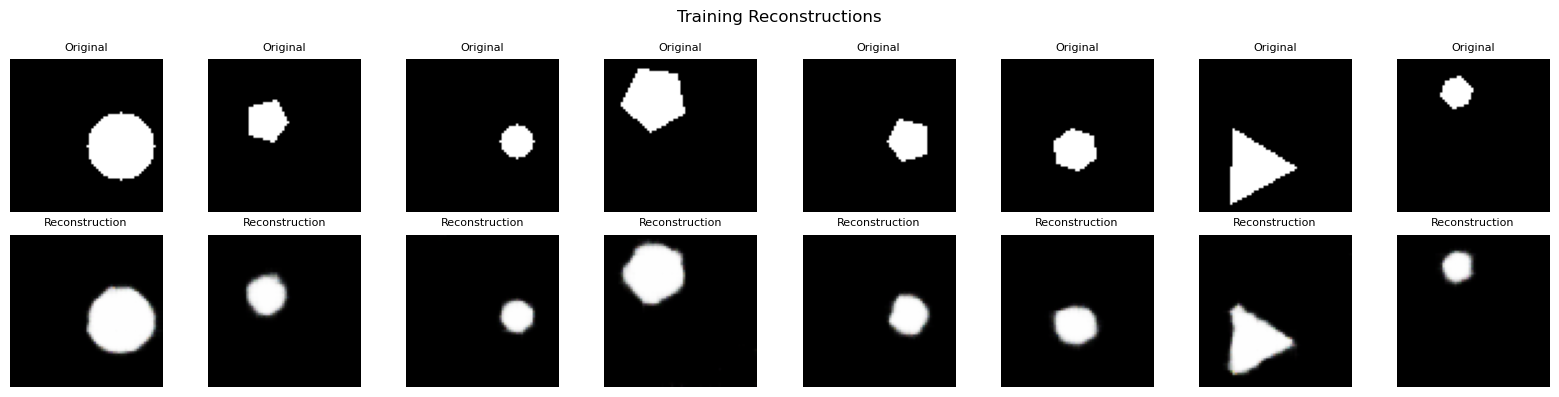

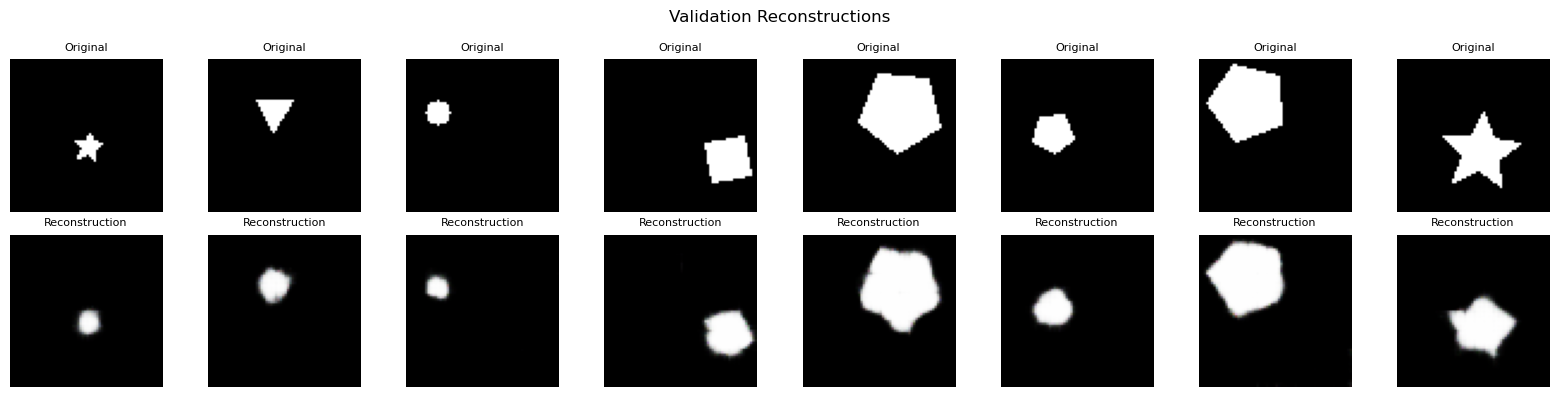

Epoch 18 Training: 100%|██████████| 48/48 [00:04<00:00, 10.58it/s, Beta=1e-10, ReconLoss=0.0090, KL_Loss=455.4988, BatchLoss=0.0090]


Epoch 18: Train Loss = 0.0078, Val Loss = 0.0106


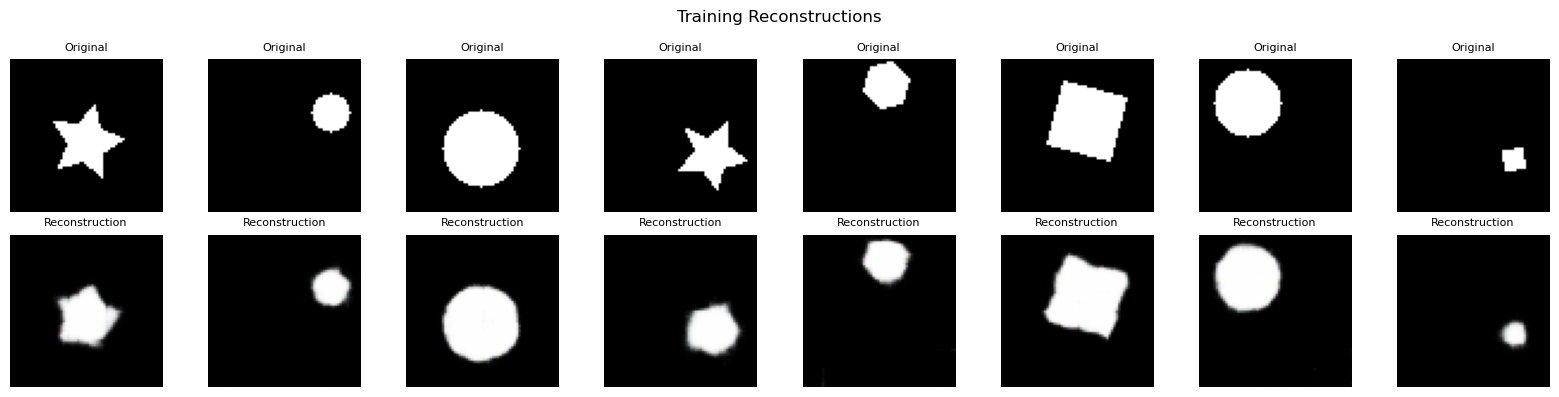

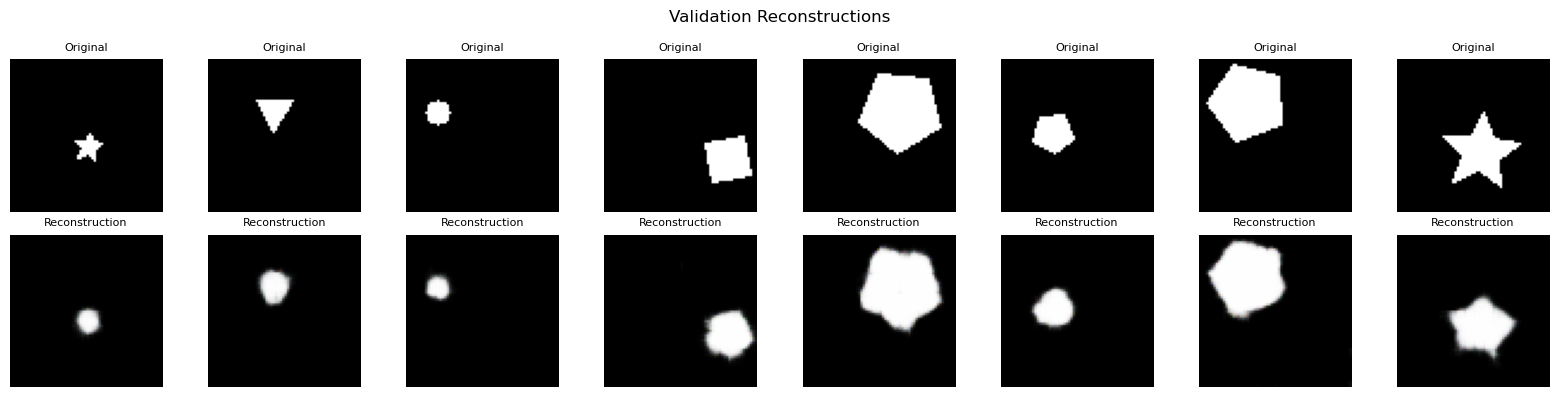

Epoch 19 Training: 100%|██████████| 48/48 [00:04<00:00, 10.33it/s, Beta=1e-10, ReconLoss=0.0058, KL_Loss=442.3889, BatchLoss=0.0058]


Epoch 19: Train Loss = 0.0076, Val Loss = 0.0104


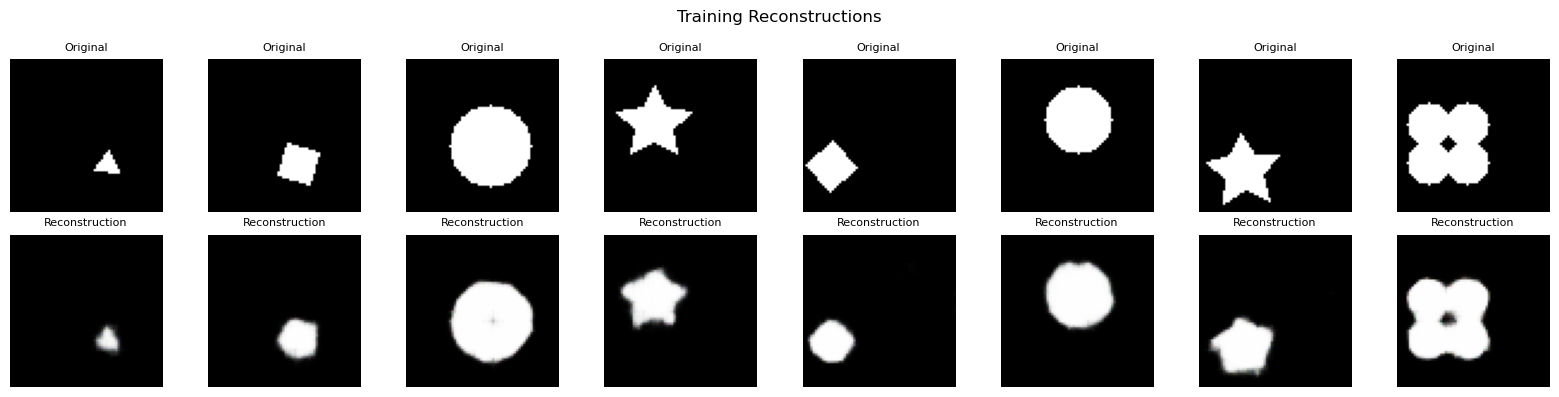

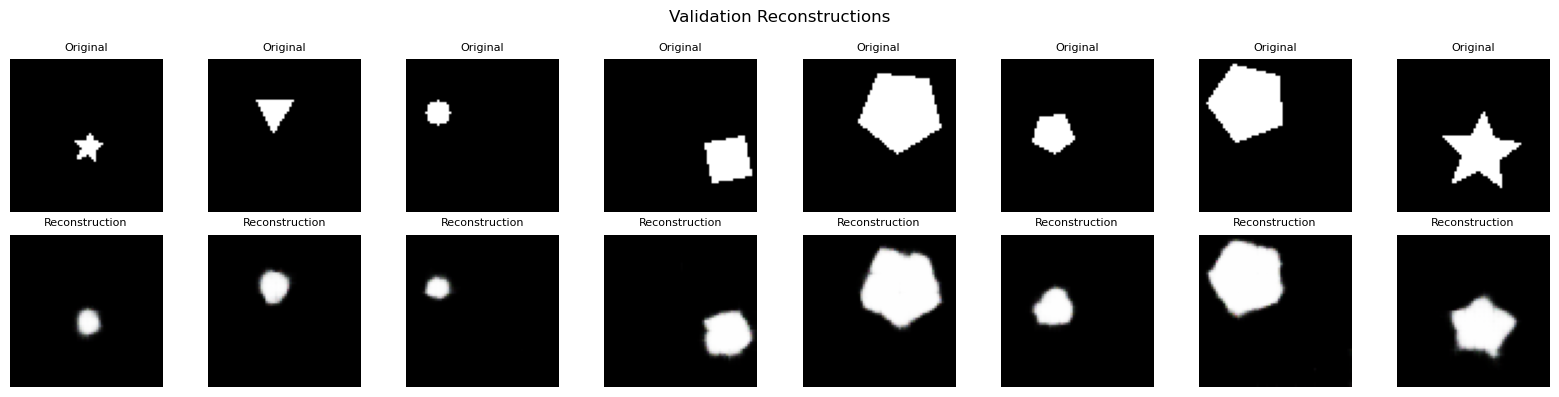

Epoch 20 Training: 100%|██████████| 48/48 [00:04<00:00, 10.39it/s, Beta=1e-10, ReconLoss=0.0080, KL_Loss=501.2878, BatchLoss=0.0080]


Epoch 20: Train Loss = 0.0075, Val Loss = 0.0102


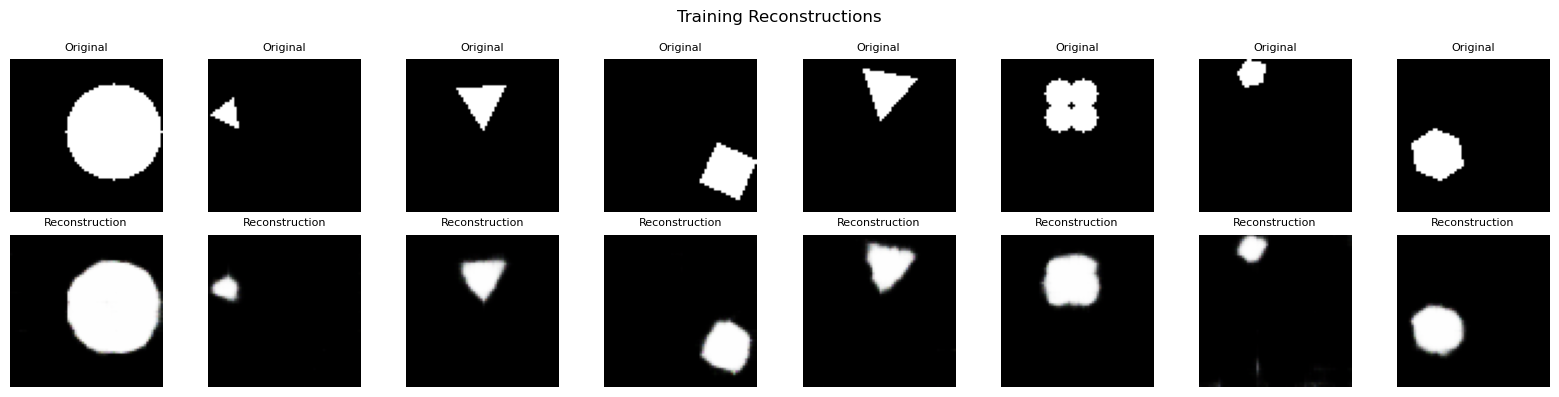

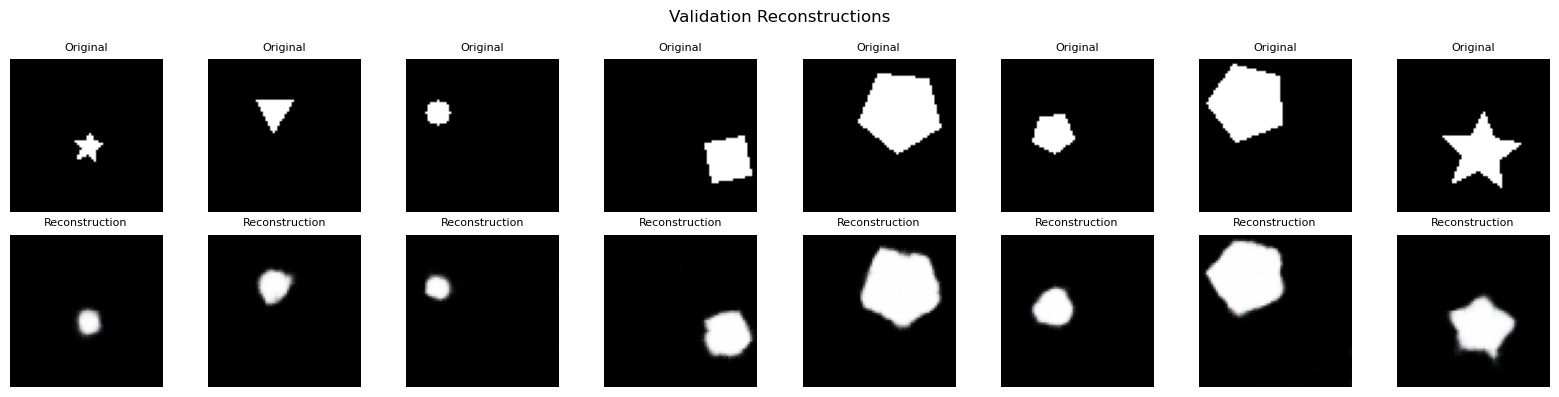

Epoch 21 Training: 100%|██████████| 48/48 [00:04<00:00, 10.38it/s, Beta=1e-10, ReconLoss=0.0088, KL_Loss=553.0057, BatchLoss=0.0088]


Epoch 21: Train Loss = 0.0073, Val Loss = 0.0102


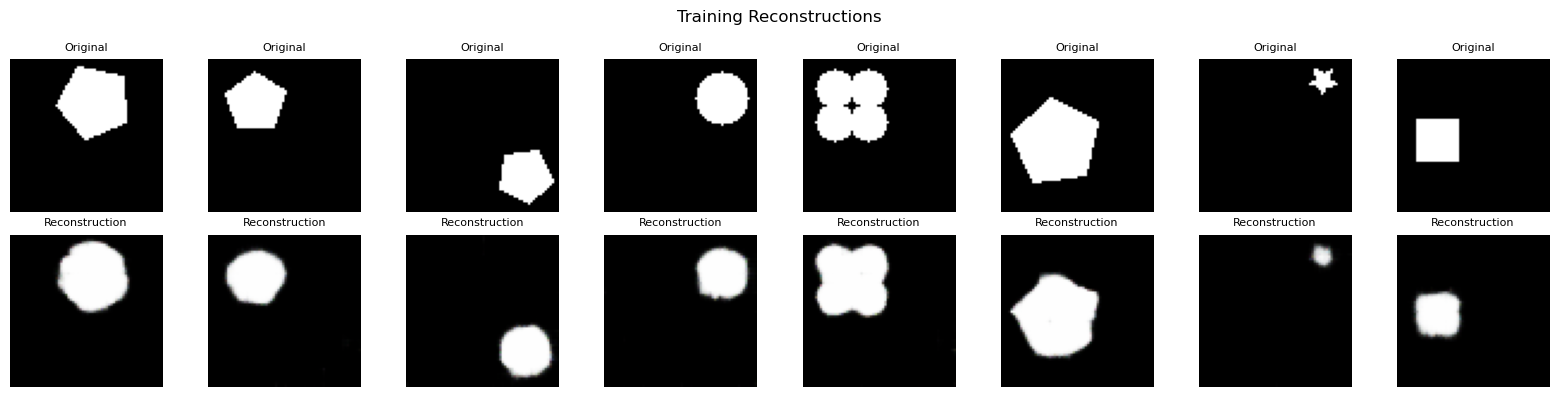

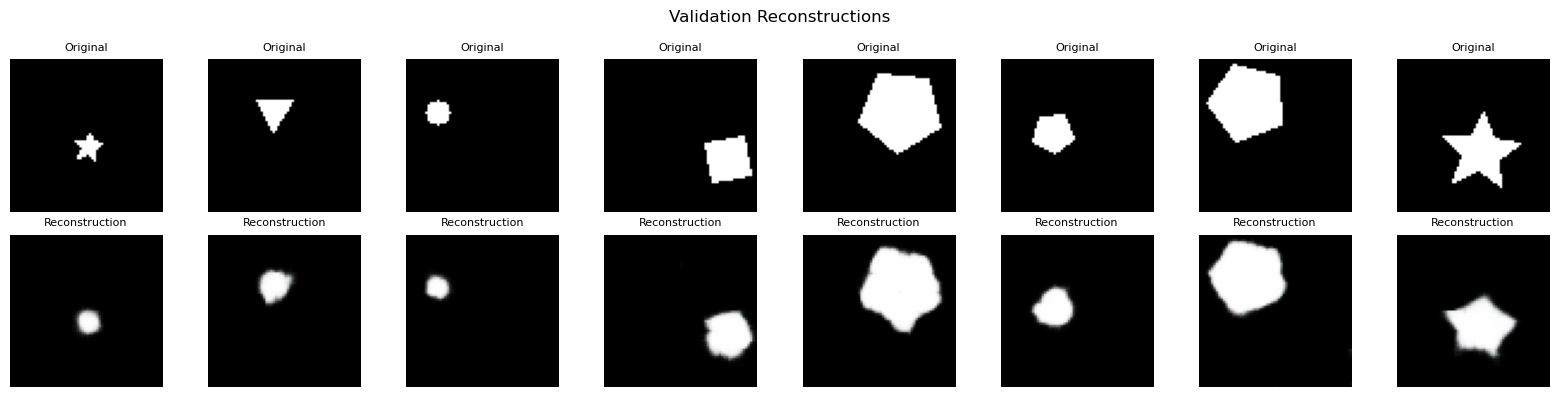

Epoch 22 Training: 100%|██████████| 48/48 [00:04<00:00, 10.45it/s, Beta=1e-10, ReconLoss=0.0064, KL_Loss=404.0908, BatchLoss=0.0064]


Epoch 22: Train Loss = 0.0072, Val Loss = 0.0103


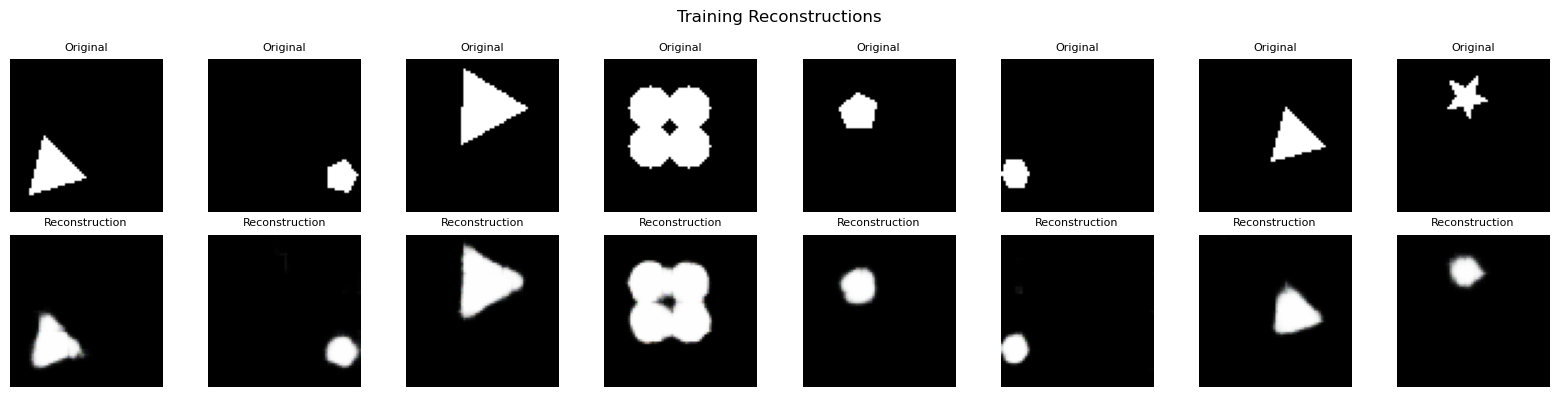

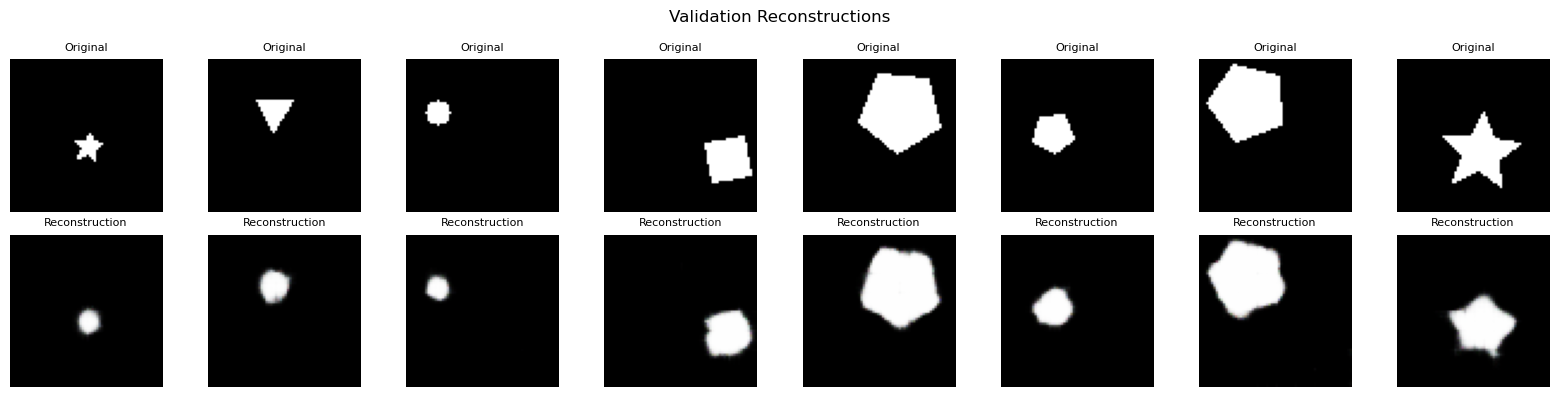

Epoch 23 Training: 100%|██████████| 48/48 [00:04<00:00, 10.54it/s, Beta=1e-10, ReconLoss=0.0098, KL_Loss=443.7908, BatchLoss=0.0098]


Epoch 23: Train Loss = 0.0071, Val Loss = 0.0105


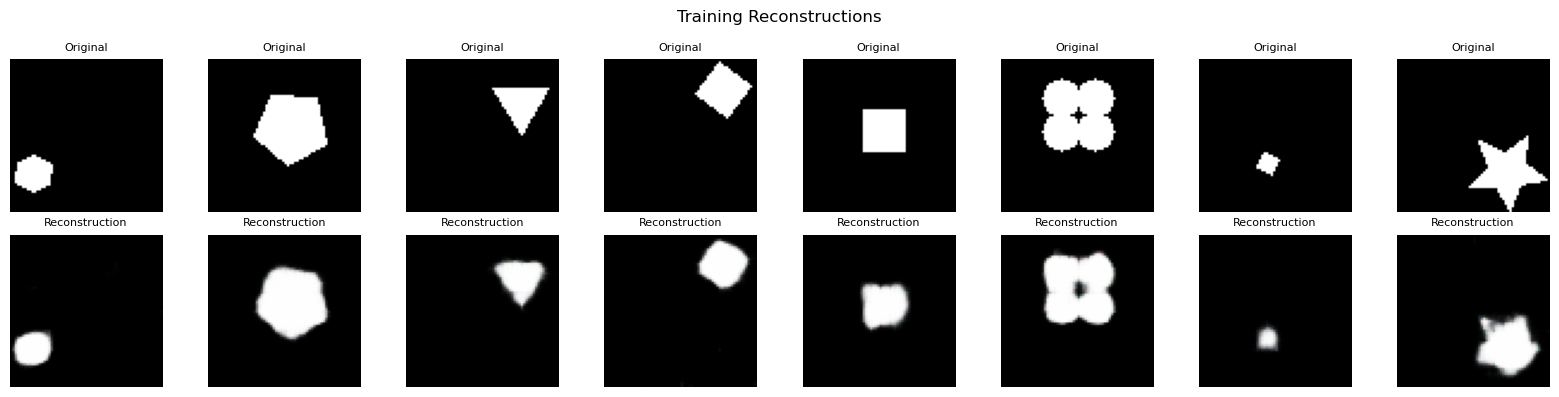

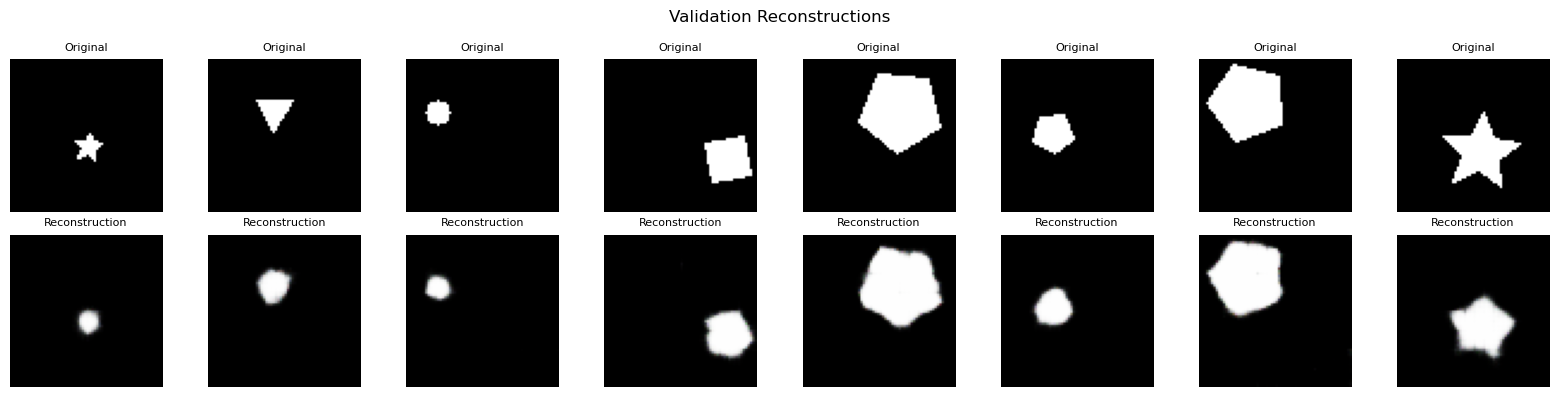

Epoch 24 Training: 100%|██████████| 48/48 [00:04<00:00, 10.32it/s, Beta=1e-10, ReconLoss=0.0061, KL_Loss=433.9853, BatchLoss=0.0061]


Epoch 24: Train Loss = 0.0069, Val Loss = 0.0100


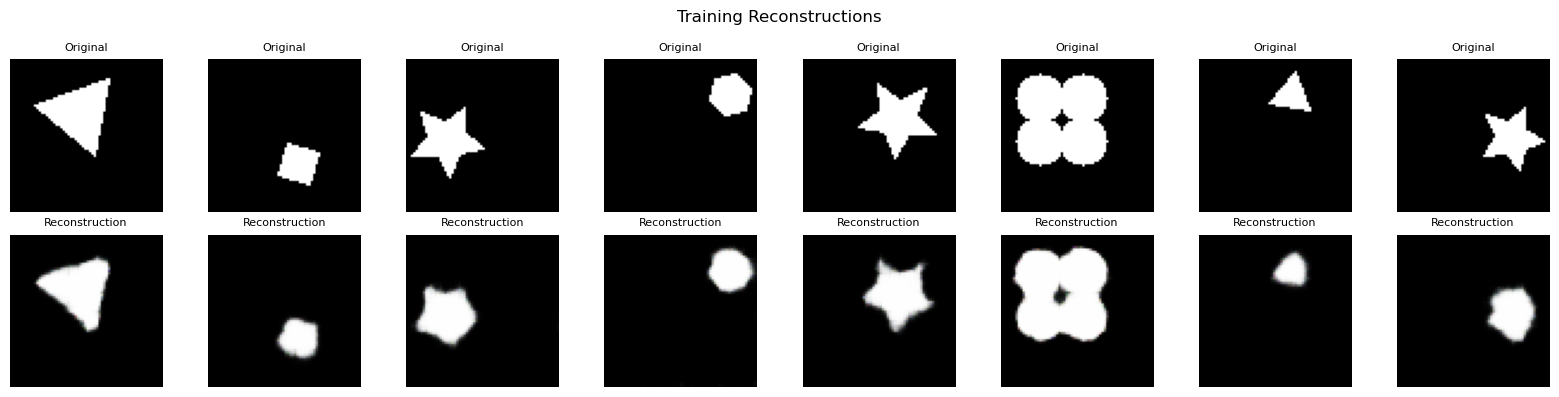

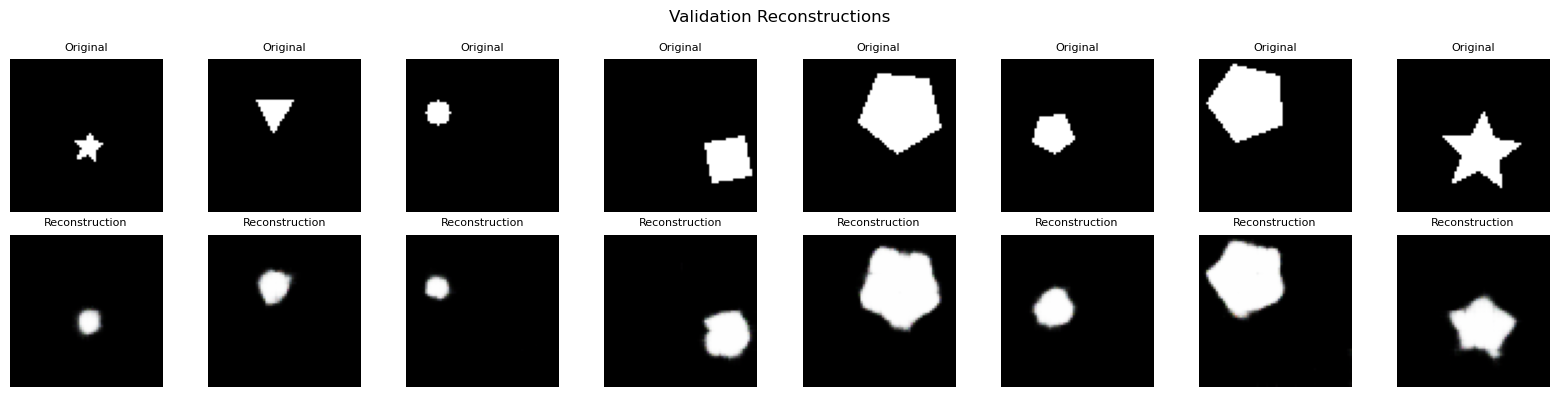

Epoch 25 Training: 100%|██████████| 48/48 [00:04<00:00, 10.50it/s, Beta=1e-10, ReconLoss=0.0086, KL_Loss=673.6037, BatchLoss=0.0086]


Epoch 25: Train Loss = 0.0069, Val Loss = 0.0102


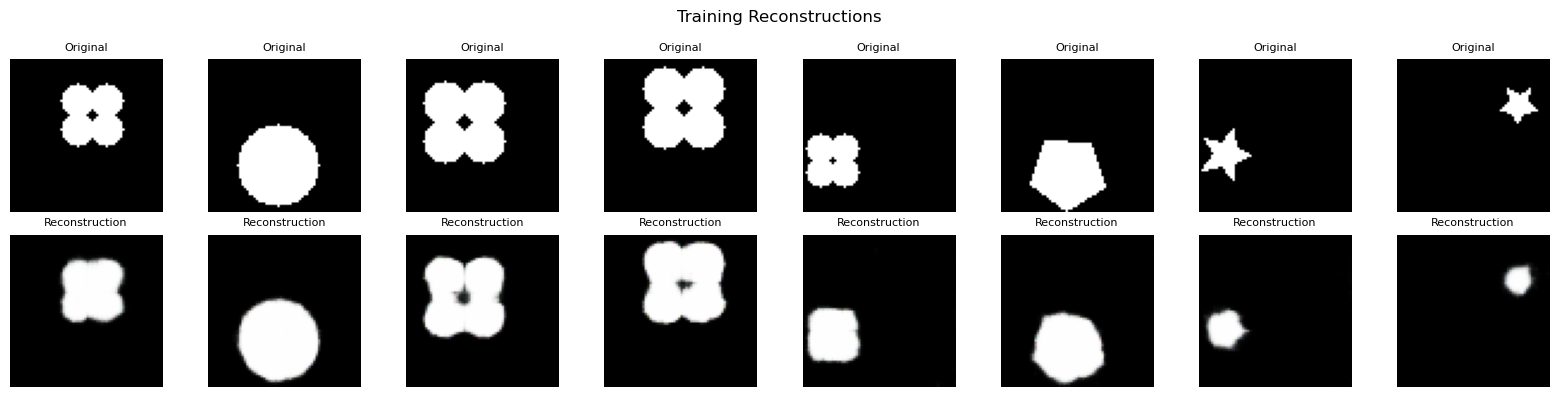

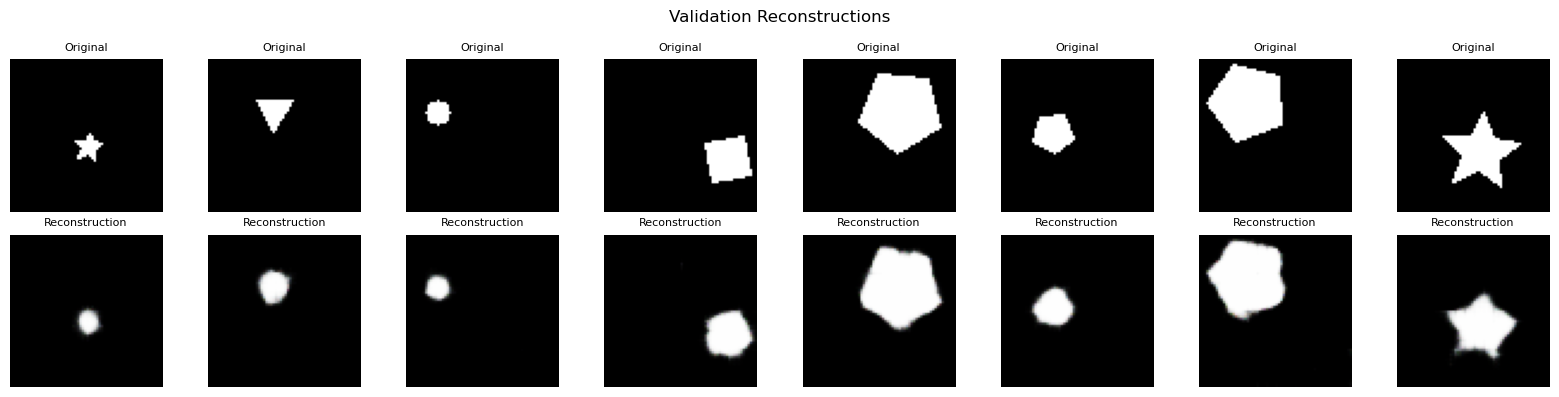

Epoch 26 Training: 100%|██████████| 48/48 [00:04<00:00, 10.65it/s, Beta=1e-10, ReconLoss=0.0081, KL_Loss=442.1496, BatchLoss=0.0081]


Epoch 26: Train Loss = 0.0074, Val Loss = 0.0104


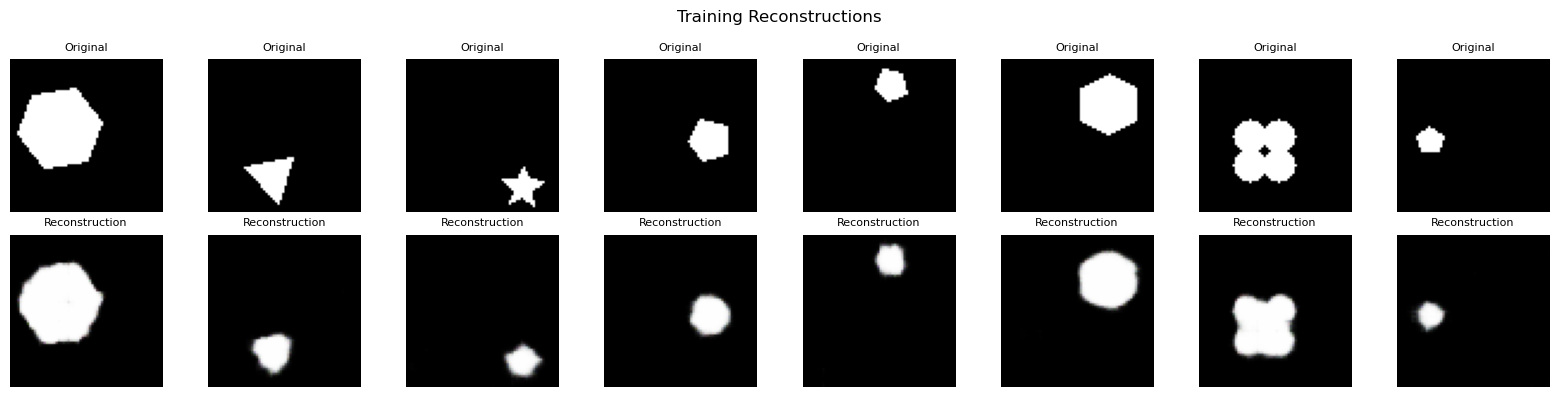

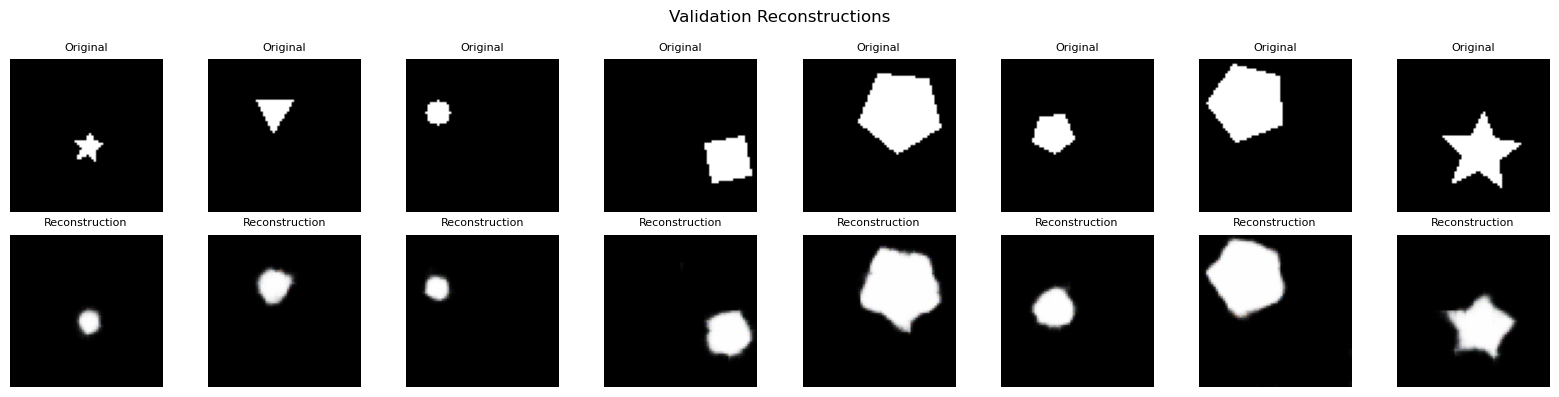

Epoch 27 Training: 100%|██████████| 48/48 [00:04<00:00, 10.37it/s, Beta=1e-10, ReconLoss=0.0063, KL_Loss=472.8055, BatchLoss=0.0063]


Epoch 27: Train Loss = 0.0070, Val Loss = 0.0100


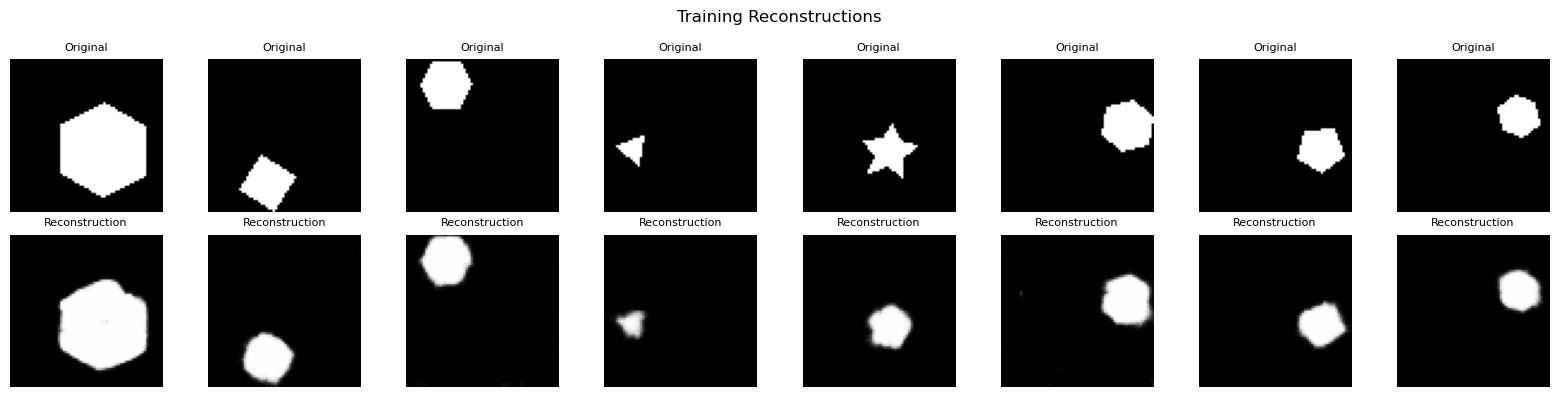

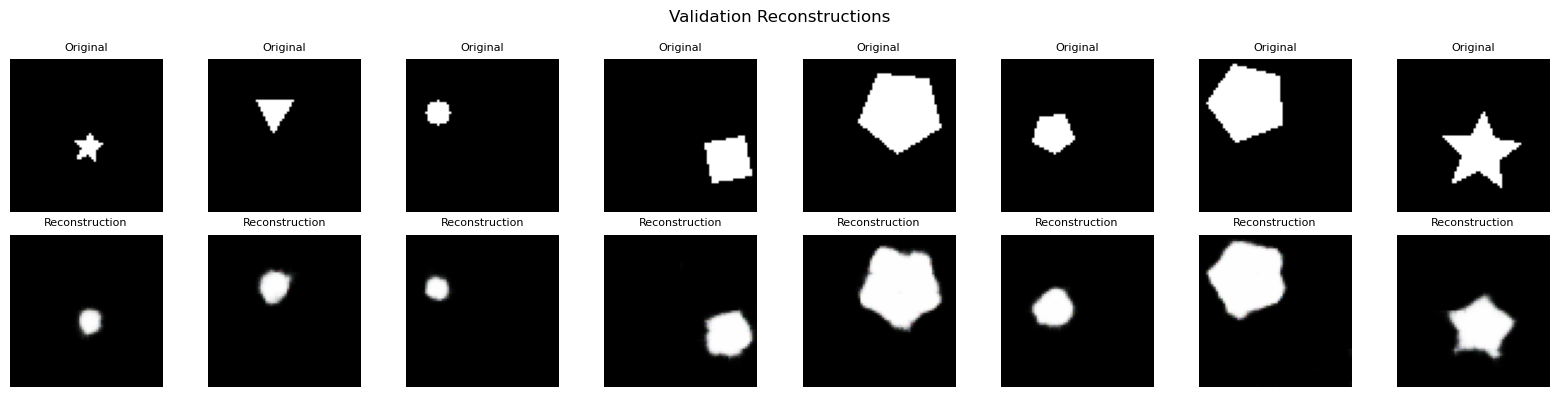

Epoch 28 Training: 100%|██████████| 48/48 [00:04<00:00, 10.50it/s, Beta=1e-10, ReconLoss=0.0059, KL_Loss=422.6932, BatchLoss=0.0059]


Epoch 28: Train Loss = 0.0066, Val Loss = 0.0102


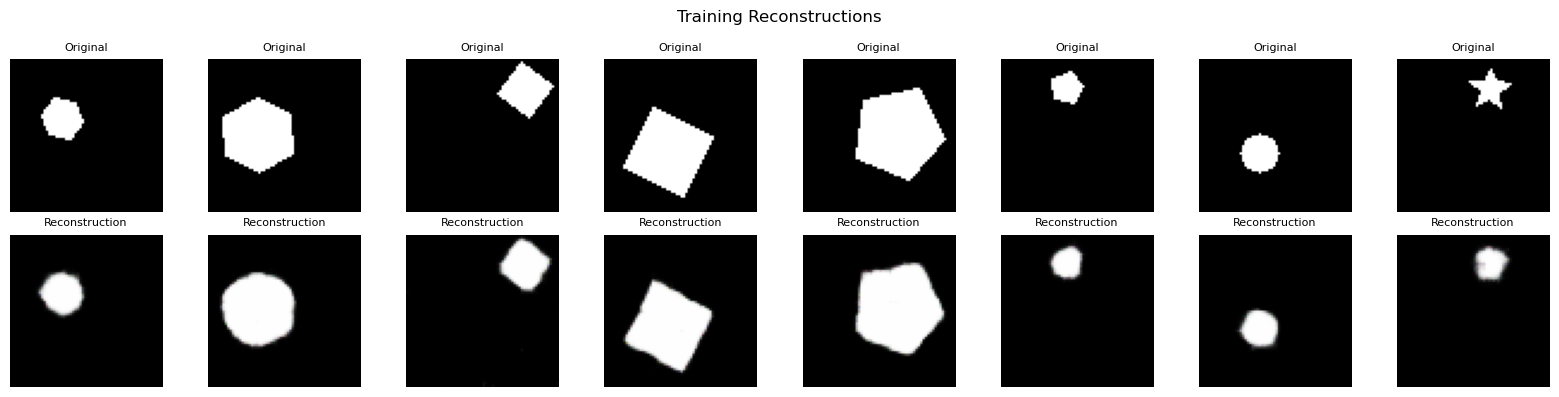

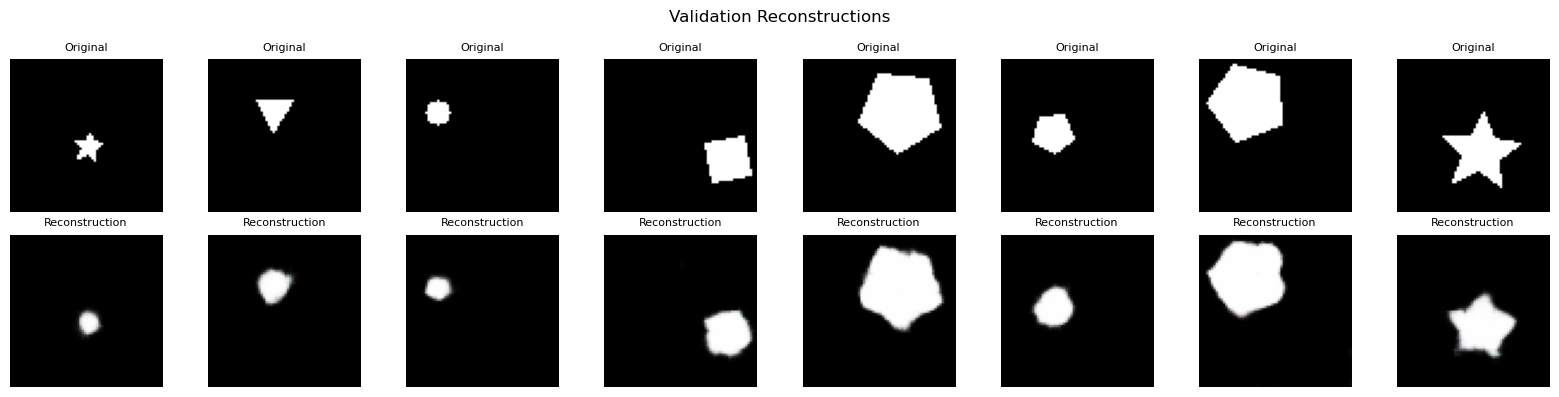

Epoch 29 Training: 100%|██████████| 48/48 [00:04<00:00, 10.43it/s, Beta=1e-10, ReconLoss=0.0061, KL_Loss=519.5941, BatchLoss=0.0061]


Epoch 29: Train Loss = 0.0068, Val Loss = 0.0098


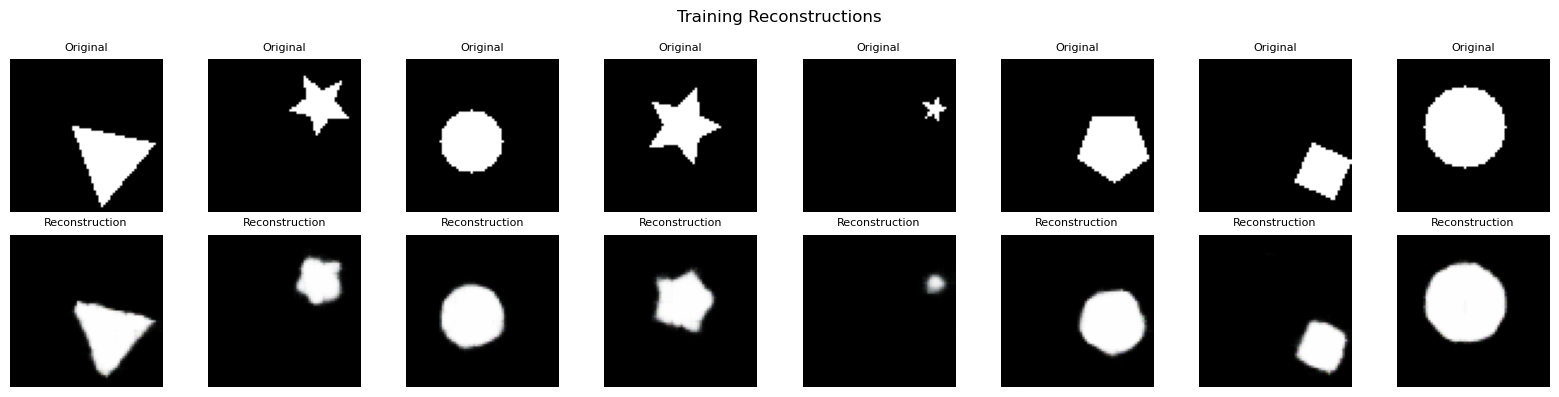

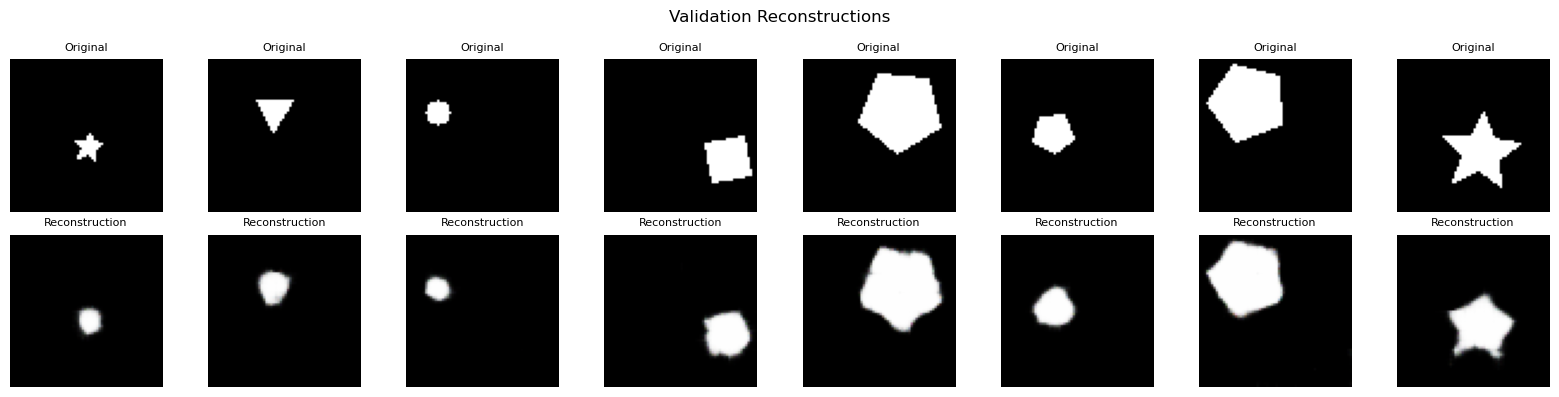

Epoch 30 Training: 100%|██████████| 48/48 [00:04<00:00, 10.48it/s, Beta=1e-10, ReconLoss=0.0079, KL_Loss=452.3693, BatchLoss=0.0079]


Epoch 30: Train Loss = 0.0067, Val Loss = 0.0100


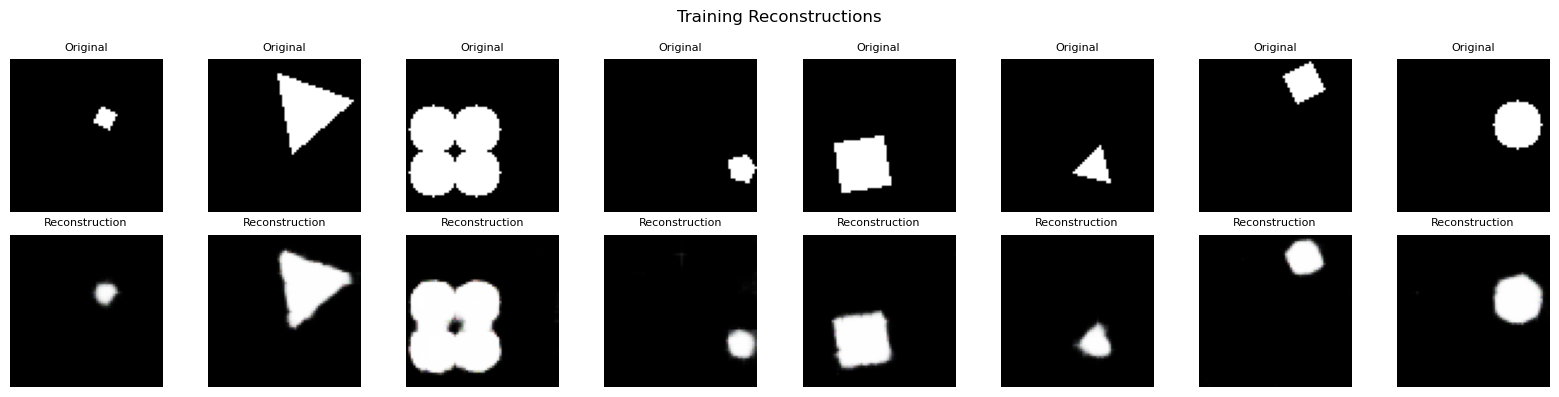

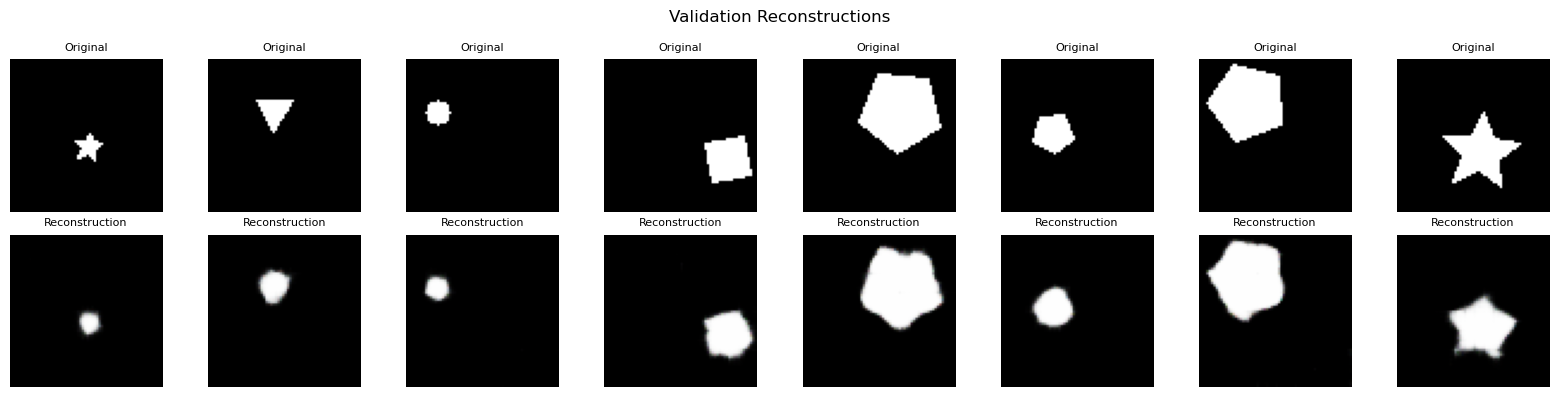

Epoch 31 Training: 100%|██████████| 48/48 [00:04<00:00, 10.48it/s, Beta=1e-10, ReconLoss=0.0060, KL_Loss=444.4800, BatchLoss=0.0060]


Epoch 31: Train Loss = 0.0066, Val Loss = 0.0101


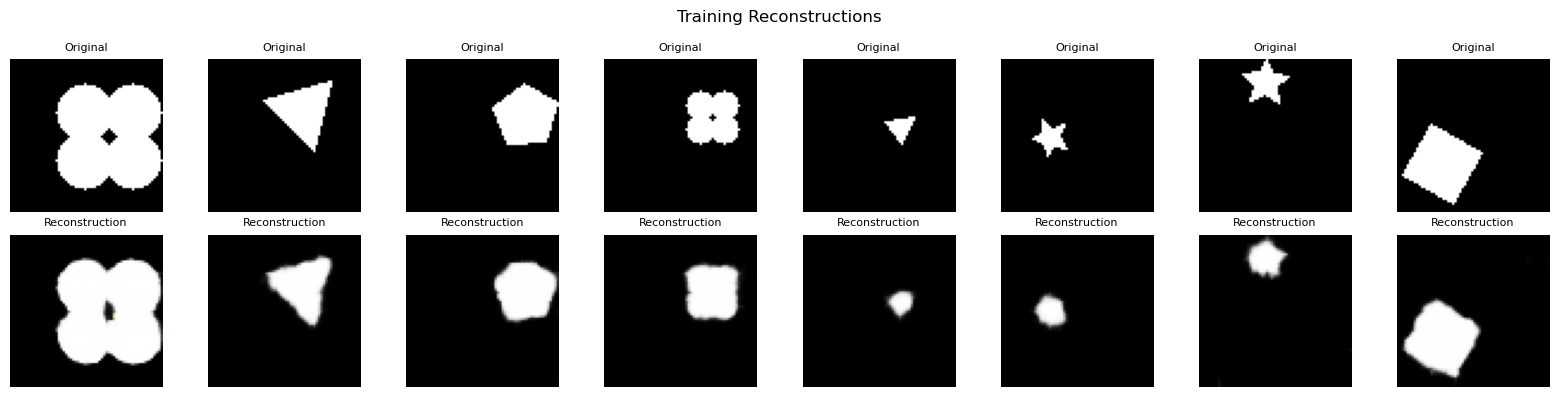

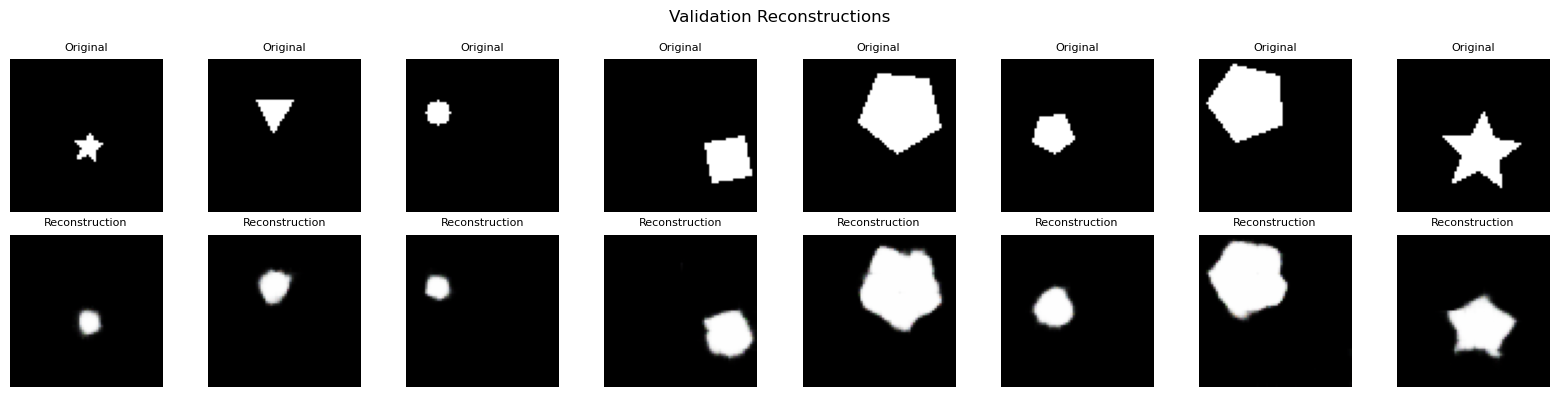

Epoch 32 Training: 100%|██████████| 48/48 [00:04<00:00, 10.31it/s, Beta=1e-10, ReconLoss=0.0066, KL_Loss=390.2038, BatchLoss=0.0066]


Epoch 32: Train Loss = 0.0065, Val Loss = 0.0101


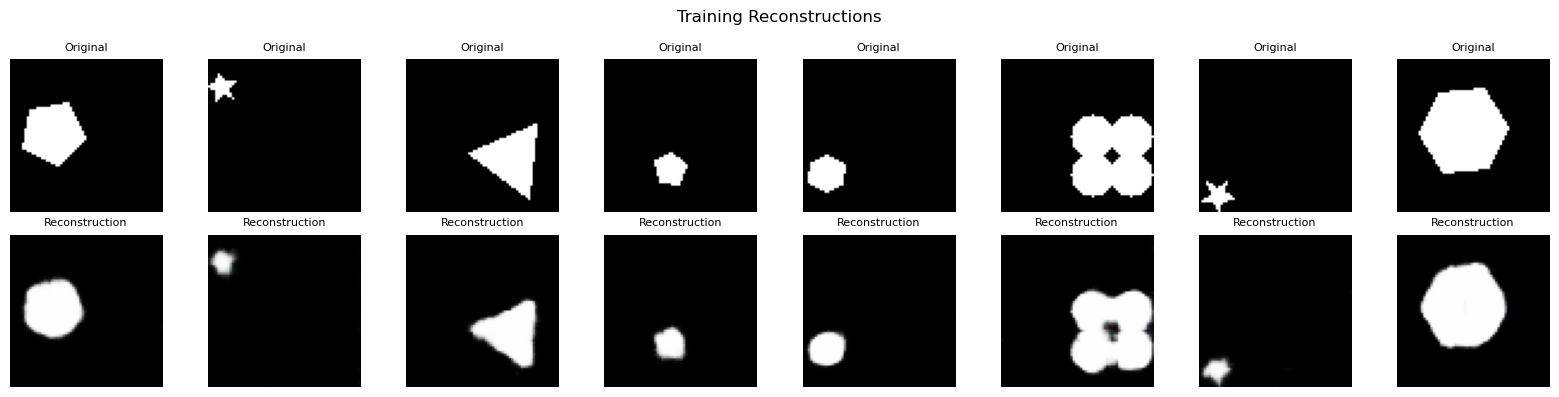

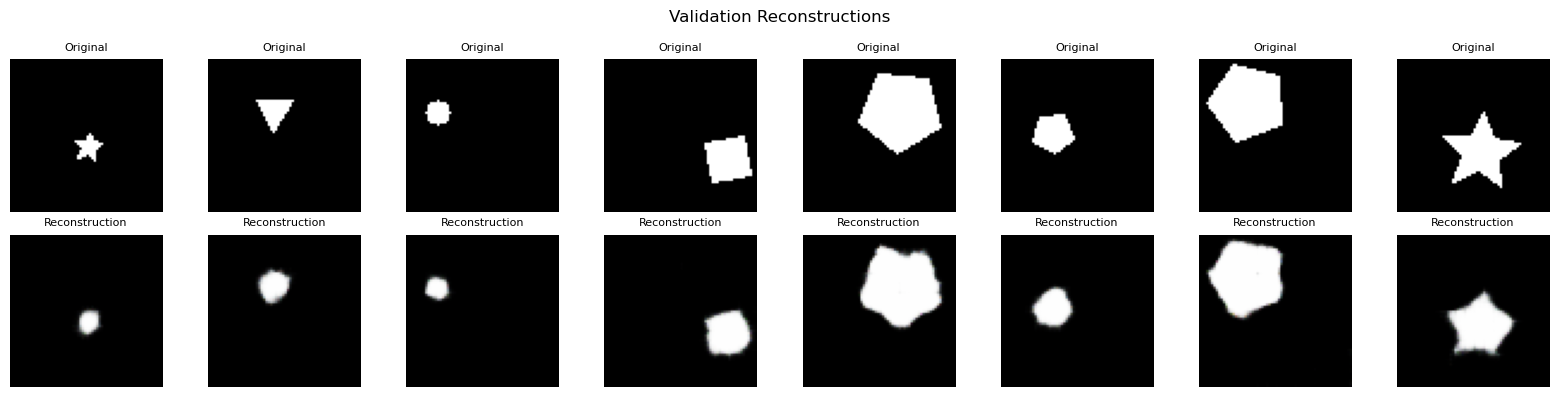

Epoch 33 Training: 100%|██████████| 48/48 [00:04<00:00, 10.32it/s, Beta=1e-10, ReconLoss=0.0070, KL_Loss=491.6479, BatchLoss=0.0070]


Epoch 33: Train Loss = 0.0062, Val Loss = 0.0098


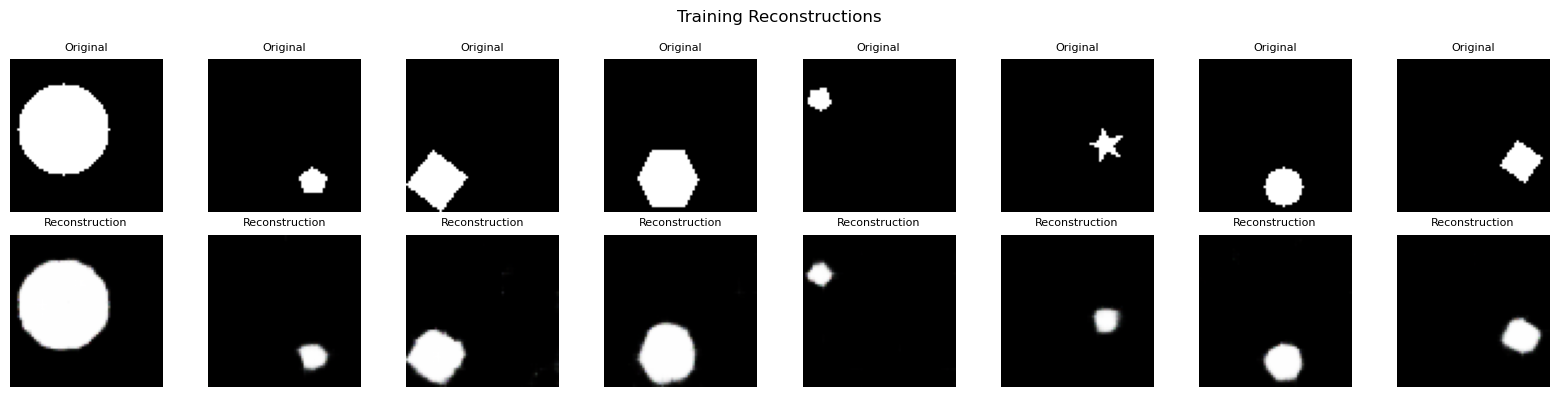

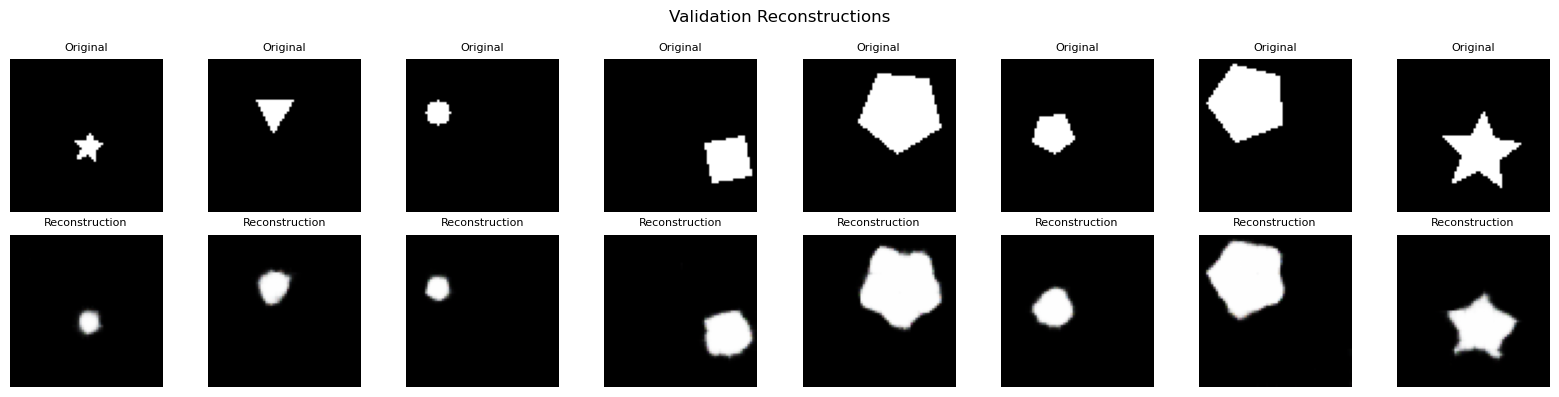

Epoch 34 Training: 100%|██████████| 48/48 [00:04<00:00, 10.27it/s, Beta=1e-10, ReconLoss=0.0057, KL_Loss=445.0894, BatchLoss=0.0057]


Epoch 34: Train Loss = 0.0062, Val Loss = 0.0100


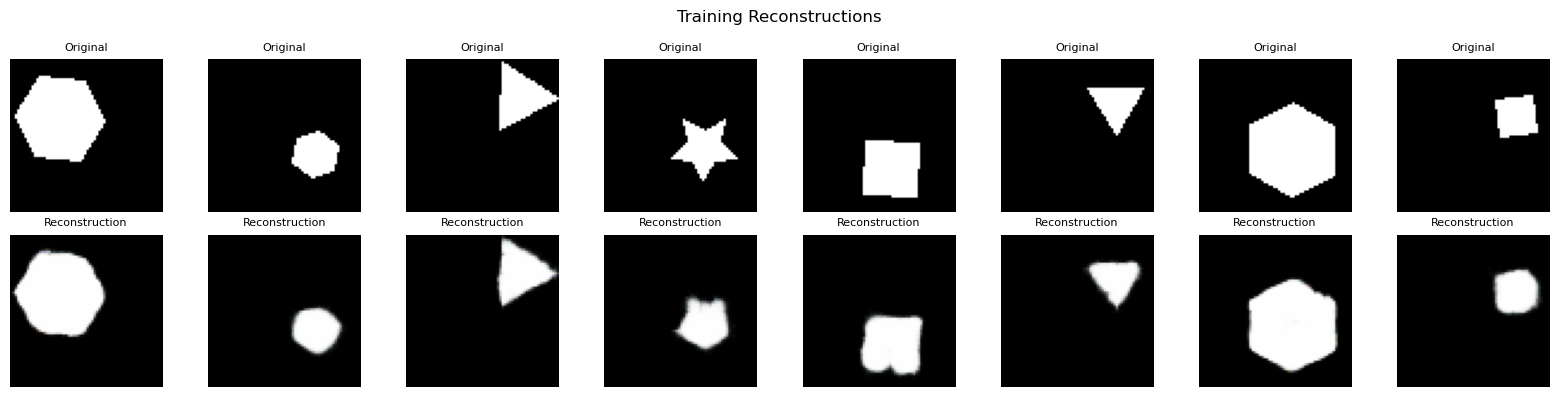

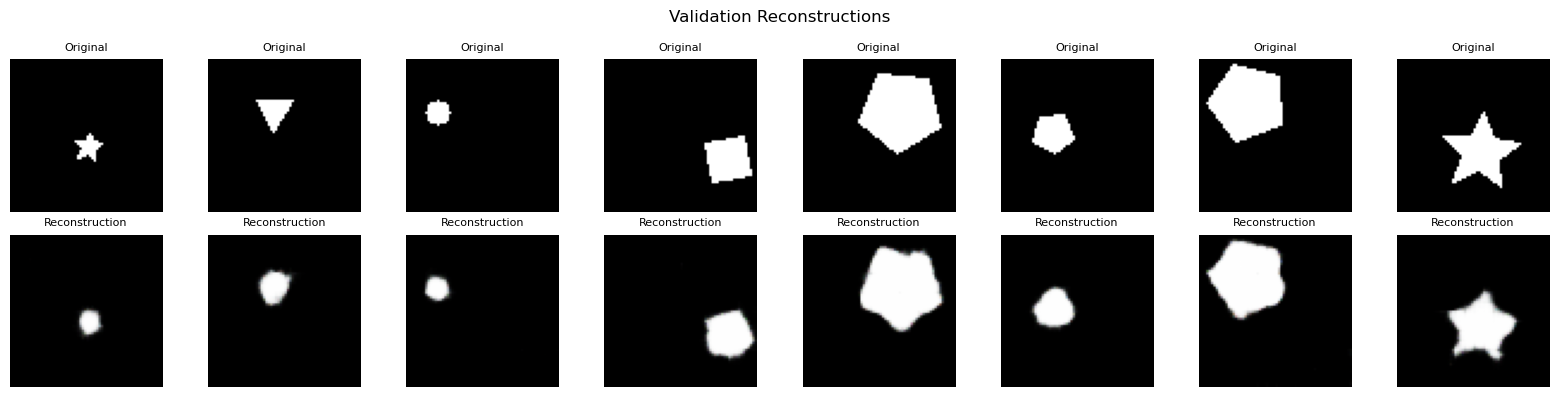

Epoch 35 Training: 100%|██████████| 48/48 [00:04<00:00, 10.37it/s, Beta=1e-10, ReconLoss=0.0042, KL_Loss=335.6405, BatchLoss=0.0042]


Epoch 35: Train Loss = 0.0062, Val Loss = 0.0100


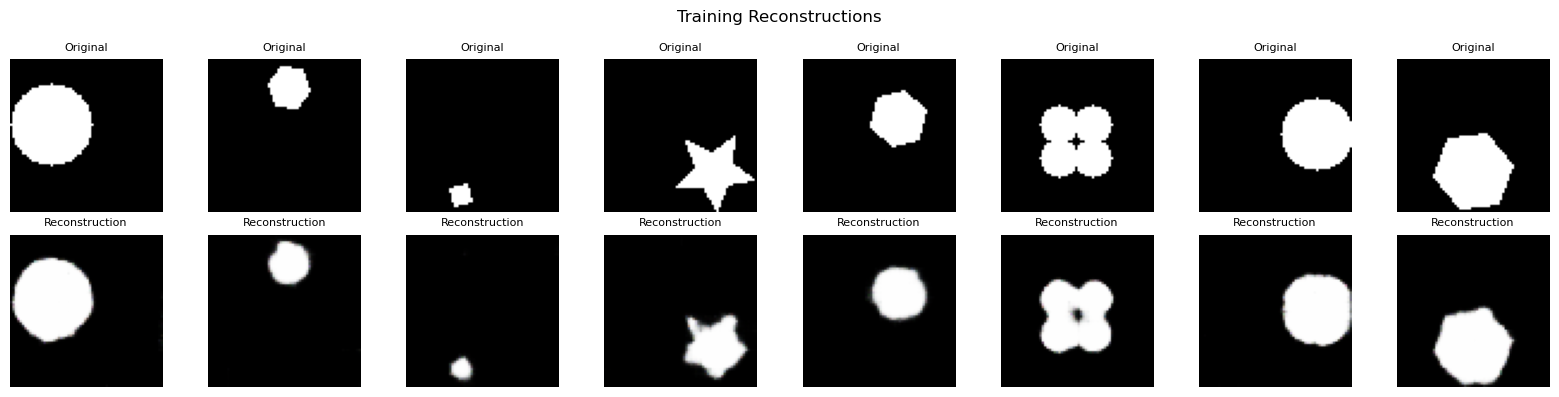

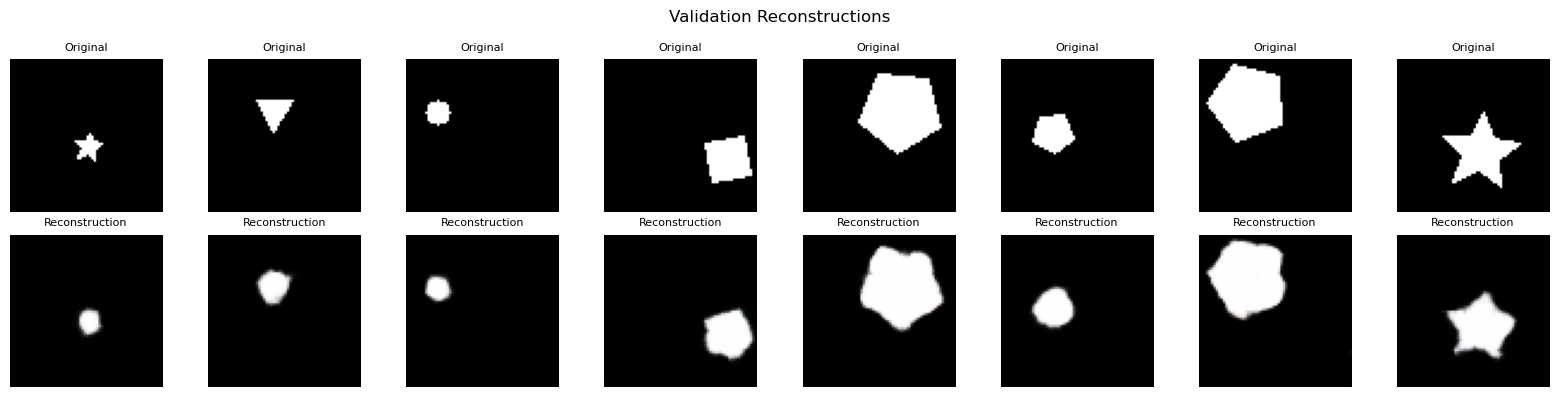

Epoch 36 Training: 100%|██████████| 48/48 [00:04<00:00, 10.30it/s, Beta=1e-10, ReconLoss=0.0068, KL_Loss=459.3789, BatchLoss=0.0068]


Epoch 36: Train Loss = 0.0062, Val Loss = 0.0101


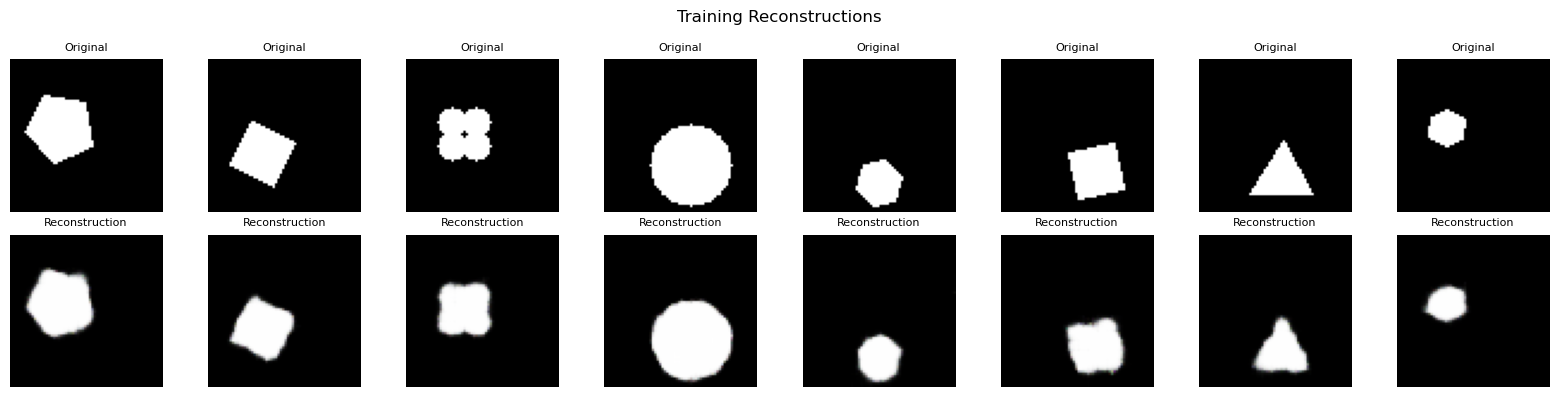

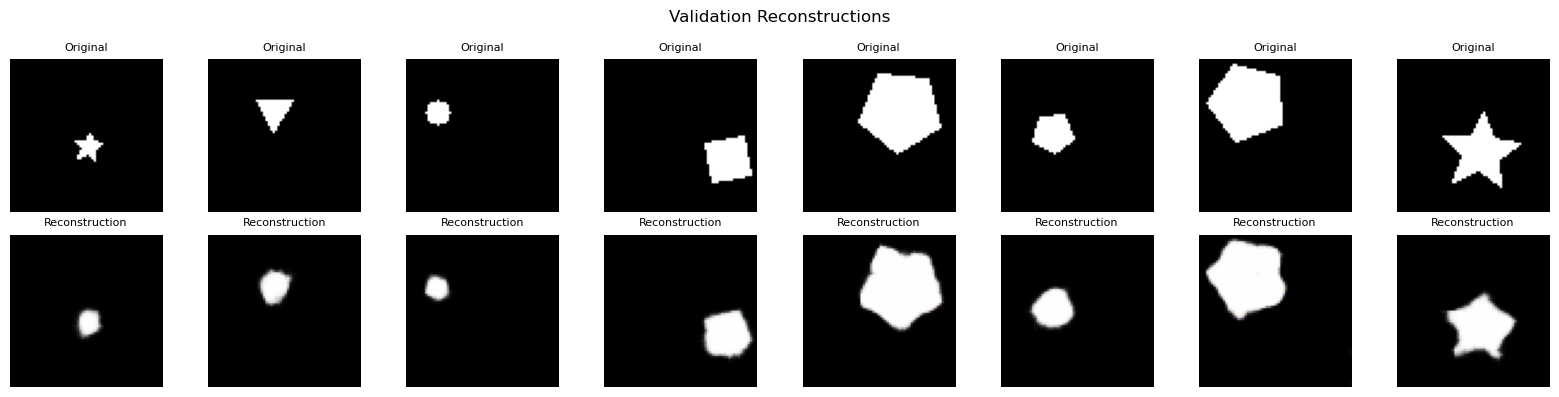

Epoch 37 Training: 100%|██████████| 48/48 [00:04<00:00, 10.48it/s, Beta=1e-10, ReconLoss=0.0075, KL_Loss=546.7407, BatchLoss=0.0075]


Epoch 37: Train Loss = 0.0062, Val Loss = 0.0104


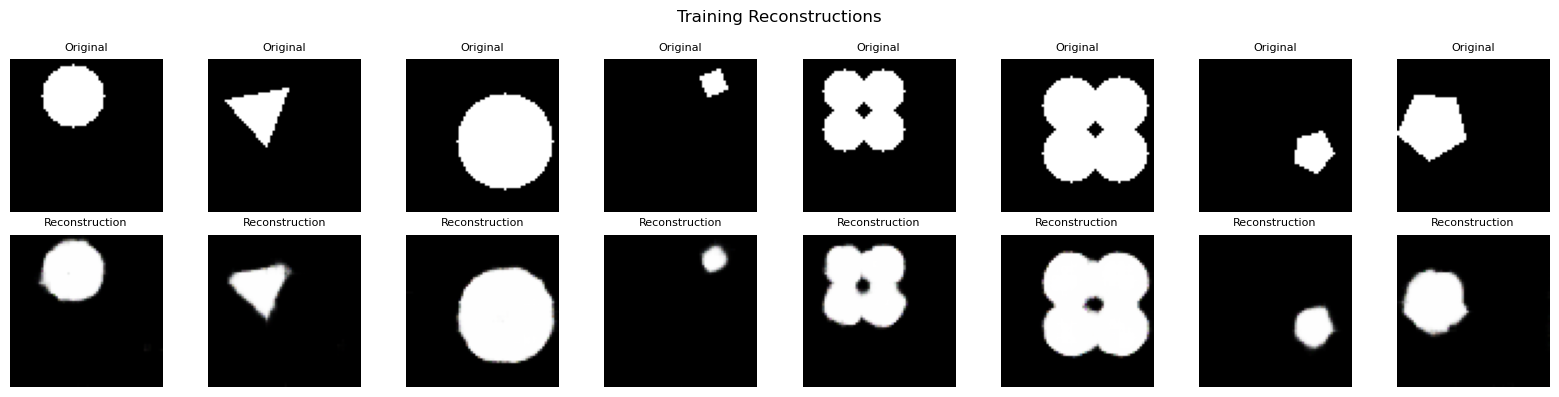

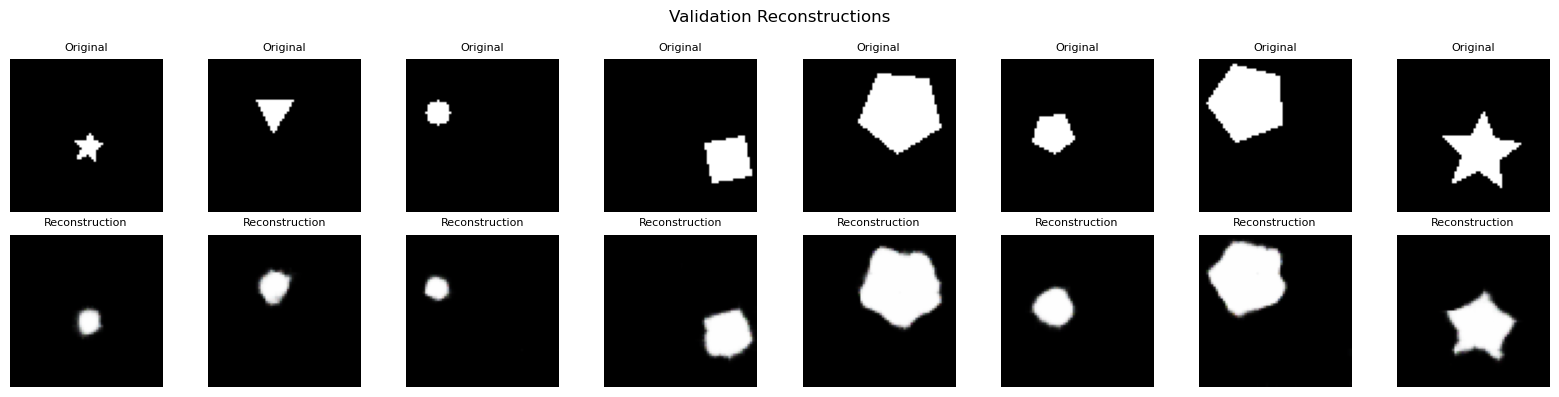

Epoch 38 Training: 100%|██████████| 48/48 [00:04<00:00, 10.39it/s, Beta=1e-10, ReconLoss=0.0070, KL_Loss=505.0337, BatchLoss=0.0070]


Epoch 38: Train Loss = 0.0064, Val Loss = 0.0098


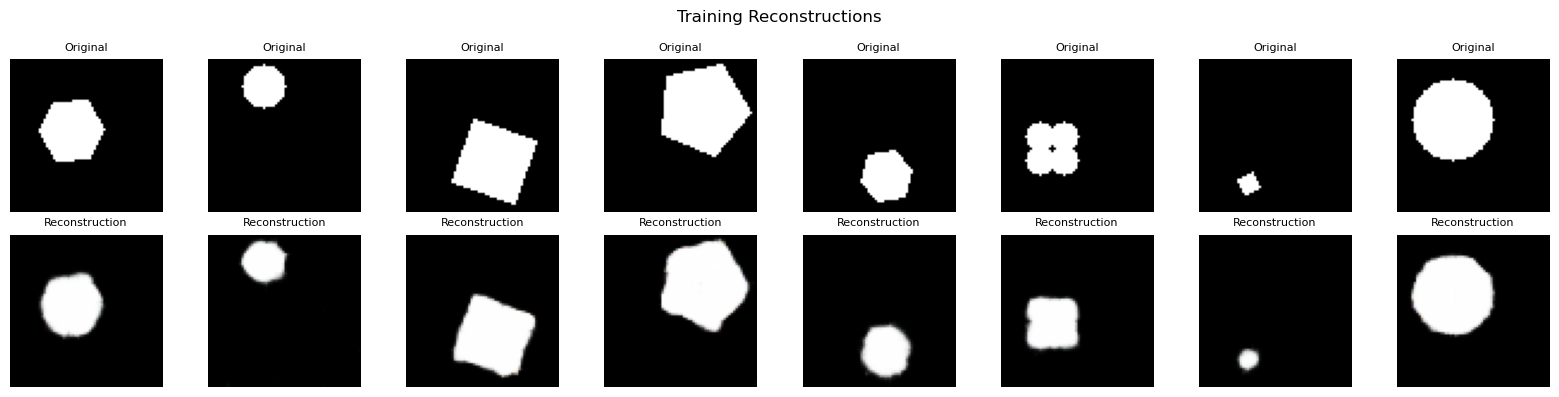

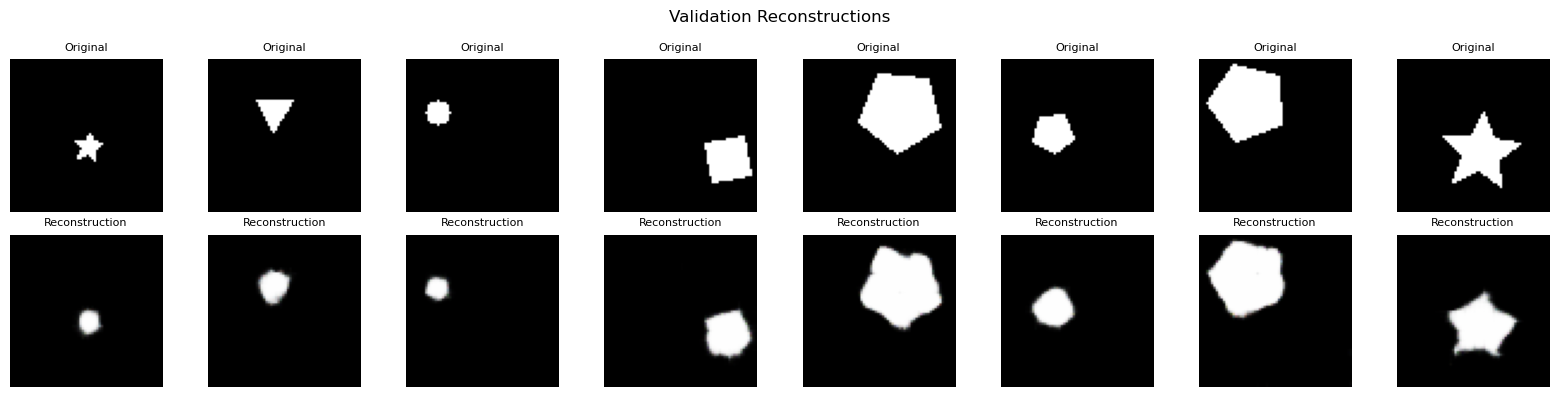

Epoch 39 Training: 100%|██████████| 48/48 [00:04<00:00, 10.45it/s, Beta=1e-10, ReconLoss=0.0062, KL_Loss=482.1501, BatchLoss=0.0062]


Epoch 39: Train Loss = 0.0060, Val Loss = 0.0097


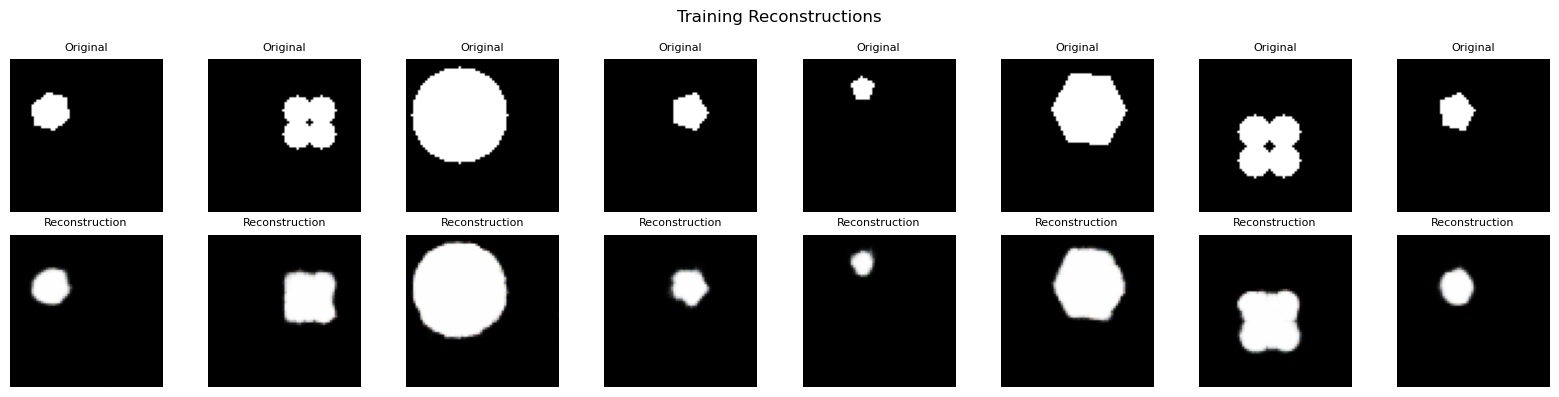

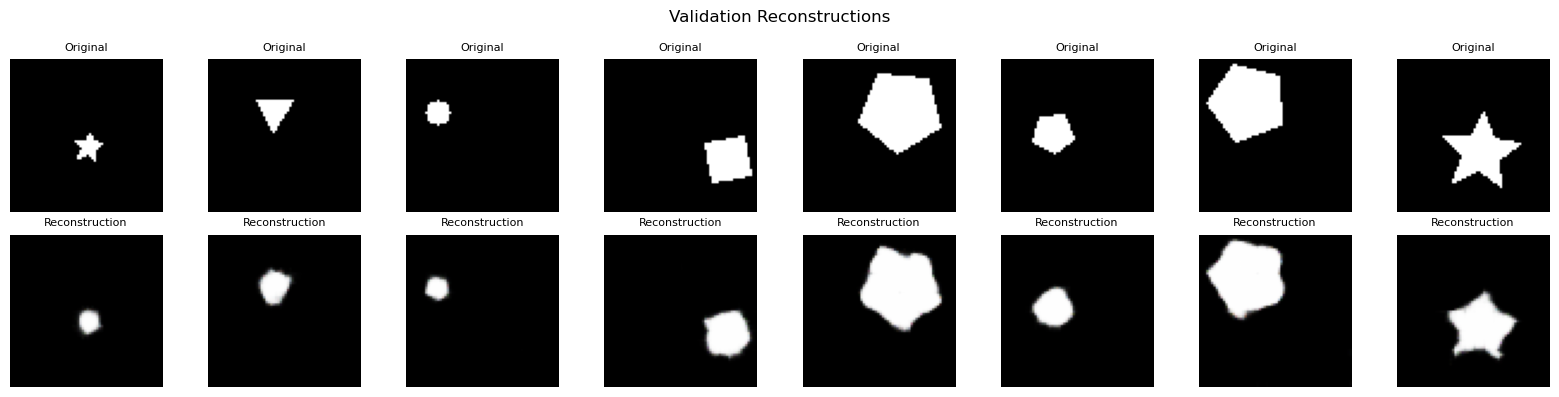

Epoch 40 Training: 100%|██████████| 48/48 [00:04<00:00, 10.40it/s, Beta=1e-10, ReconLoss=0.0063, KL_Loss=378.0144, BatchLoss=0.0063]


Epoch 40: Train Loss = 0.0059, Val Loss = 0.0101


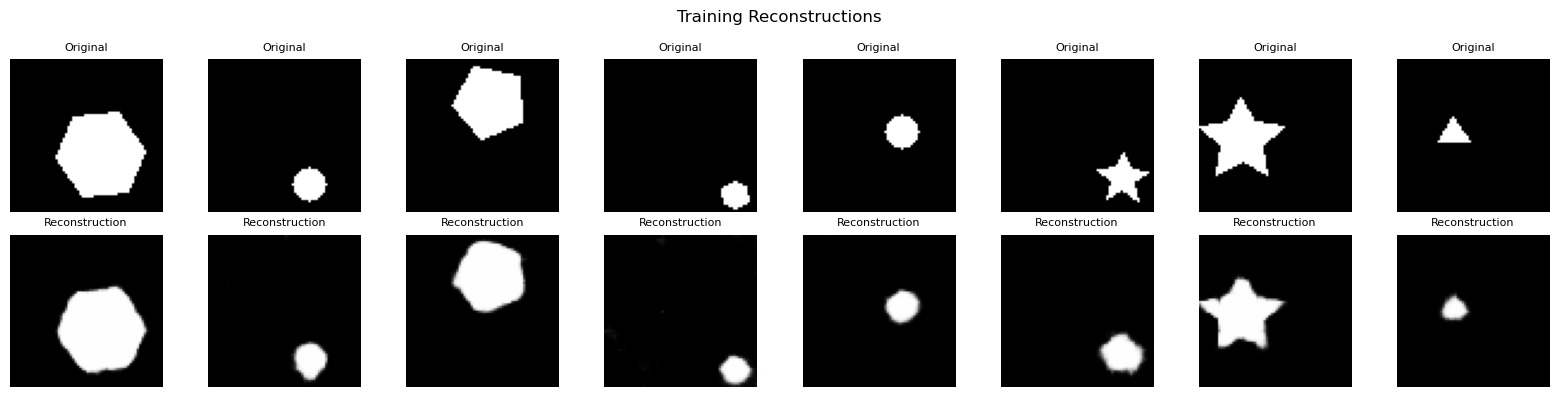

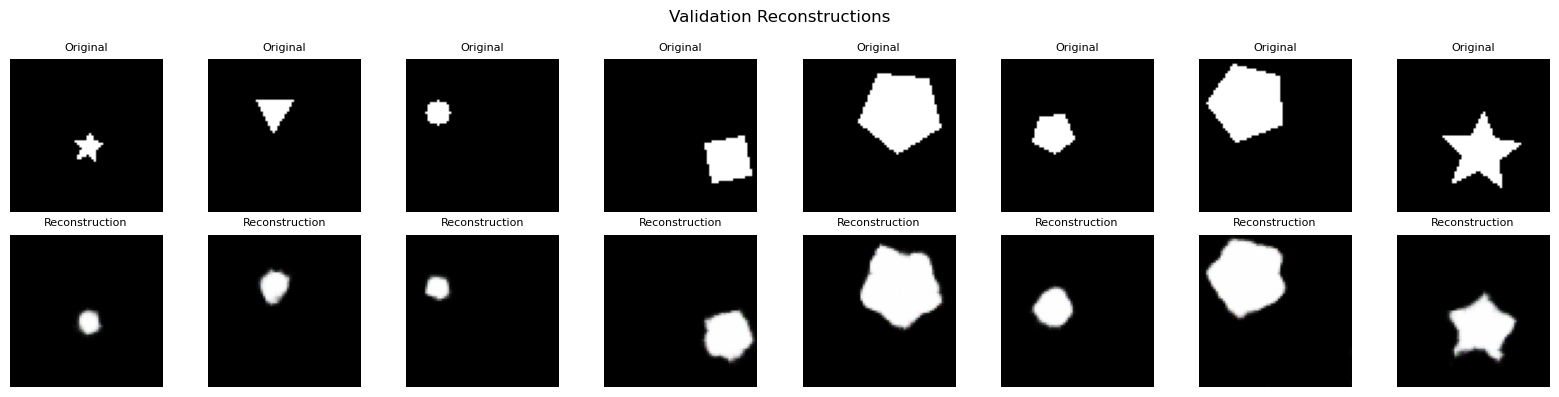

Epoch 41 Training: 100%|██████████| 48/48 [00:04<00:00, 10.39it/s, Beta=1e-10, ReconLoss=0.0068, KL_Loss=589.9702, BatchLoss=0.0068]


Epoch 41: Train Loss = 0.0060, Val Loss = 0.0102


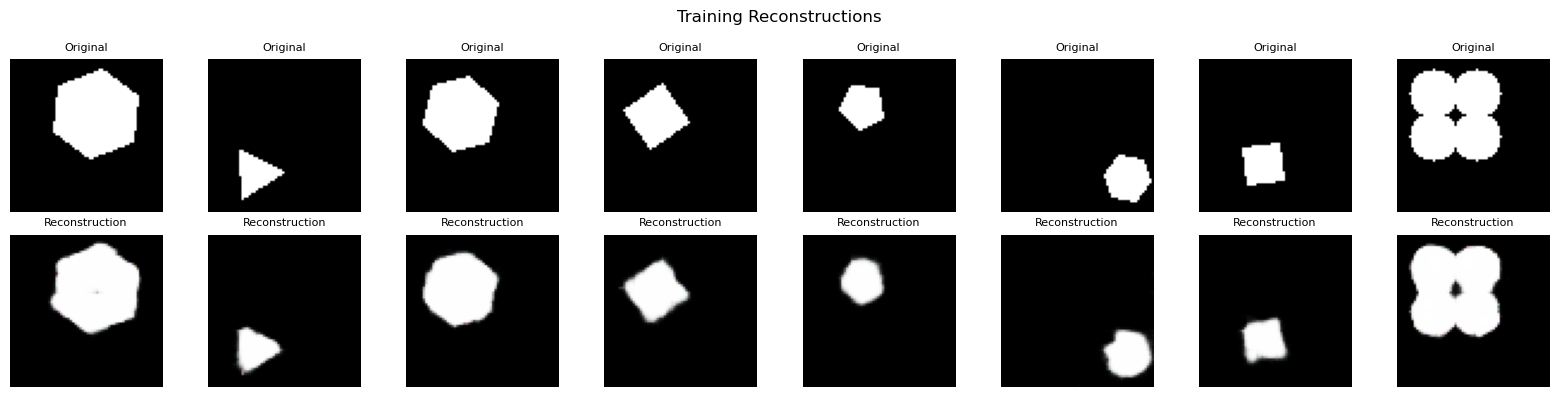

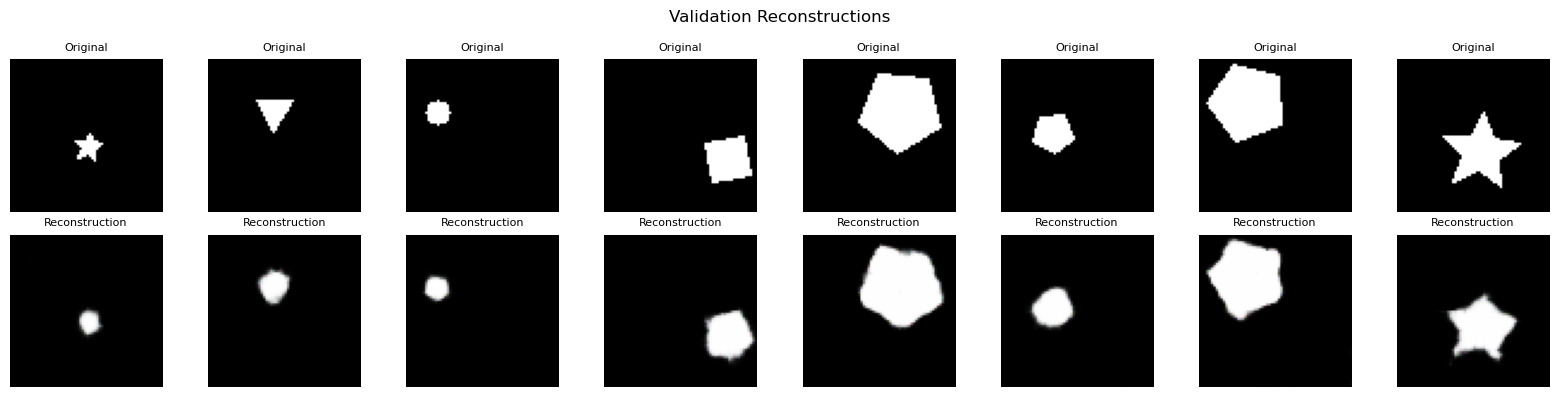

Epoch 42 Training: 100%|██████████| 48/48 [00:04<00:00, 10.17it/s, Beta=1e-10, ReconLoss=0.0065, KL_Loss=607.2701, BatchLoss=0.0065]


Epoch 42: Train Loss = 0.0061, Val Loss = 0.0098


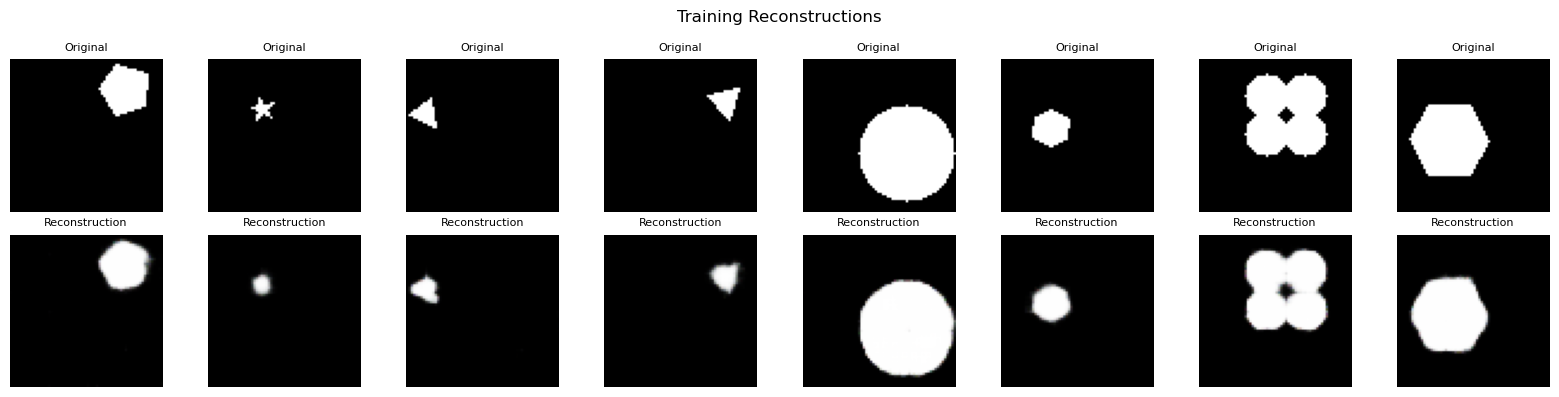

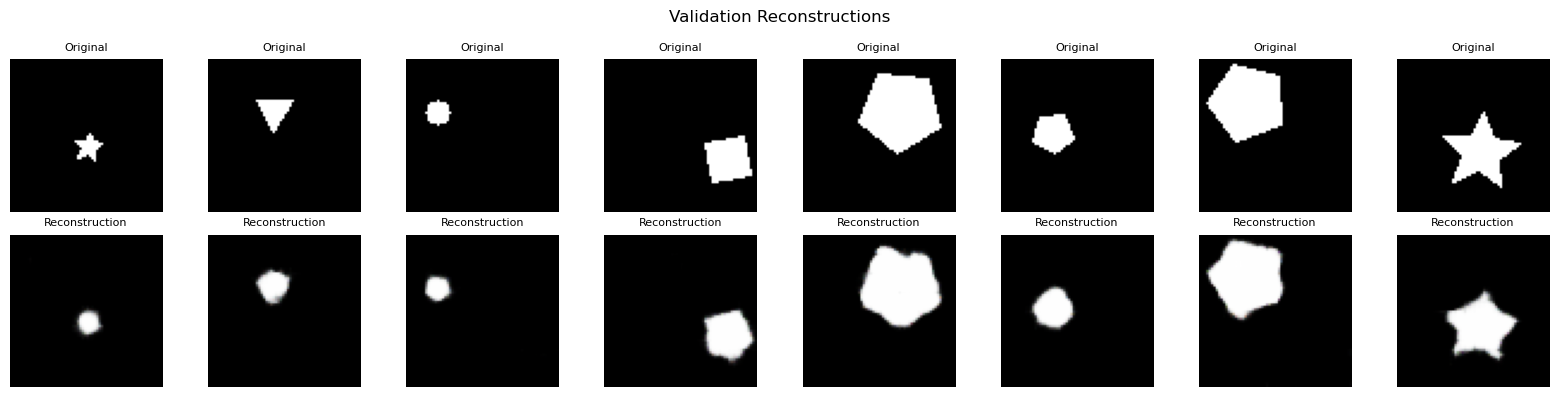

Epoch 43 Training: 100%|██████████| 48/48 [00:04<00:00, 10.15it/s, Beta=1e-10, ReconLoss=0.0055, KL_Loss=483.3697, BatchLoss=0.0055]


Epoch 43: Train Loss = 0.0059, Val Loss = 0.0097


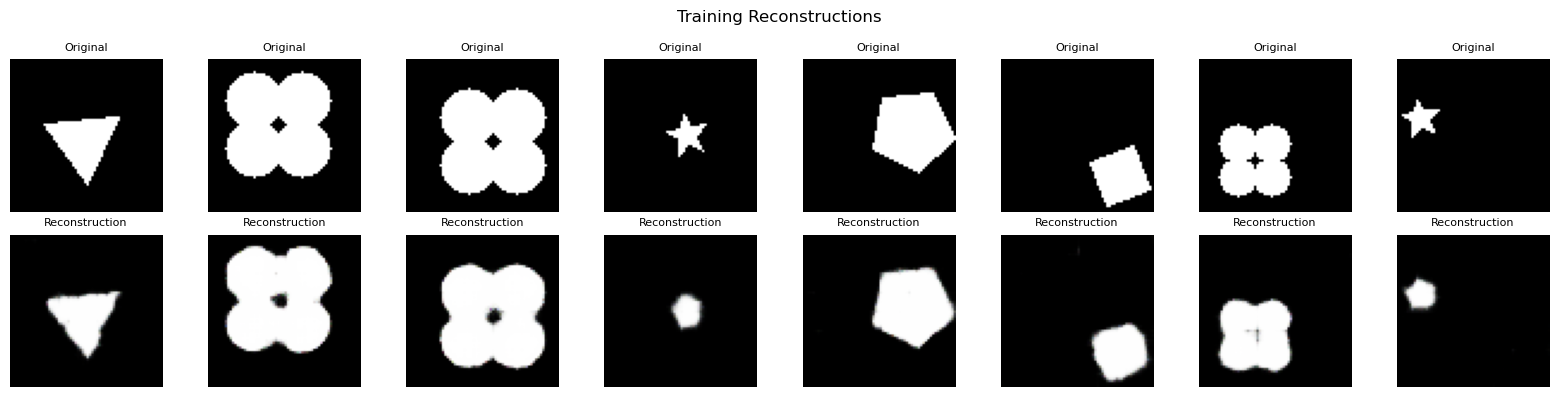

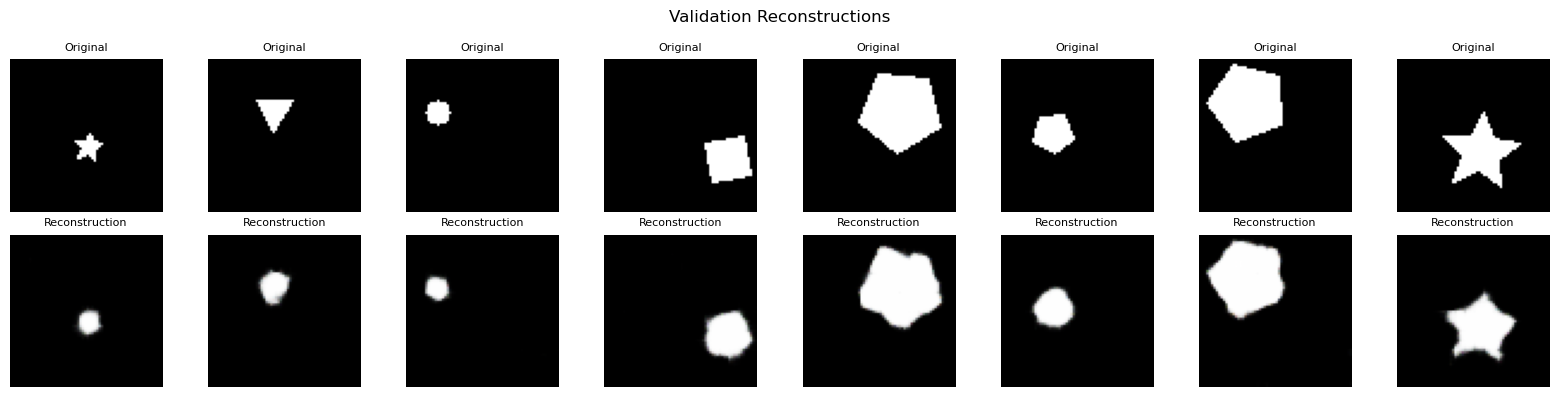

Epoch 44 Training: 100%|██████████| 48/48 [00:04<00:00, 10.22it/s, Beta=1e-10, ReconLoss=0.0044, KL_Loss=413.4530, BatchLoss=0.0044]


Epoch 44: Train Loss = 0.0056, Val Loss = 0.0098


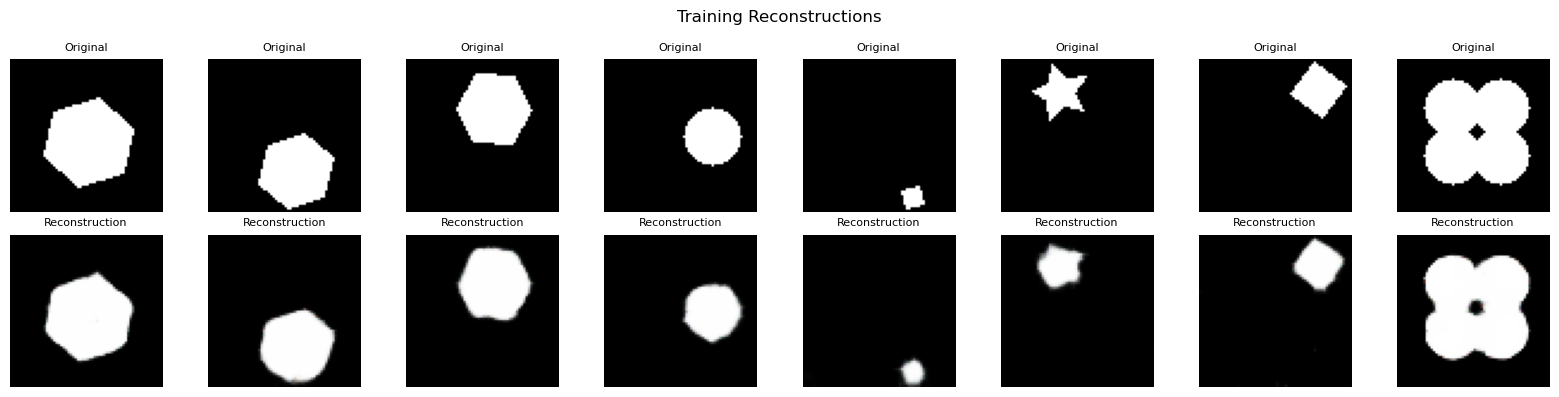

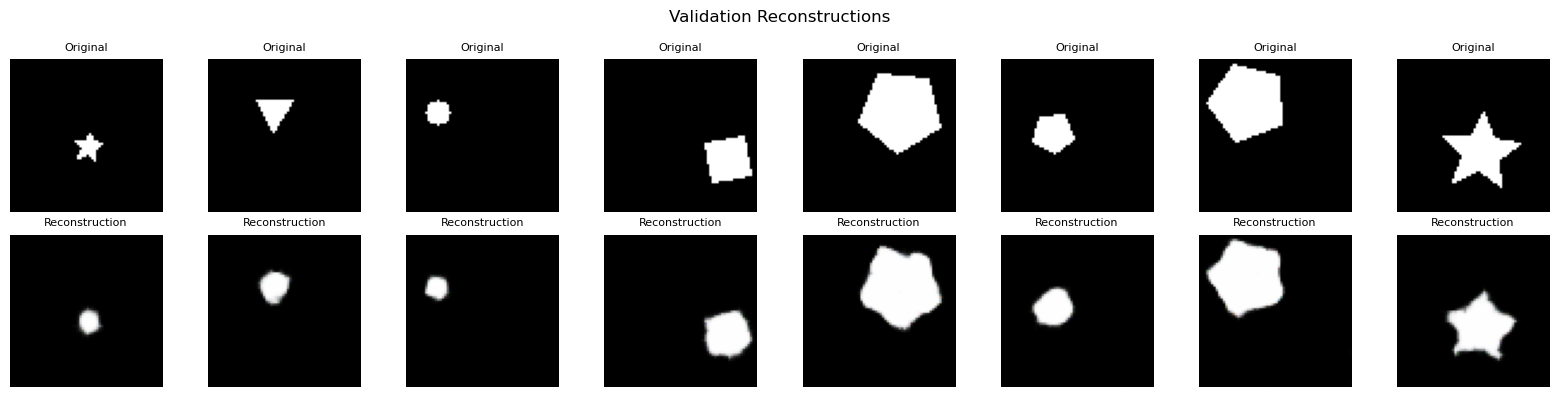

Epoch 45 Training: 100%|██████████| 48/48 [00:04<00:00, 10.43it/s, Beta=1e-10, ReconLoss=0.0045, KL_Loss=382.9547, BatchLoss=0.0045]


Epoch 45: Train Loss = 0.0057, Val Loss = 0.0100


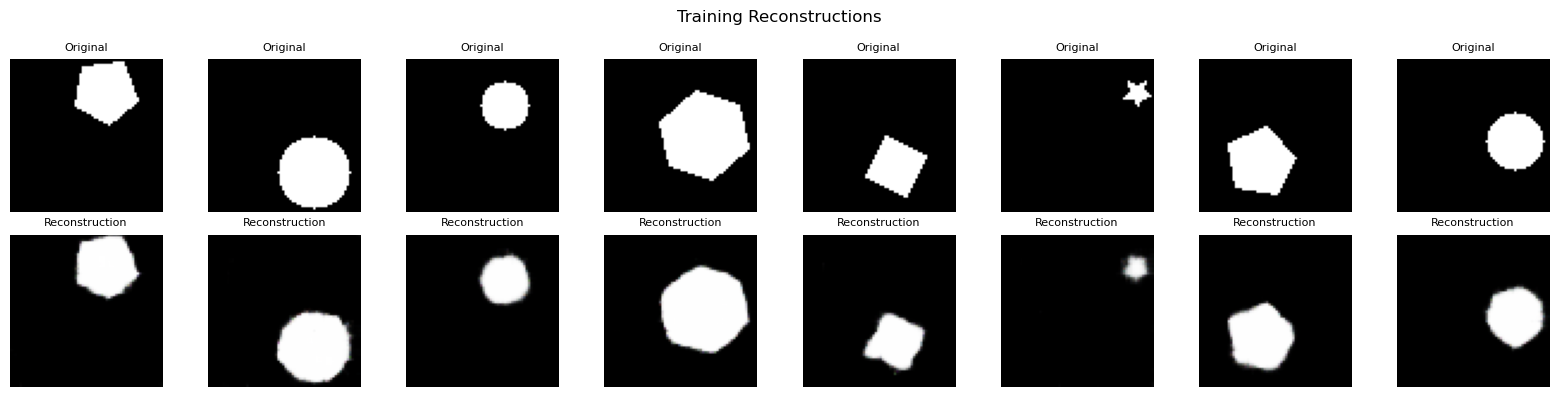

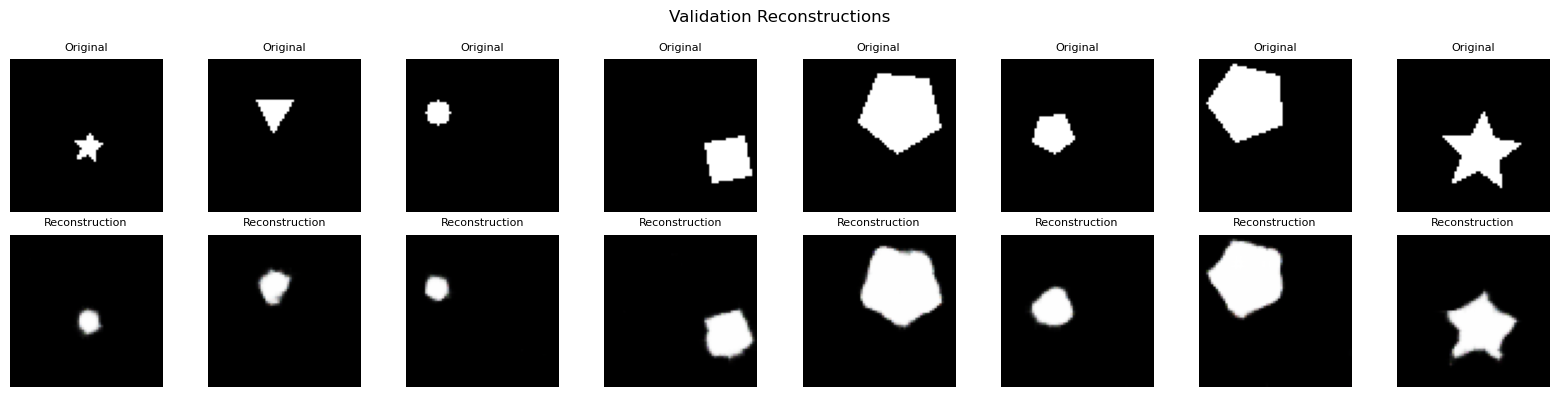

Epoch 46 Training: 100%|██████████| 48/48 [00:04<00:00, 10.56it/s, Beta=1e-10, ReconLoss=0.0057, KL_Loss=423.9335, BatchLoss=0.0057]


Epoch 46: Train Loss = 0.0057, Val Loss = 0.0098


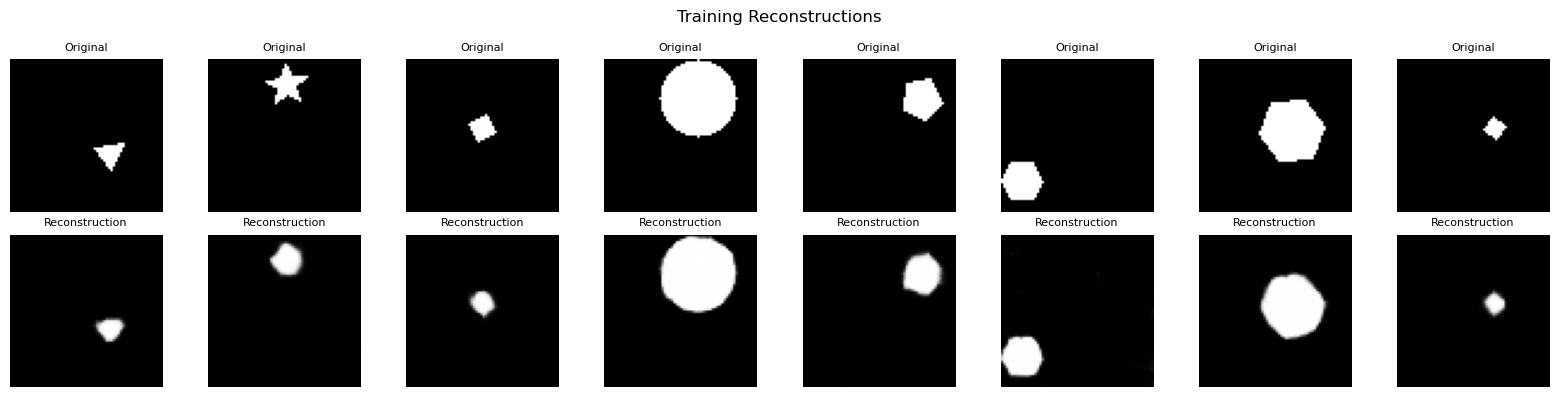

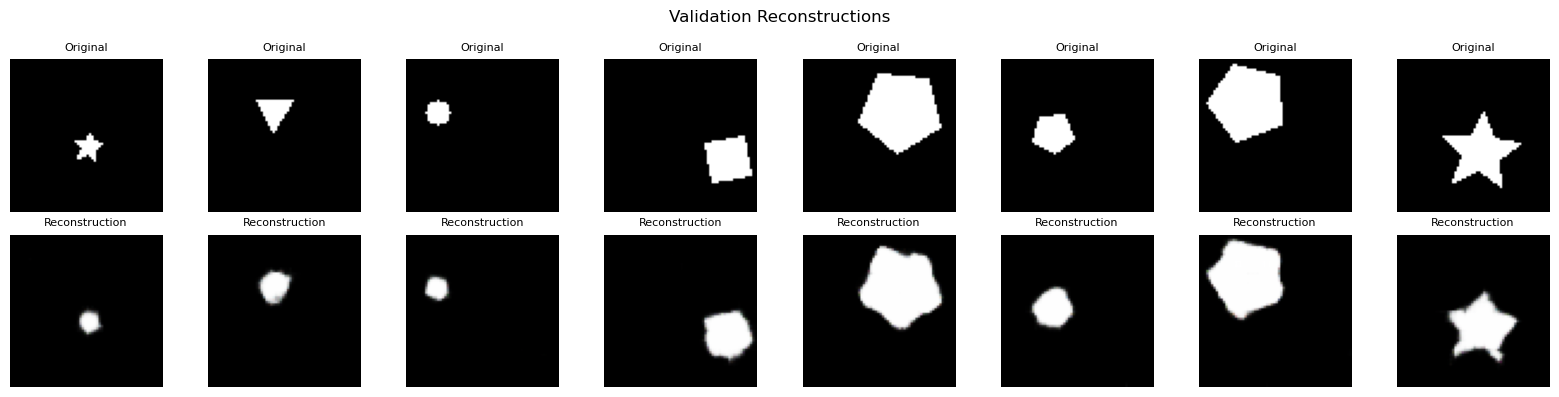

Epoch 47 Training: 100%|██████████| 48/48 [00:04<00:00, 10.35it/s, Beta=1e-10, ReconLoss=0.0058, KL_Loss=410.1982, BatchLoss=0.0058]


Epoch 47: Train Loss = 0.0055, Val Loss = 0.0099


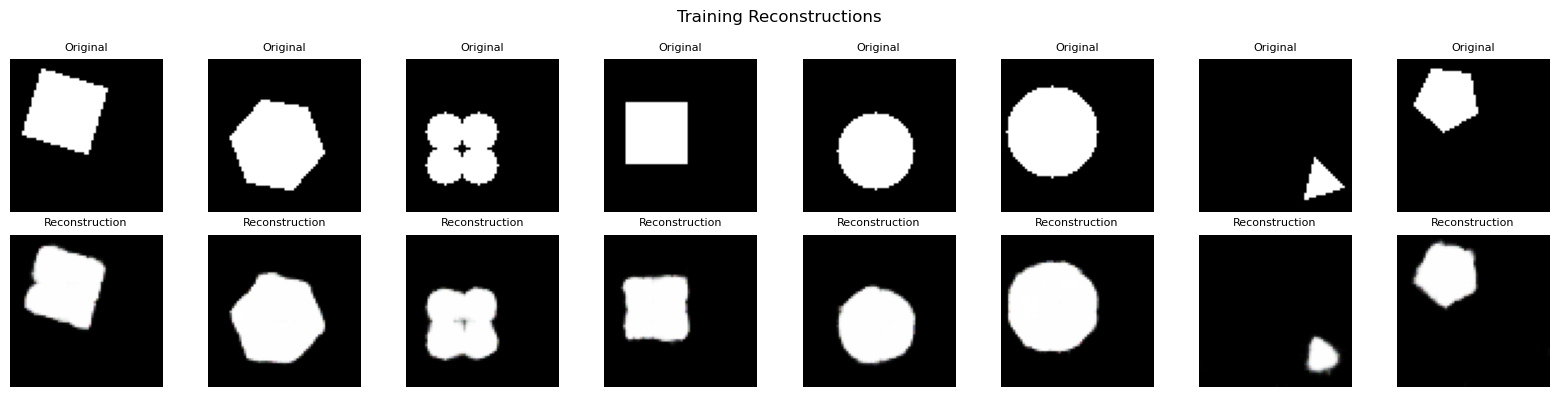

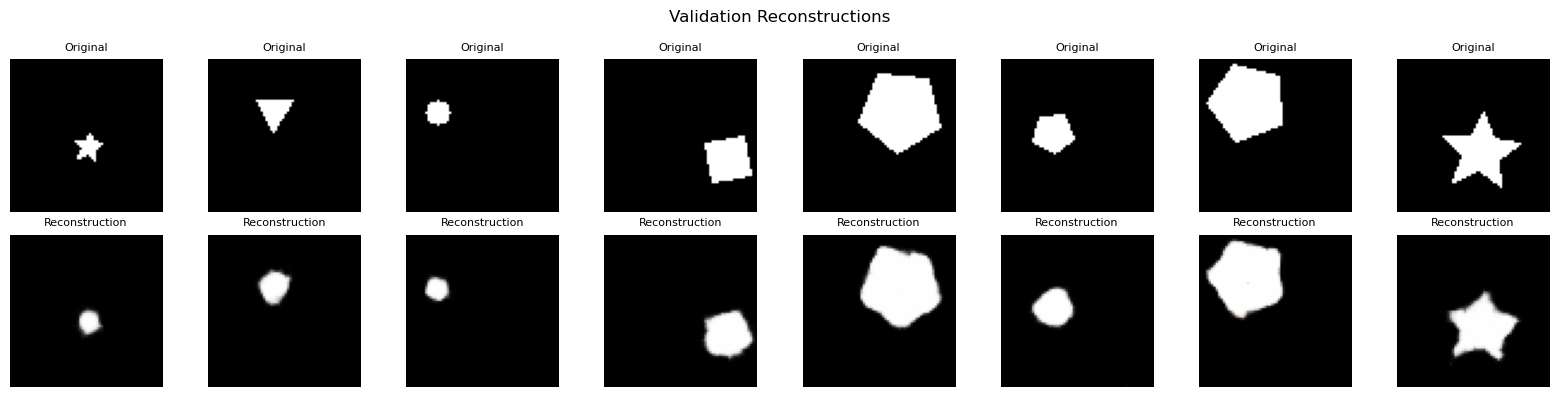

Epoch 48 Training: 100%|██████████| 48/48 [00:04<00:00, 10.63it/s, Beta=1e-10, ReconLoss=0.0057, KL_Loss=437.3038, BatchLoss=0.0057]


Epoch 48: Train Loss = 0.0055, Val Loss = 0.0098


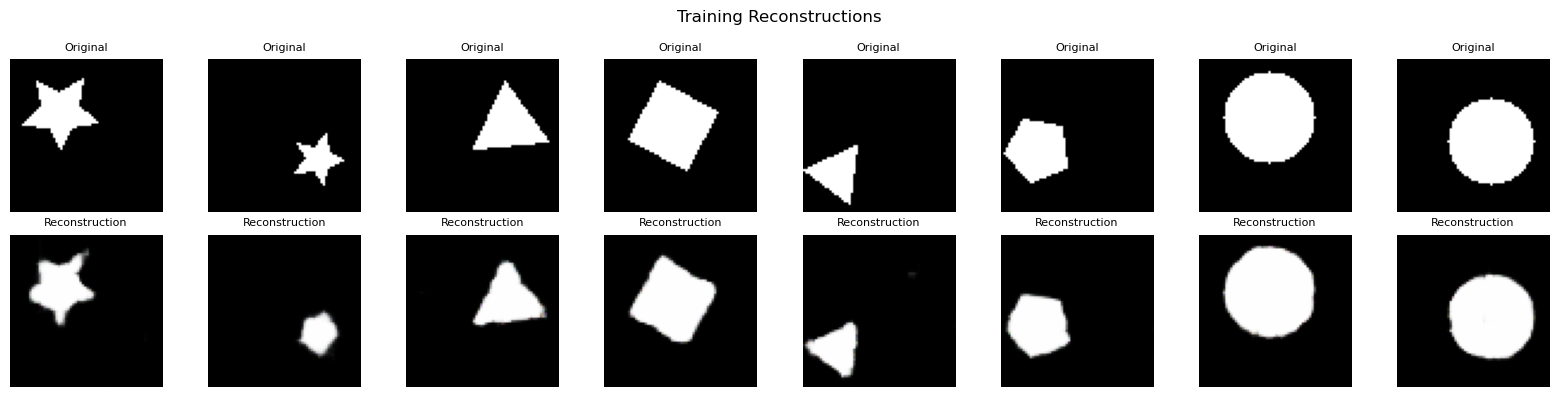

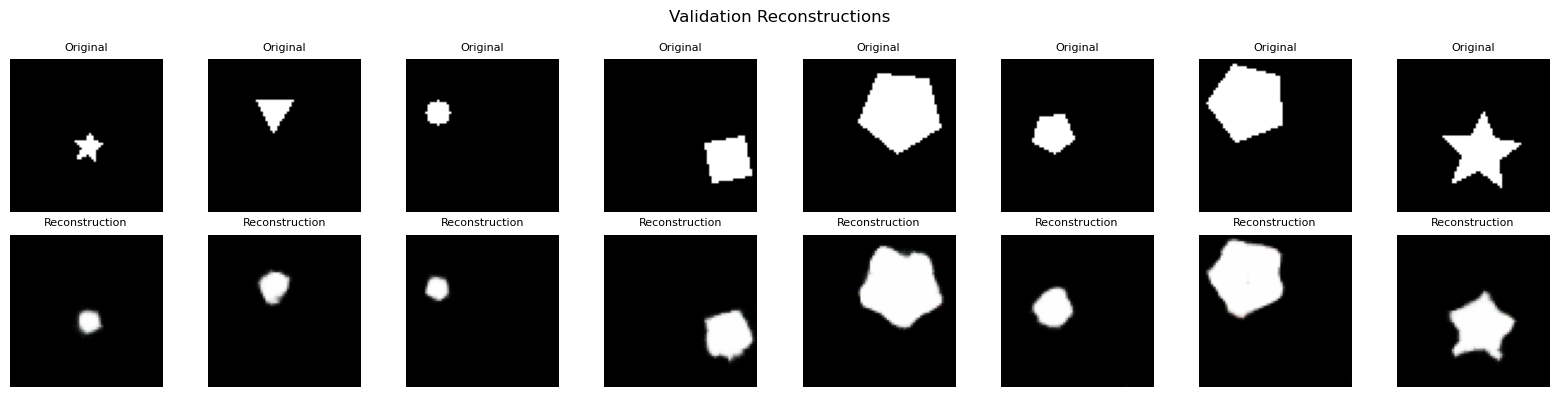

Epoch 49 Training: 100%|██████████| 48/48 [00:04<00:00, 10.52it/s, Beta=1e-10, ReconLoss=0.0072, KL_Loss=511.7120, BatchLoss=0.0072]


Epoch 49: Train Loss = 0.0056, Val Loss = 0.0099


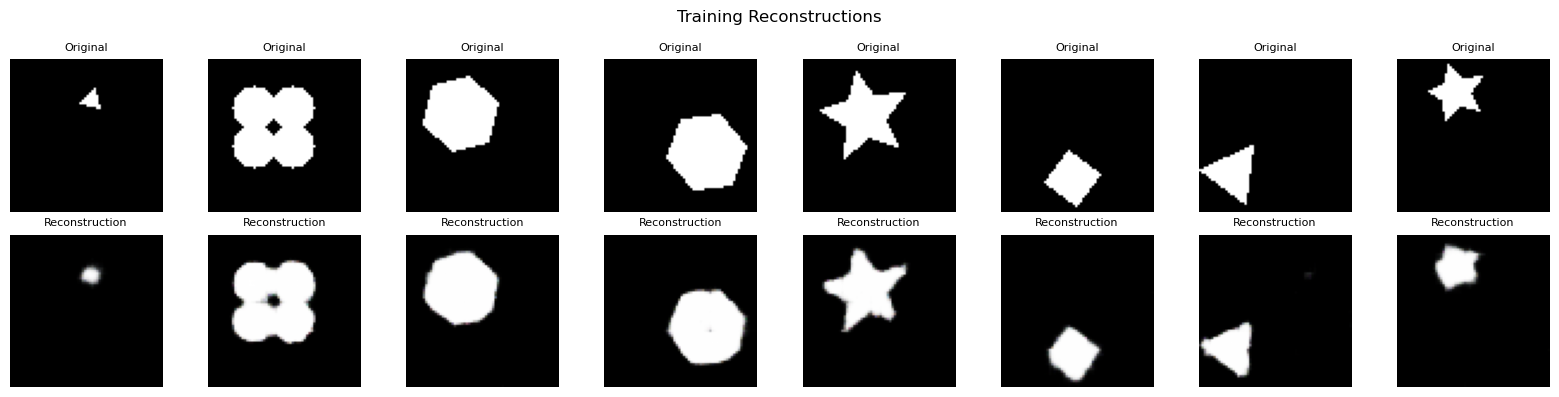

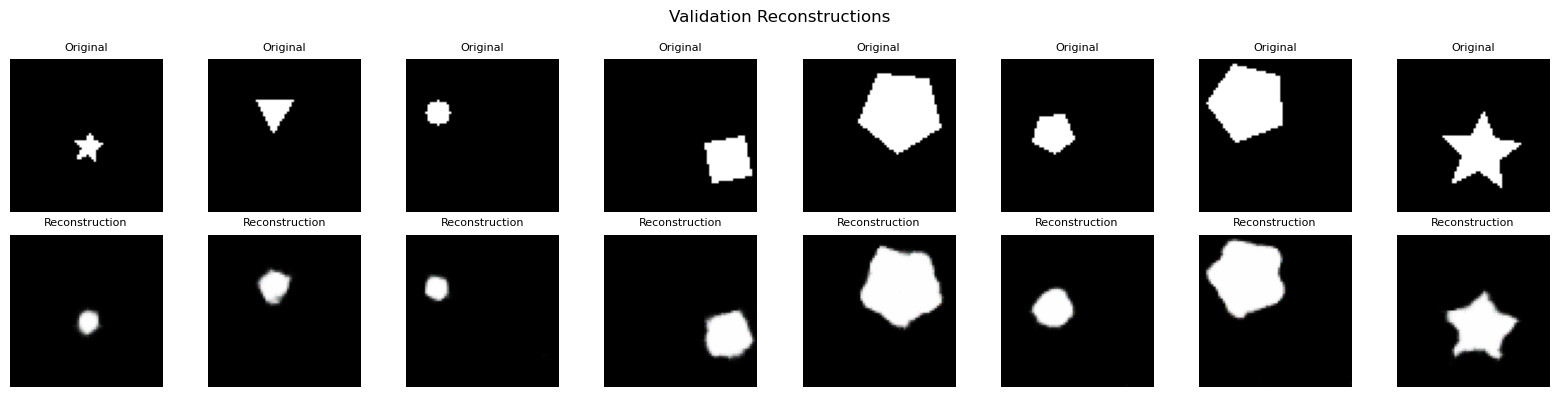

Epoch 50 Training: 100%|██████████| 48/48 [00:04<00:00, 10.51it/s, Beta=1e-10, ReconLoss=0.0063, KL_Loss=425.7408, BatchLoss=0.0063]


Epoch 50: Train Loss = 0.0056, Val Loss = 0.0100


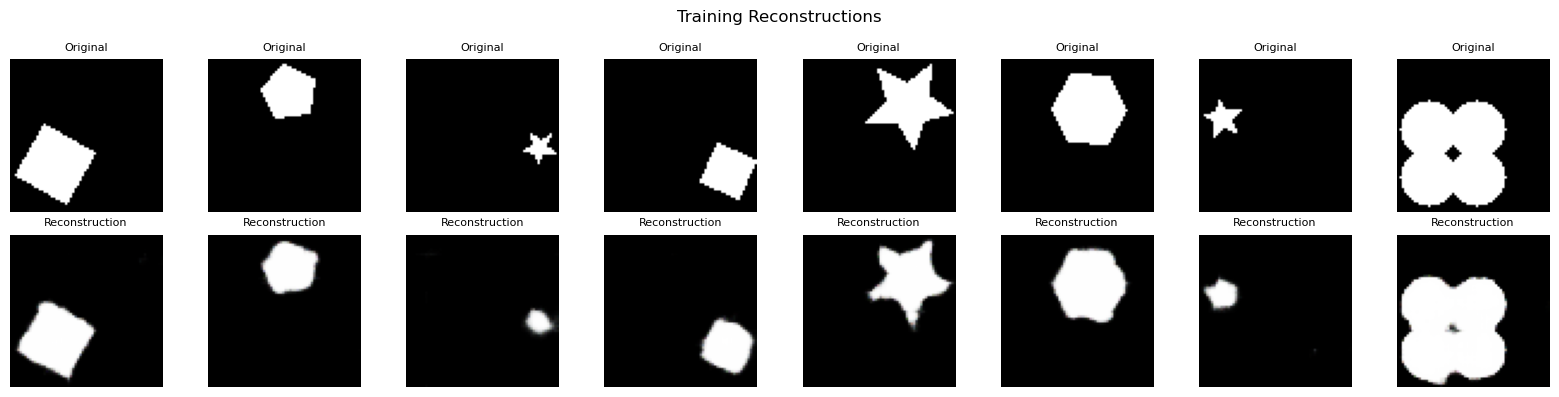

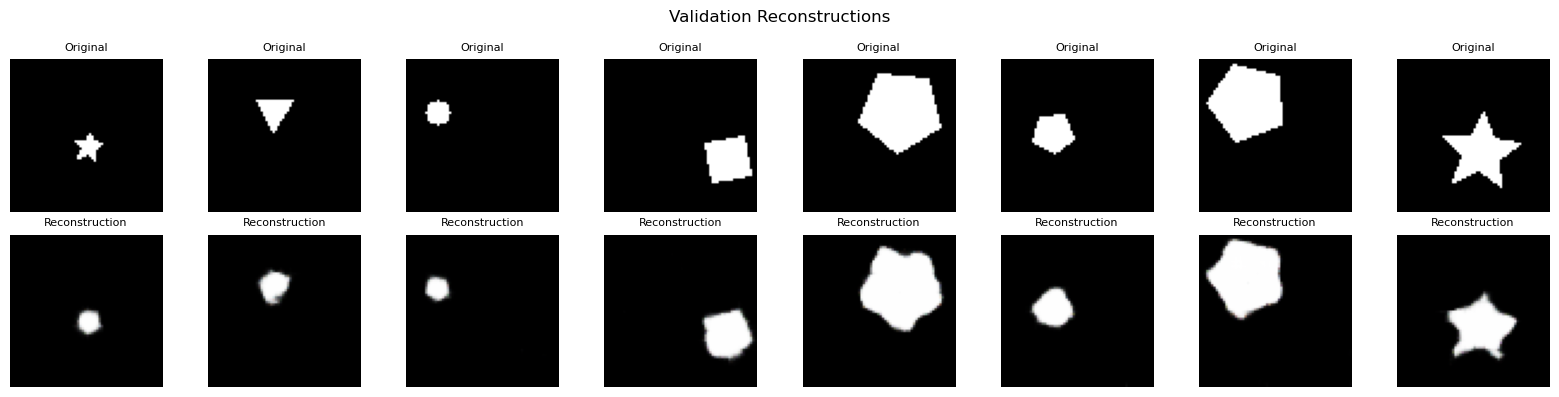

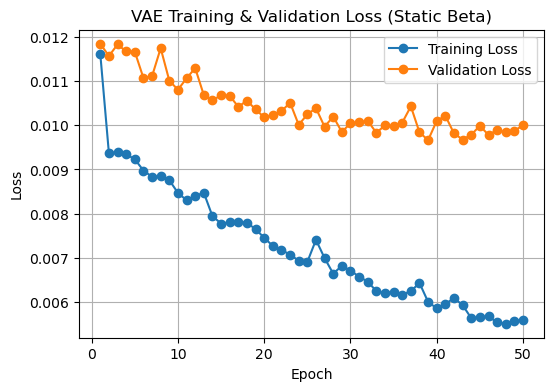

In [16]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set a constant beta value for the KL divergence.
beta = 0.0000000001  # Adjust this value as needed.

vae_optimizer = optim.Adam(vae.parameters(), lr=1e-3)
# Use mean reduction so that the reconstruction loss is averaged over all pixels.
recon_criterion = nn.MSELoss(reduction='mean')
n_epochs = 50  # Adjust as needed.
train_losses = []
val_losses = []

def kl_divergence(mu, logvar):
    # Compute KL divergence (averaged over the batch)
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

def plot_reconstructions(loader, phase="Training"):
    """
    Pull a single batch from the given loader, compute reconstructions,
    and display original and reconstructed images side by side.
    """
    vae.eval()
    with torch.no_grad():
        imgs, _ = next(iter(loader))
        imgs = imgs.to(device)
        recon, _, _ = vae(imgs)
    imgs = imgs.cpu()
    recon = recon.cpu()
    n = min(8, imgs.size(0))  # Show up to 8 images.
    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        # Convert tensor images from C x H x W to H x W x C for plotting.
        axes[0, i].imshow(np.transpose(imgs[i].numpy(), (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title("Original", fontsize=8)
        axes[1, i].imshow(np.transpose(recon[i].numpy(), (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstruction", fontsize=8)
    fig.suptitle(f"{phase} Reconstructions")
    plt.tight_layout()
    plt.show()

for epoch in range(n_epochs):
    vae.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
    for imgs, _ in pbar:
        imgs = imgs.to(device)
        vae_optimizer.zero_grad()
        recon, mu, logvar = vae(imgs)
        recon_loss = recon_criterion(recon, imgs)
        kl_loss = kl_divergence(mu, logvar)
        loss = recon_loss + beta * kl_loss  # Total loss.
        loss.backward()
        vae_optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        pbar.set_postfix({
            "Beta": beta,
            "ReconLoss": f"{recon_loss.item():.4f}",
            "KL_Loss": f"{kl_loss.item():.4f}",
            "BatchLoss": f"{loss.item():.4f}"
        })
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    vae.eval()
    running_val = 0.0
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            recon, mu, logvar = vae(imgs)
            recon_loss = recon_criterion(recon, imgs)
            kl_loss = kl_divergence(mu, logvar)
            loss = recon_loss + beta * kl_loss
            running_val += loss.item() * imgs.size(0)
    val_loss = running_val / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    
    # Plot reconstructions for a batch from training and validation sets.
    plot_reconstructions(train_loader, phase="Training")
    plot_reconstructions(val_loader, phase="Validation")
    
plt.figure(figsize=(6,4))
epochs_range = np.arange(1, n_epochs+1)
plt.plot(epochs_range, train_losses, marker='o', label="Training Loss")
plt.plot(epochs_range, val_losses, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training & Validation Loss (Static Beta)")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Extract latent features from the test set.
vae.eval()
all_latents = []
all_labels = []
for imgs, labels in test_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        latent = vae.get_latent(imgs)
    all_latents.append(latent.cpu().numpy())
    all_labels.extend(labels.numpy())
test_latents = np.concatenate(all_latents, axis=0)
test_labels = np.array(all_labels)
print("Extracted latent features shape:", test_latents.shape)

# Also extract file paths for the test images.
# 'test_dataset' is a Subset of the full dataset.
test_img_paths = []
for i in range(len(test_dataset)):
    idx = test_dataset.indices[i]  # get the corresponding index in the full dataset
    test_img_paths.append(dataset.imgs[idx][0])
print("Number of test image paths:", len(test_img_paths))

# Save latent features, labels, and file paths in a tuple for later use.
latent_data = (test_latents, test_labels, test_img_paths)

Extracted latent features shape: (420, 32)
Number of test image paths: 420


/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy = 42.14%, F1 Score = 0.4161
Random Forest: Accuracy = 100.00%, F1 Score = 1.0000


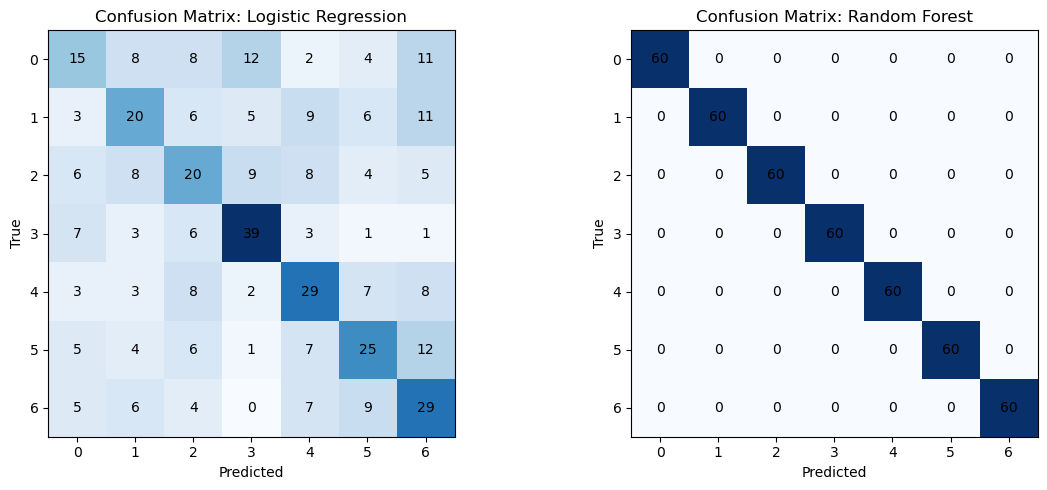

In [13]:
# For demonstration, we use the test set for both training and evaluation.
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(test_latents, test_labels)
lr_preds = lr_clf.predict(test_latents)
lr_acc = accuracy_score(test_labels, lr_preds) * 100
lr_f1 = f1_score(test_labels, lr_preds, average='macro')

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(test_latents, test_labels)
rf_preds = rf_clf.predict(test_latents)
rf_acc = accuracy_score(test_labels, rf_preds) * 100
rf_f1 = f1_score(test_labels, rf_preds, average='macro')

print(f"Logistic Regression: Accuracy = {lr_acc:.2f}%, F1 Score = {lr_f1:.4f}")
print(f"Random Forest: Accuracy = {rf_acc:.2f}%, F1 Score = {rf_f1:.4f}")

# Plot confusion matrices.
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_lr = confusion_matrix(test_labels, lr_preds)
axs[0].imshow(cm_lr, cmap="Blues")
axs[0].set_title("Confusion Matrix: Logistic Regression")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")
axs[0].set_xticks(np.arange(len(np.unique(test_labels))))
axs[0].set_yticks(np.arange(len(np.unique(test_labels))))
for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        axs[0].text(j, i, cm_lr[i,j], ha="center", va="center", color="black")

cm_rf = confusion_matrix(test_labels, rf_preds)
axs[1].imshow(cm_rf, cmap="Blues")
axs[1].set_title("Confusion Matrix: Random Forest")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")
axs[1].set_xticks(np.arange(len(np.unique(test_labels))))
axs[1].set_yticks(np.arange(len(np.unique(test_labels))))
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        axs[1].text(j, i, cm_rf[i,j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()

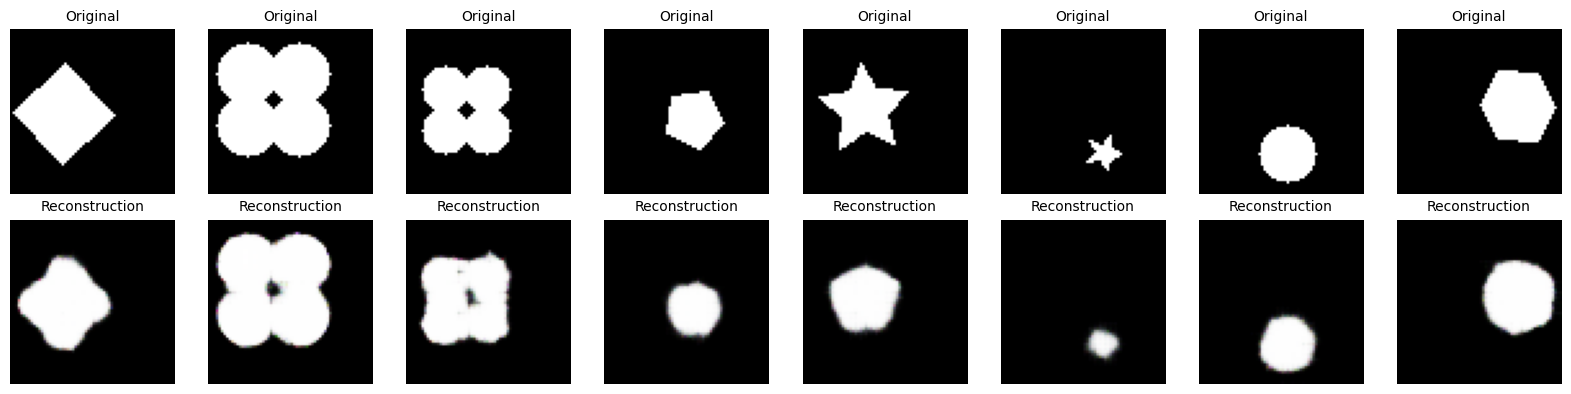

In [14]:
# Cell: Reconstruct and Plot Images from Latent Space

import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# Get a batch of test images.
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

vae.eval()
with torch.no_grad():
    # Get the latent representation (we use the mean from the encoder).
    latent = vae.get_latent(images)
    # Decode: Pass latent through the decoder.
    h_dec = vae.decoder_fc(latent)
    reconstructions = vae.decoder_conv(h_dec)

# Move images to CPU.
images = images.cpu()
reconstructions = reconstructions.cpu()

# Convert tensors to PIL images for visualization.
to_pil = ToPILImage()

n = min(8, images.size(0))  # number of images to display
fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
for i in range(n):
    axes[0, i].imshow(to_pil(images[i]))
    axes[0, i].axis('off')
    axes[0, i].set_title("Original", fontsize=10)
    
    axes[1, i].imshow(to_pil(reconstructions[i]))
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstruction", fontsize=10)

plt.tight_layout()
plt.show()

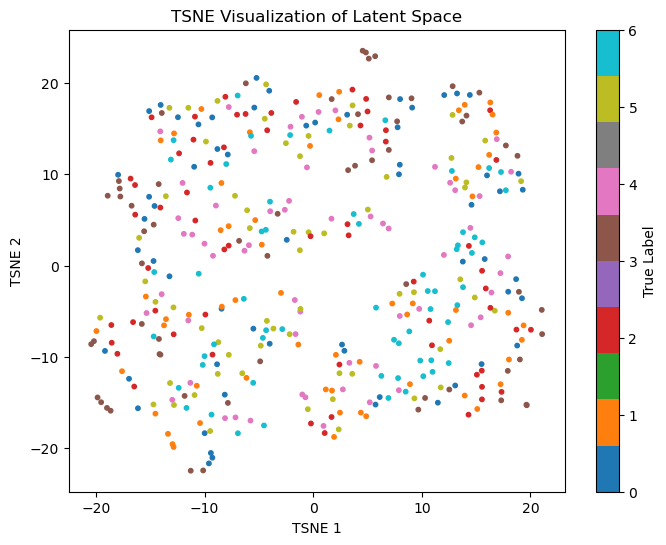

In [15]:
from sklearn.manifold import TSNE

# Assuming test_latents and test_labels have been defined in a previous cell.
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(test_latents)

plt.figure(figsize=(8,6))
scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=test_labels, cmap='tab10', s=10)
plt.title("TSNE Visualization of Latent Space")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.colorbar(scatter, label="True Label")
plt.show()

In [11]:
# Ensure latent_data is available.
test_latents, test_labels, test_img_paths = latent_data

# Create interactive widgets for selecting latent dimensions.
x_slider = widgets.IntSlider(value=0, min=0, max=test_latents.shape[1]-1, description='X Dim:')
y_slider = widgets.IntSlider(value=1, min=0, max=test_latents.shape[1]-1, description='Y Dim:')

# Create a dropdown widget to select a sample.
options = {}
for i, lbl in enumerate(test_labels):
    class_name = dataset.classes[lbl]
    options[f"Index {i} - {class_name}"] = i
sample_dropdown = widgets.Dropdown(options=options, description="Select sample:")

def update_visualization(x_index, y_index, sample_index):
    # Create a DataFrame for the scatter plot.
    df = pd.DataFrame({
        "x": test_latents[:, x_index],
        "y": test_latents[:, y_index],
        "label": test_labels.astype(str)
    })
    chart = alt.Chart(df).mark_circle(size=60).encode(
        x=alt.X("x", title=f"Latent Dimension {x_index}"),
        y=alt.Y("y", title=f"Latent Dimension {y_index}"),
        color=alt.Color("label:N", scale=alt.Scale(scheme="tableau10"), legend=alt.Legend(title="True Label")),
        tooltip=["x", "y", "label"]
    ).properties(
        width=500,
        height=400,
        title="Interactive Latent Space Visualization"
    )
    clear_output(wait=True)
    display(widgets.HBox([x_slider, y_slider, sample_dropdown]))
    display(chart)
    
    # Load and display the corresponding image.
    selected_path = test_img_paths[sample_index]
    try:
        img = Image.open(selected_path)
        print(f"Displaying image for sample index {sample_index}:")
        display(img)
    except Exception as e:
        print(f"Error loading image: {e}")

# Tie the widgets to the update function.
out = widgets.interactive_output(update_visualization, {'x_index': x_slider, 'y_index': y_slider, 'sample_index': sample_dropdown})
display(widgets.HBox([x_slider, y_slider, sample_dropdown]))
display(out)


Output()